<a href="https://colab.research.google.com/github/EdWangLoDaSc/Physical-based-Spatial-time-series-Prediction/blob/main/6-6_FinalVersion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:



import matplotlib.pyplot as plt
from scipy.interpolate import griddata


import time
from pylab import *
import matplotlib.gridspec as gridspec
import pandas as pd
from scipy.interpolate import griddata

# -*- coding: utf-8 -*-
import numpy as np
import scipy
import math
import matplotlib.pyplot as plt

from matplotlib import cm
from matplotlib import animation as animation

from PIL import Image
import matplotlib as mpl

import pickle

from sklearn.preprocessing import MinMaxScaler,StandardScaler
import random as rand
from sklearn.model_selection import train_test_split
#from skimage.metrics import structural_similarity as ssim
from skimage.metrics import structural_similarity as ssim



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Install

In [ ]:
def x_to_y(X): # averaging in 2*2 windows (4 pixels)
    dim = X.shape[0]
    dim = 20
    Y = np.zeros((int(dim/2),int(dim/2)))
    for i in range(int(dim/2)):
        for j in range(int(dim/2)):
            Y[i,j] = X[2*i,2*j] + X[2*i+1,2*j] + X[2*i,2*j+1] + X[2*i+1,2*j+1]

            Y_noise = np.random.multivariate_normal(np.zeros(100),0.0000 * np.eye(100))
            Y_noise.shape = (10,10)
            Y = Y + Y_noise
    return Y


class shallow(object):

    time = 0

    plt = []
    fig = []


    def __init__(self, x=[],y=[],h_ini = 1.,u=[],v = [],dx=0.01,dt=0.0001, N=64,L=1., px=16, py=16, R=64, Hp=0.1, g=1., b=0.): # How define no default argument before?


        # add a perturbation in pressure surface


        self.px, self.py = px, py
        self.R = R
        self.Hp = Hp



        # Physical parameters

        self.g = g
        self.b = b
        self.L=L
        self.N=N

        self.dx=dx
        self.dt=dt

        self.x,self.y = mgrid[:self.N,:self.N]

        self.u=zeros((self.N,self.N))
        self.v=zeros((self.N,self.N))

        self.h_ini=h_ini

        self.h=self.h_ini * ones((self.N,self.N))

        rr = (self.x-px)**2 + (self.y-py)**2
        self.h[rr<R] = self.h_ini + Hp #set initial conditions

        self.lims = [(self.h_ini-self.Hp,self.h_ini+self.Hp),(-0.02,0.02),(-0.02,0.02)]



    def dxy(self, A, axis=0):
        """
        Compute derivative of array A using balanced finite differences
        Axis specifies direction of spatial derivative (d/dx or d/dy)
        dA[i]/dx =  (A[i+1] - A[i-1] )  / 2dx
        """
        return (roll(A, -1, axis) - roll(A, 1, axis)) / (self.dx*2.) # roll: shift the array axis=0 shift the horizontal axis

    def d_dx(self, A):
        return self.dxy(A,1)

    def d_dy(self, A):
        return self.dxy(A,0)


    def d_dt(self, h, u, v):
        """
        http://en.wikipedia.org/wiki/Shallow_water_equations#Non-conservative_form
        """
        for x in [h, u, v]: # type check
           assert isinstance(x, ndarray) and not isinstance(x, matrix)

        g,b,dx = self.g, self.b, self.dx

        du_dt = -g*self.d_dx(h) - b*u
        dv_dt = -g*self.d_dy(h) - b*v

        H = 0 #h.mean() - our definition of h includes this term
        dh_dt = -self.d_dx(u * (H+h)) - self.d_dy(v * (H+h))

        return dh_dt, du_dt, dv_dt


    def evolve(self):
        """
        Evolve state (h, u, v) forward in time using simple Euler method
        x_{N+1} = x_{N} +   dx/dt * d_t
        """

        dh_dt, du_dt, dv_dt = self.d_dt(self.h, self.u, self.v)
        dt = self.dt

        self.h += dh_dt * dt
        self.u += du_dt * dt
        self.v += dv_dt * dt
        self.time += dt

        return self.h, self.u, self.v

In [ ]:
import random as rand
def simu(iteration_times, Hp, R, n_steps,blank_steps, px, py):
    SW = shallow(N=64, px=px, py=py, R=R, Hp=Hp, b=0.2)
    num = (iteration_times - blank_steps) // n_steps
    true_u_vect = np.zeros((num, SW.N, SW.N))
    true_v_vect = np.zeros((num, SW.N, SW.N))
    true_h_vect = np.zeros((num, SW.N, SW.N))
    index = 0

    for i in range(iteration_times):
        SW.evolve()

        if i % n_steps == 0 and i > 600:
            true_u_vect[index], true_v_vect[index], true_h_vect[index] = SW.u, SW.v, SW.h
            index += 1

    return true_u_vect, true_v_vect, true_h_vect


def structure_obs(N, random_range):
    x = np.arange(0, N, 5)
    y = np.arange(0, N, 5)
    x_list, y_list = np.meshgrid(x, y)

    x_coord = np.empty(x_list.size, dtype=int)
    y_coord = np.empty(y_list.size, dtype=int)

    for i, (x_val, y_val) in enumerate(zip(x_list.flatten(), y_list.flatten())):
        if (i+1) % 64 != 0:
            x_val += rand.randint(0, random_range)
            y_val += rand.randint(0, random_range)

        x_coord[i] = x_val if x_val < N else N - 1
        y_coord[i] = y_val if y_val < N else N - 1

    return x_coord, y_coord

def normalize_and_index(data, index):

  data_norm = (data - np.min(data)) / (np.max(data) - np.min(data))

  data_indexed = np.expand_dims(data_norm[index], axis=-1)
  #data_indexed = np.expand_dims(data[index], axis=-1)

  interval =(np.max(data) - np.min(data))
  return data_indexed, (np.max(data) - np.min(data)),np.min(data)

In [ ]:
import random

#random.seed(12)
random.seed(144)
second_element_range = (0.2, 1.0)
third_element_range = (4, 16)

# Number of random tuples to generate
num_random_tuples = 150
steps = 3600
blank_steps = 600
px = 32
py = 32
# Generate random tuples
sim_params = [(steps,
               round(random.uniform(*second_element_range), 2),
               random.randint(*third_element_range),
               10,
               blank_steps,
               px,#np.random.randint(30, 34),  # px
               py)#random.randint(30, 34))  # py
              for _ in range(num_random_tuples)]
# Simulate data and stack the results
def simulate_and_stack(sim_params):
    true_u_vect, true_v_vect, true_h_vect = [], [], []
    for nsteps, hp, r, n,blank,px,py in sim_params:
        u, v, h = simu(nsteps, hp, r**2, n,blank,px,py)
        true_u_vect.append(u)
        true_v_vect.append(v)
        true_h_vect.append(h)

    true_u_vect = np.vstack(true_u_vect)
    true_v_vect = np.vstack(true_v_vect)
    true_h_vect = np.vstack(true_h_vect)

    return true_u_vect, true_v_vect, true_h_vect

# Simulate data and stack the results
true_u_vect, true_v_vect, true_h_vect = simulate_and_stack(sim_params)

# Generate structure observations
x_coord, y_coord = structure_obs(64, 2)


In [ ]:
np.save('/content/drive/MyDrive/Physics/Physics/Dataset/true_u_full.npy',true_u_vect)
np.save('/content/drive/MyDrive/Physics/Physics/Dataset/true_v_full.npy',true_v_vect)
np.save('/content/drive/MyDrive/Physics/Physics/Dataset/true_h_full.npy',true_h_vect)
del true_u_vect,true_v_vect,true_h_vect

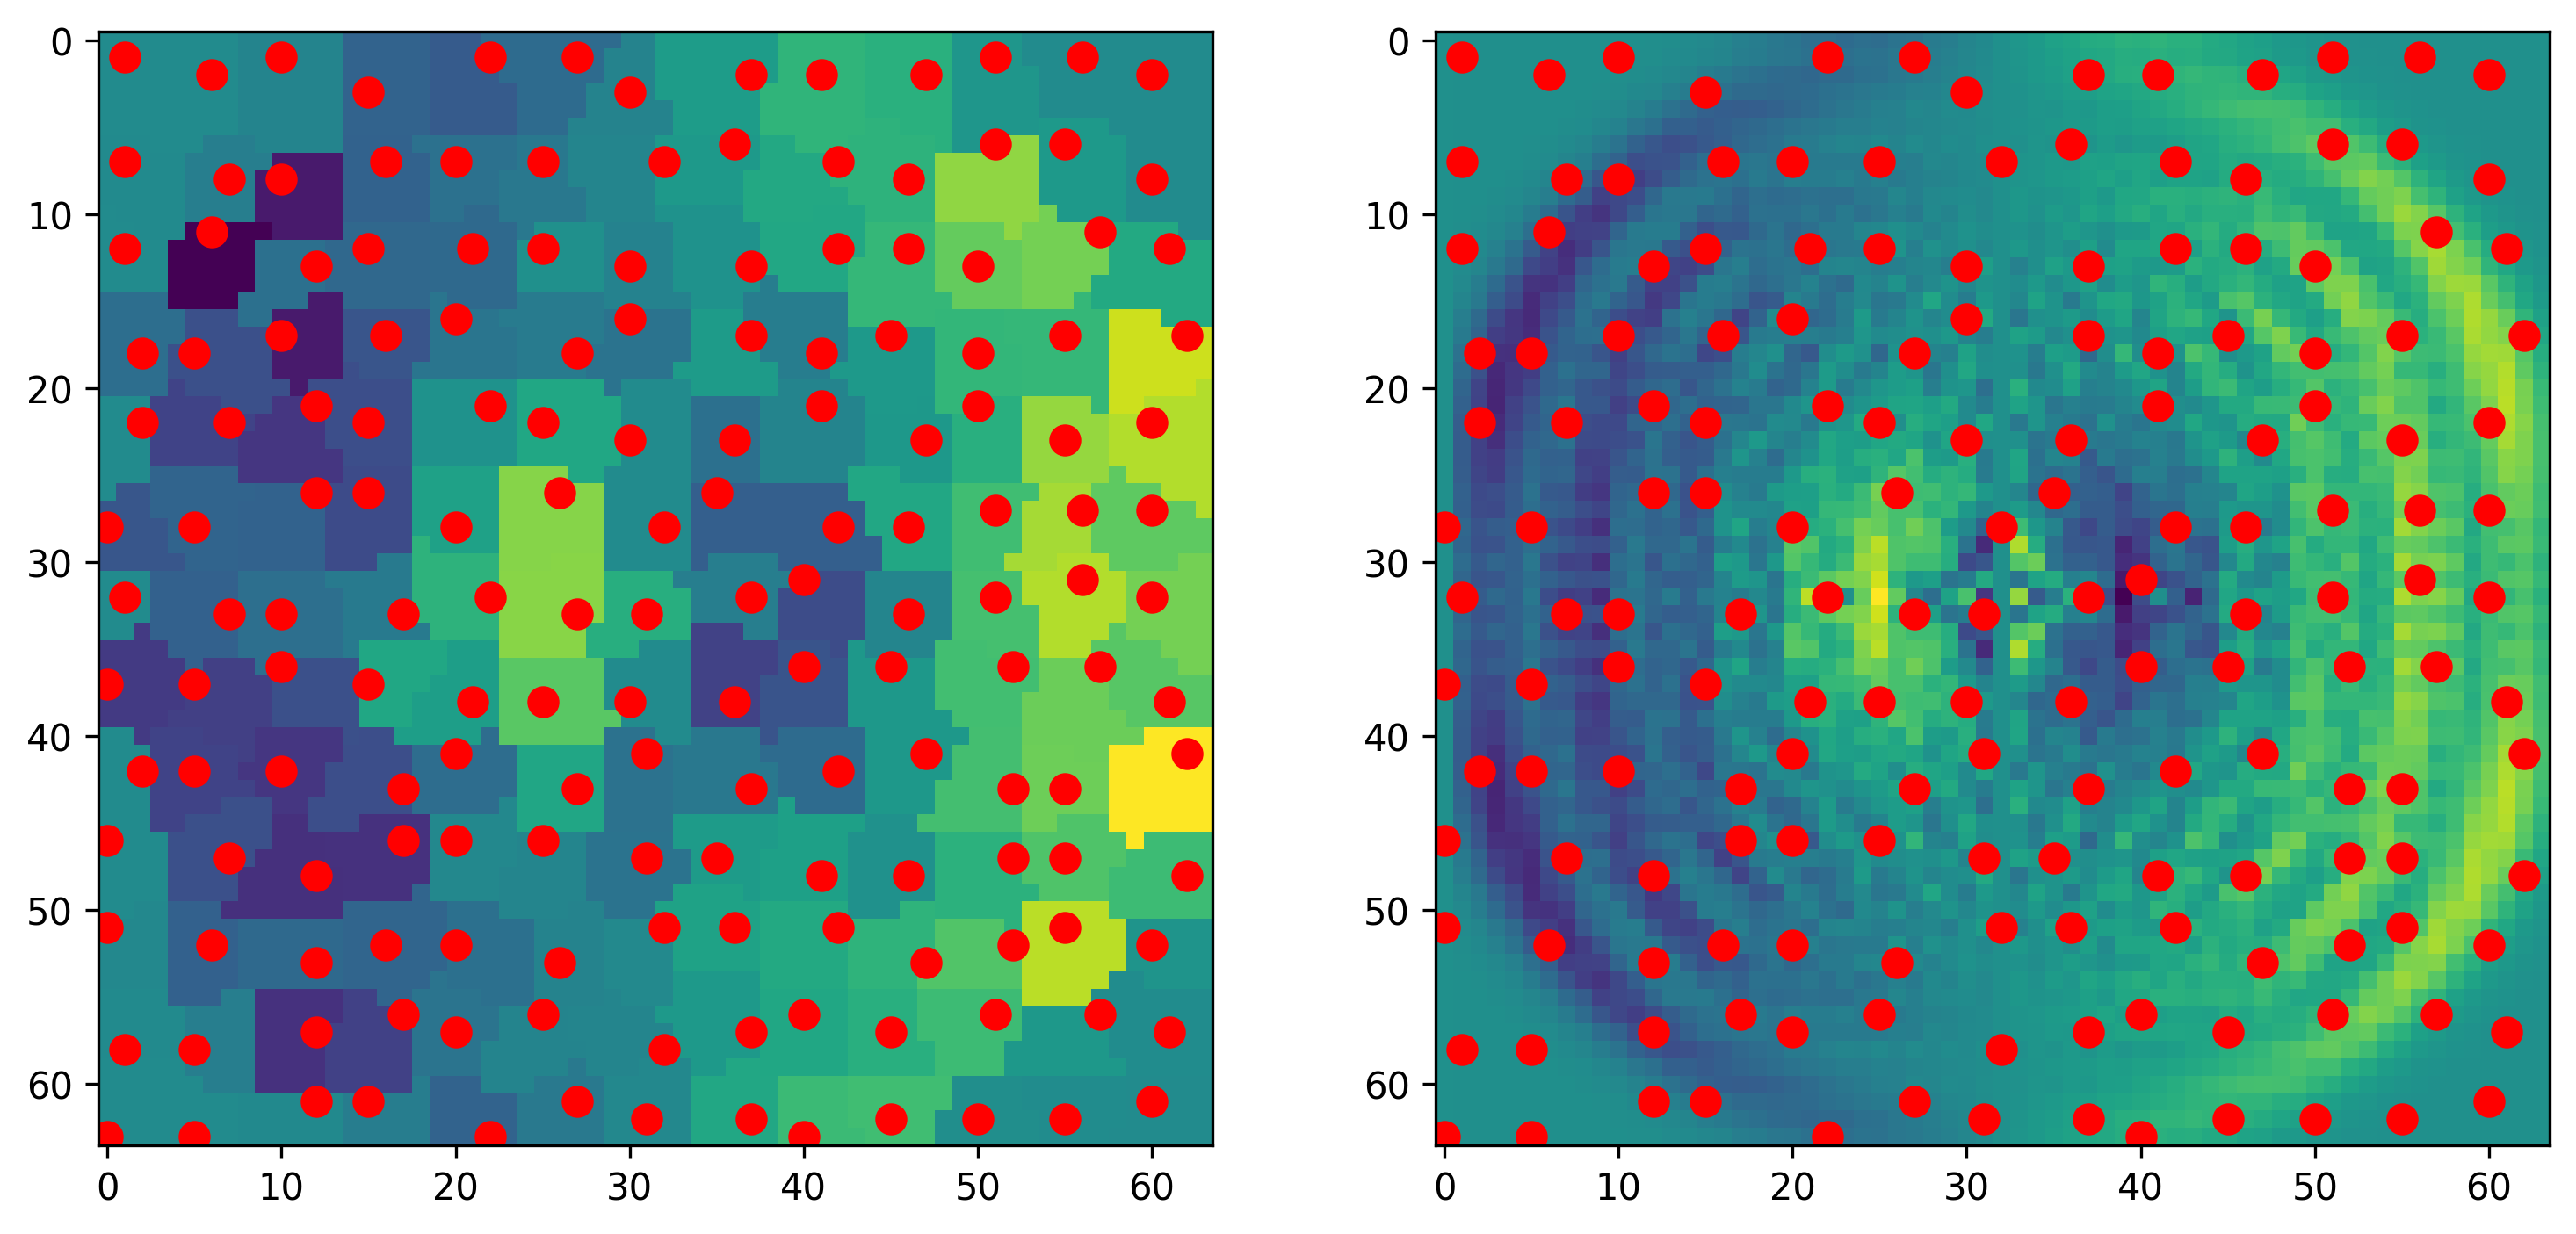

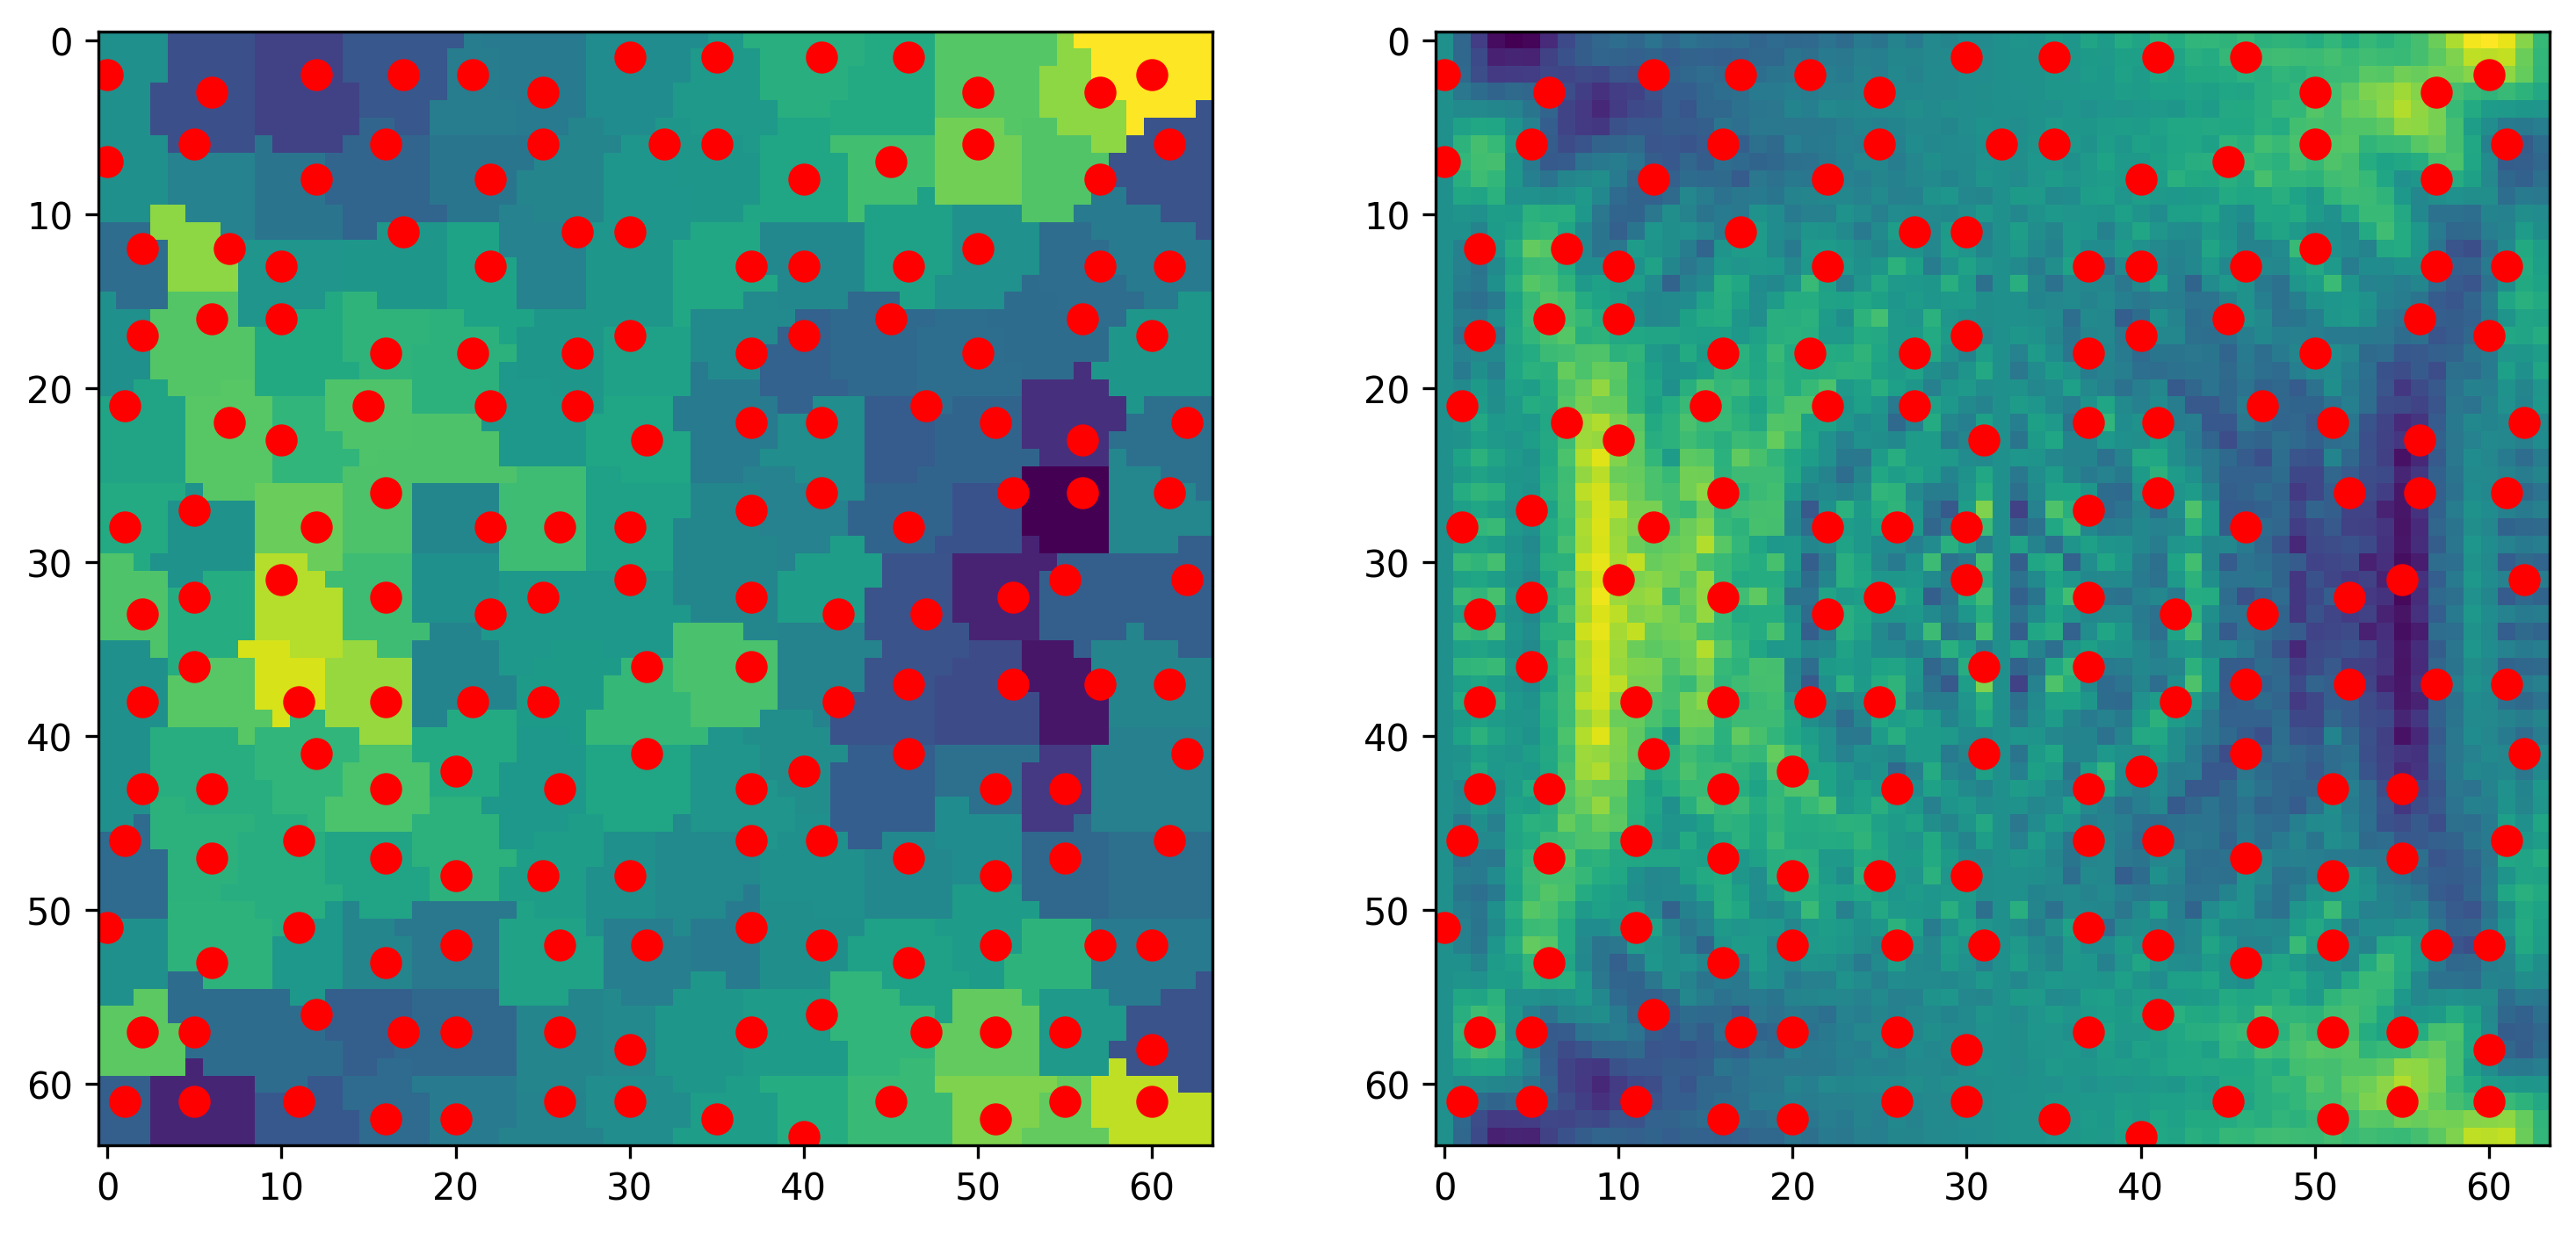

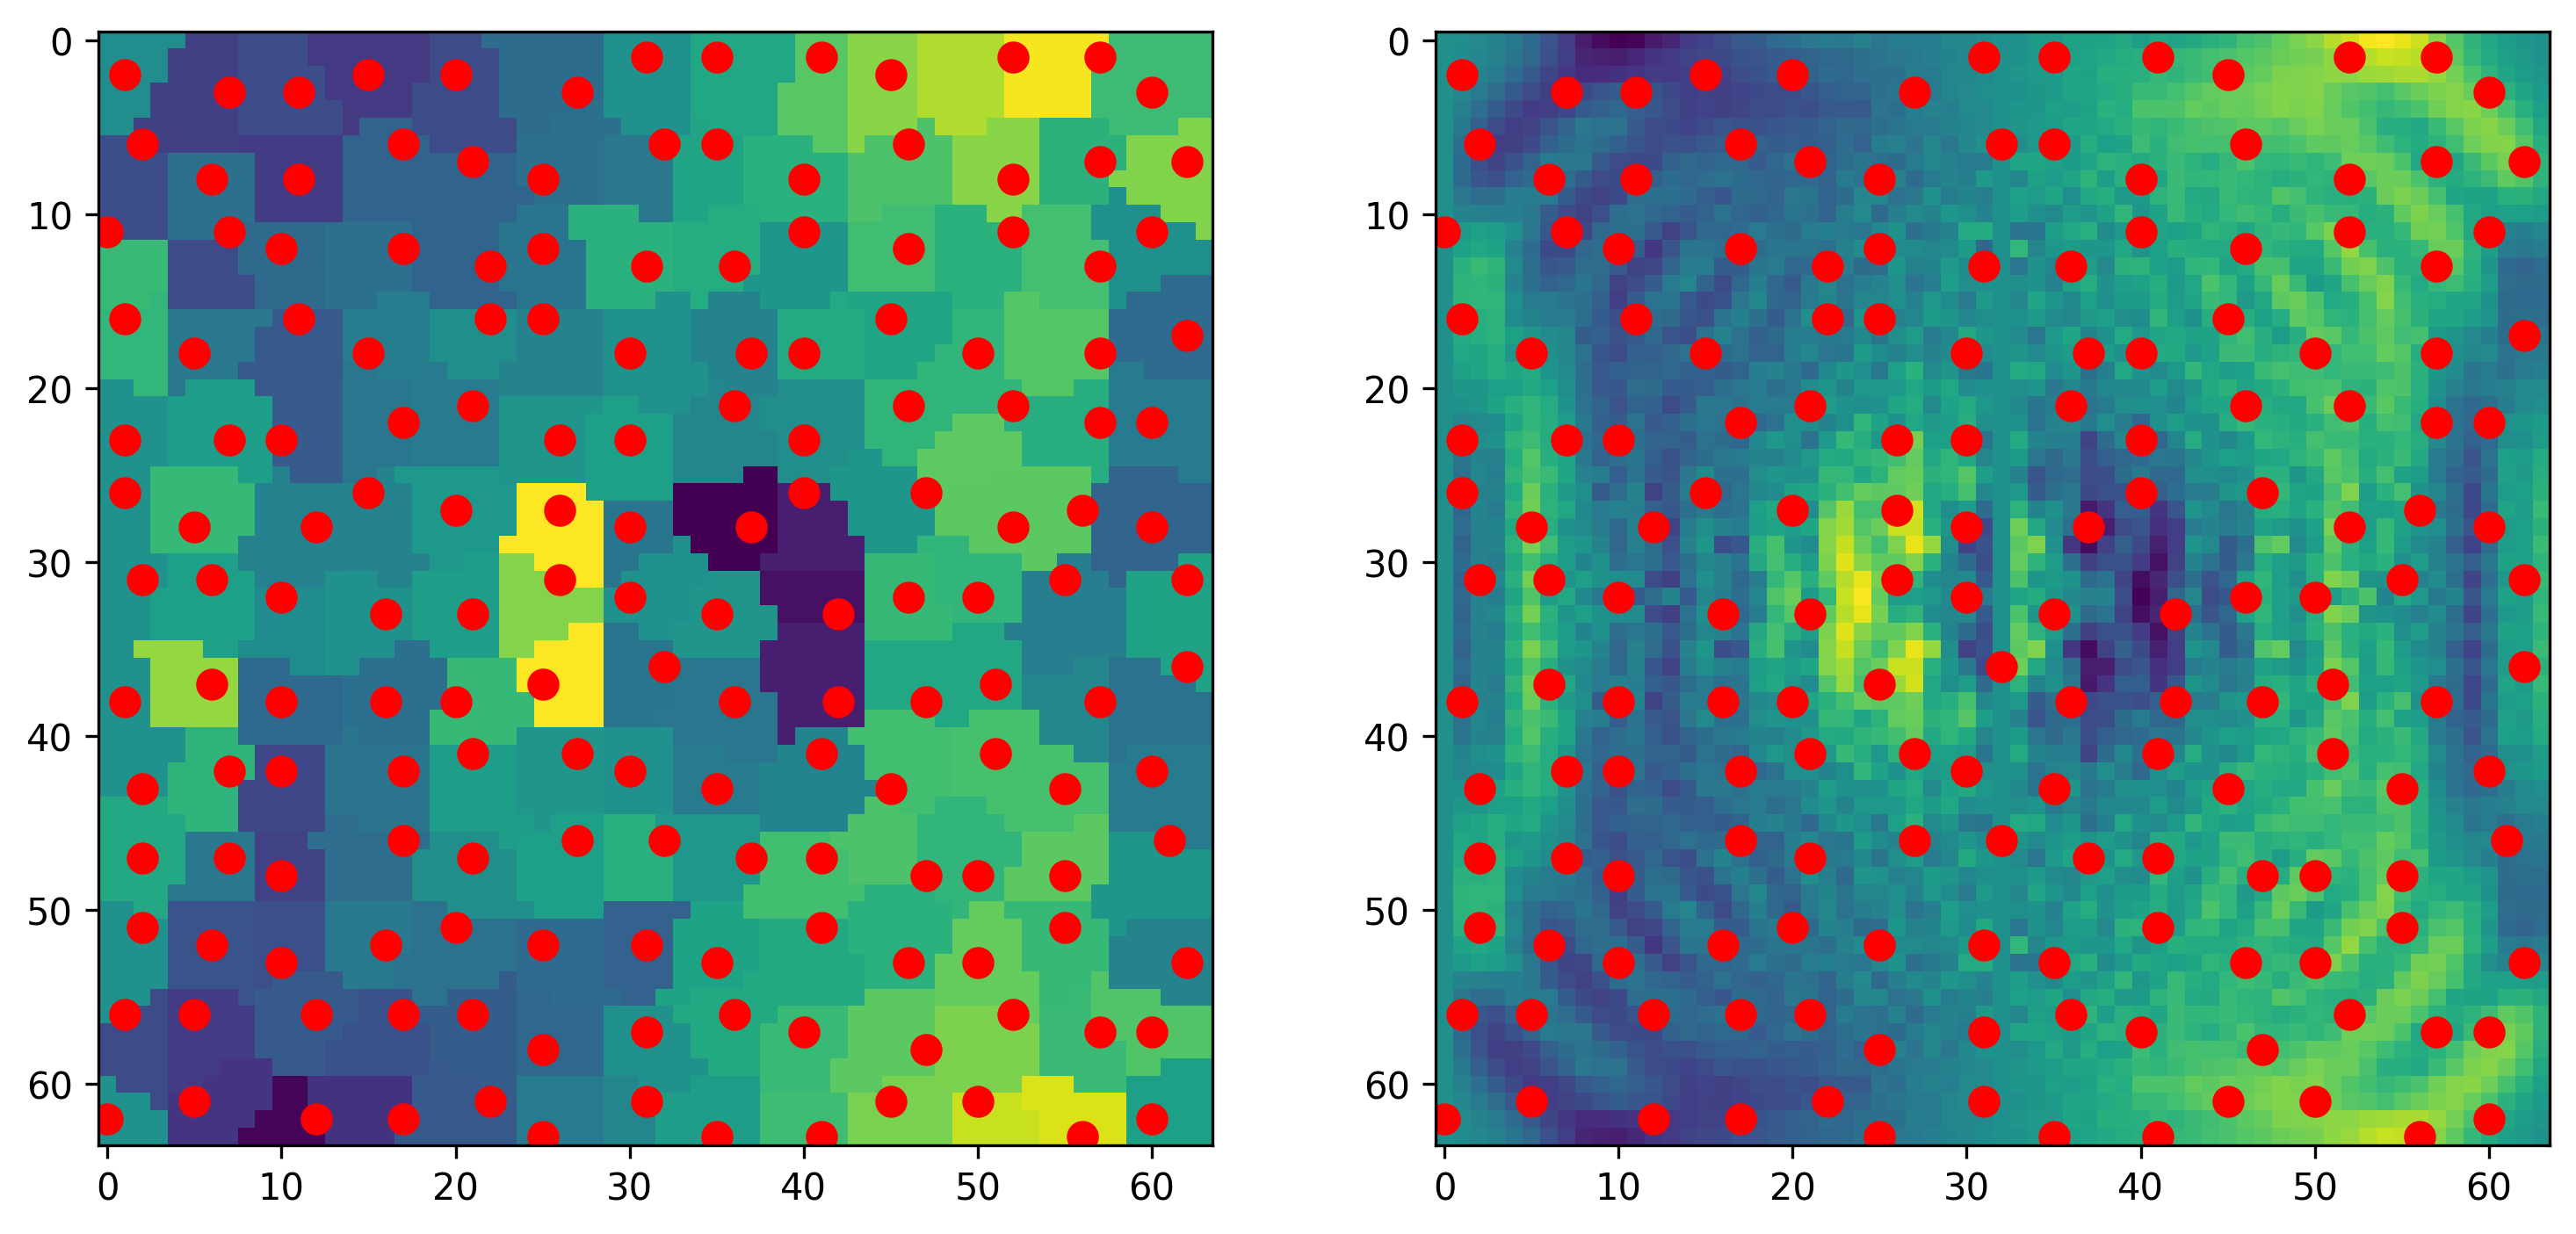

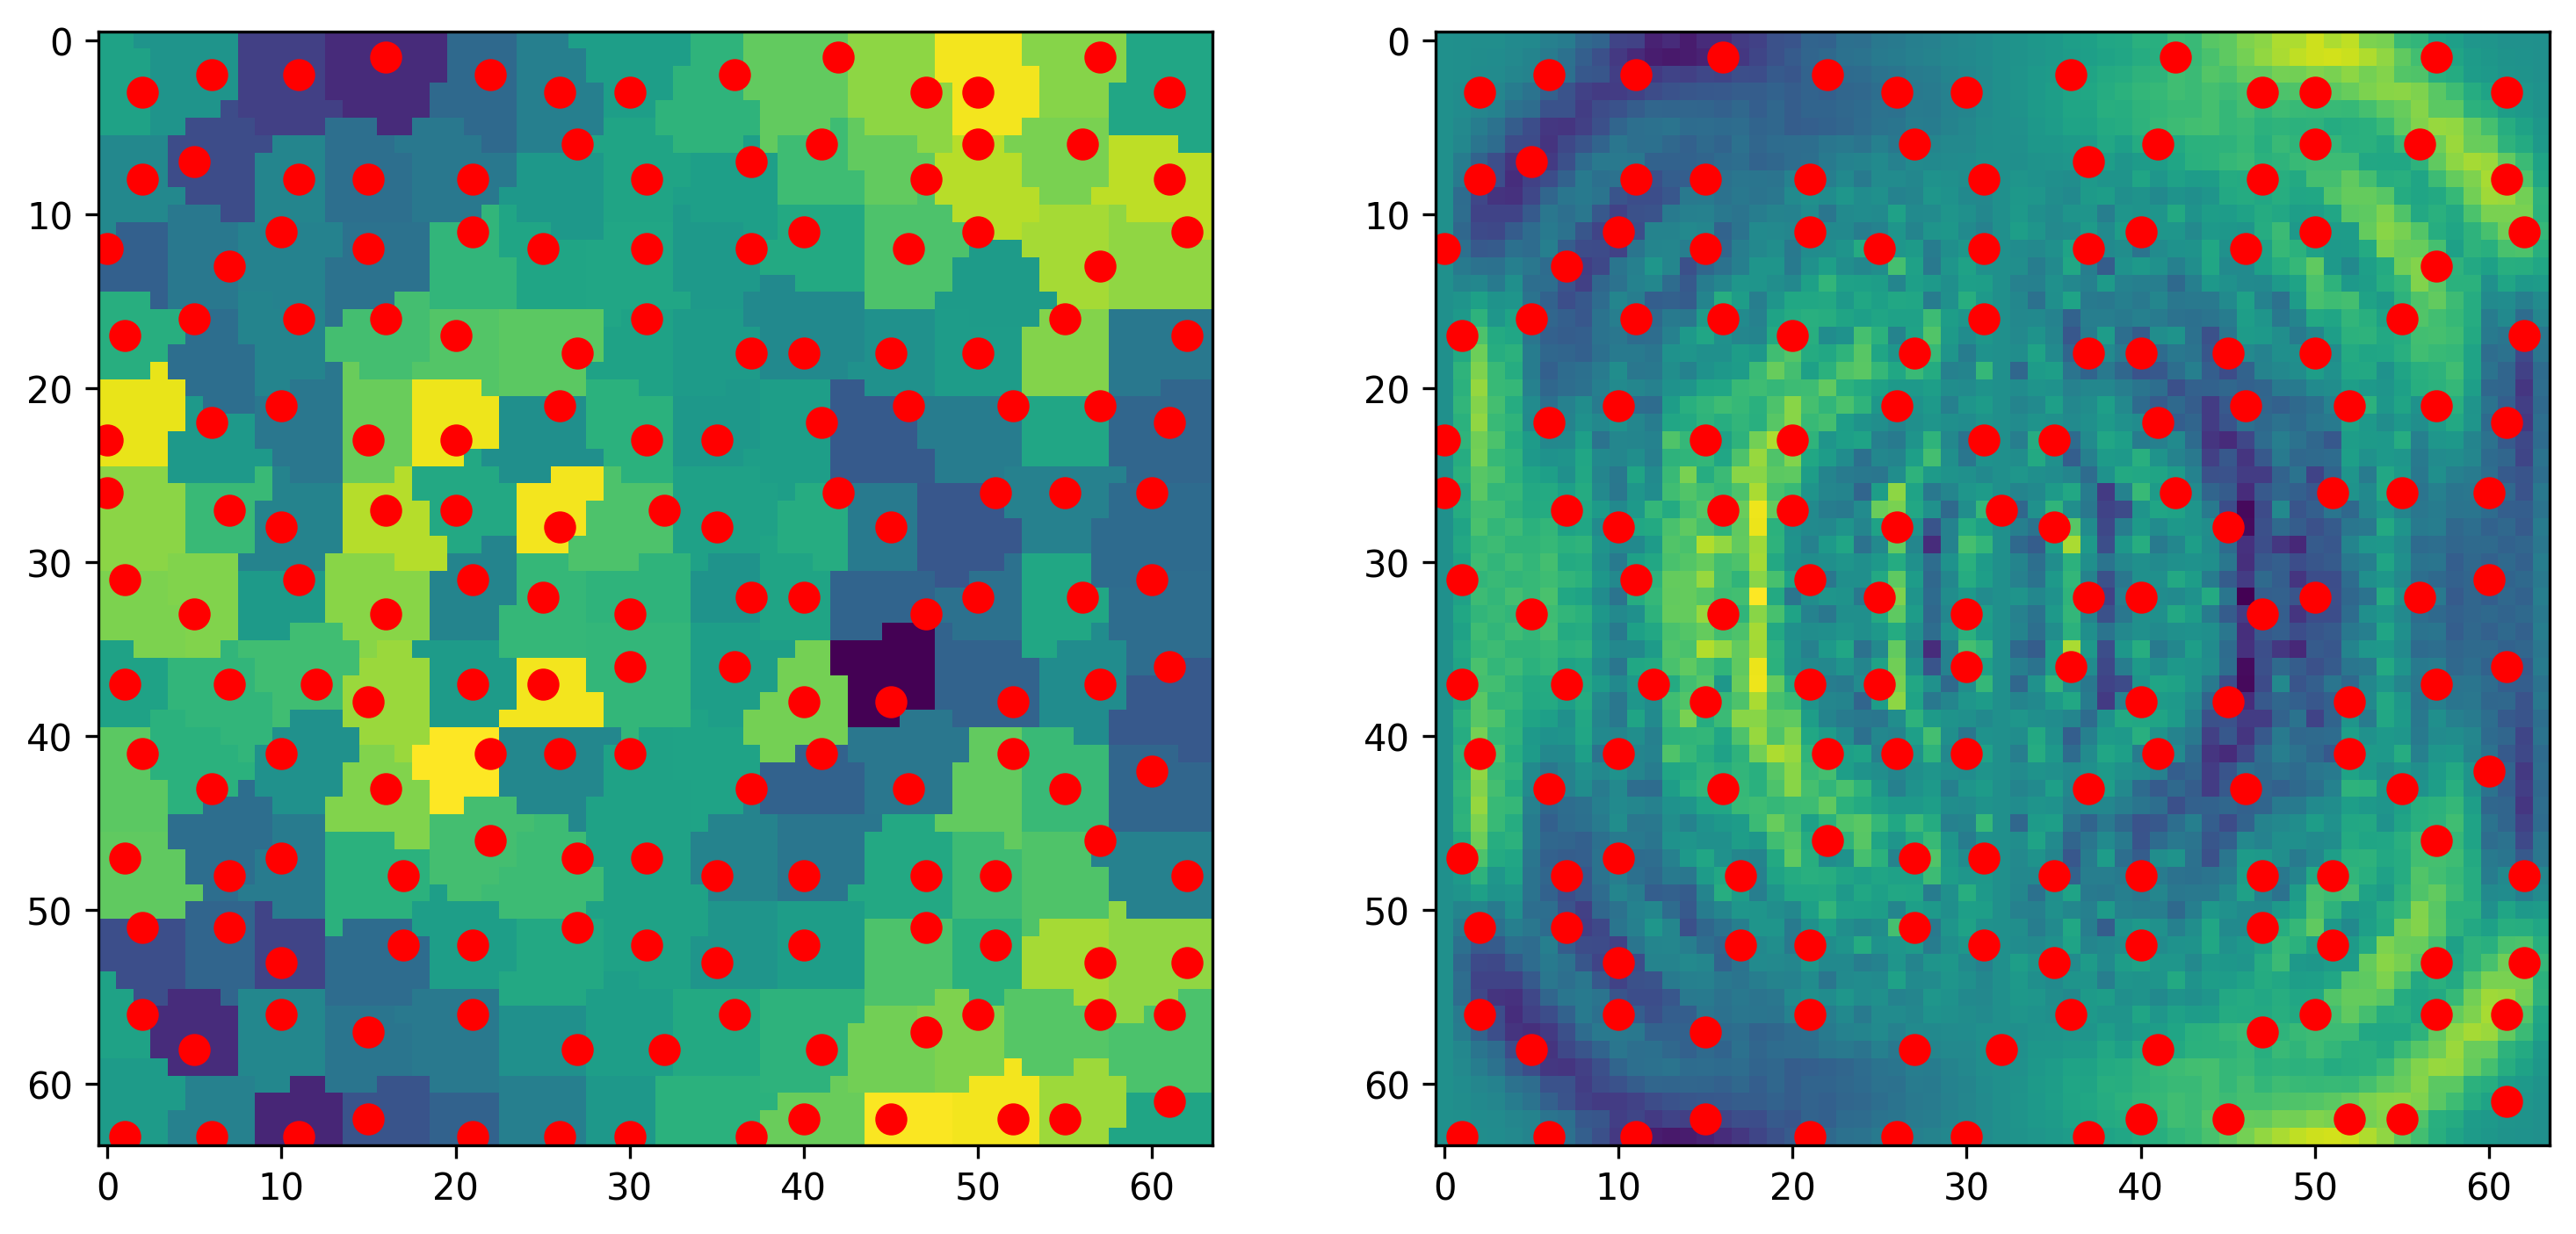

(45000, 64, 64)
(45000, 64, 64)


In [ ]:
import numpy as np
from scipy.interpolate import griddata

# Load data
true_u_vect = np.load('/content/drive/MyDrive/Physics/Physics/Dataset/true_u_full.npy', mmap_mode="r")
true_v_vect = np.load('/content/drive/MyDrive/Physics/Physics/Dataset/true_v_full.npy', mmap_mode="r")
true_h_vect = np.load('/content/drive/MyDrive/Physics/Physics/Dataset/true_h_full.npy', mmap_mode="r")

a = 300*150#(steps-blank_steps)/10 * num_random_tuples


# Constants
N = 64
datasize = int(a)  # Ensure 'a' is defined earlier in your code

# Initialize arrays
true_data = np.zeros((datasize, N, N, 3))  # Combining u, v, h data into one array for simplicity
vor_data = np.zeros((datasize, N, N, 3))

# Grid preparation
x, y = np.linspace(0., N, N), np.linspace(0., N, N)[::-1]
X, Y = np.meshgrid(x, y)
P = np.column_stack((X.flatten(), Y.flatten()))

# Define the indices where you want to plot the data
plot_indices = [160, 500, 830, 260]

# Data processing and conditional plotting
for index in range(datasize):
    for vect, slice_idx in zip([true_u_vect, true_v_vect, true_h_vect], range(3)):
        x_coord, y_coord = structure_obs(64, 2)
        Zi = vect[index, x_coord.astype(int), N-1-y_coord.astype(int)]
        Pi = np.column_stack((x_coord, y_coord))
        Z_nearest = griddata(Pi, Zi, P, method="nearest").reshape([N, N])
        vor_data[index, :, :, slice_idx] = Z_nearest
        true_data[index, :, :, slice_idx] = vect[index, :, :]

    # Conditional plotting for specified indices
    if index in plot_indices:
        fig, axs = plt.subplots(1, 2, figsize=(12, 6), dpi=300)

        # Plotting Voronoi "u" data
        axs[0].imshow(vor_data[index, :, :, 1])
        axs[0].scatter(x_coord, N - 1 - y_coord, c='red', s=60)

        # Plotting True "u" data
        axs[1].imshow(true_data[index, :, :, 0])
        axs[1].scatter(x_coord, N - 1 - y_coord, c='red', s=60)
        plt.show()
# Correcting the data swap issue
vor_u_data, vor_v_data = vor_data[..., 0], vor_data[..., 1]
vor_h_data, true_u_data = vor_data[..., 2], true_data[..., 0]
true_v_data, true_h_data = true_data[..., 1], true_data[..., 2]

print(true_u_data.shape)
print(true_u_vect.shape)
# Save data
np.save('/content/drive/MyDrive/Physics/Physics/Dataset/vor_u_full.npy', vor_u_data)
np.save('/content/drive/MyDrive/Physics/Physics/Dataset/vor_v_full.npy', vor_v_data)
np.save('/content/drive/MyDrive/Physics/Physics/Dataset/vor_h_full.npy', vor_h_data)


# Clean up
del vor_u_data, vor_v_data, vor_h_data, true_u_data, true_v_data, true_h_data
del true_u_vect, true_v_vect, true_h_vect


#### Origin

In [ ]:
true_u_vect = np.load('/content/true_u_vect.npy', mmap_mode="r")
true_v_vect = np.load('/content/true_v_vect.npy', mmap_mode="r")
true_h_vect = np.load('/content/true_h_vect.npy', mmap_mode="r")

N = 64
datasize = int(a)

true_u_data = np.zeros((datasize, N, N))
true_v_data = np.zeros((datasize, N, N))
true_h_data = np.zeros((datasize, N, N))

vor_u_data = np.zeros((datasize, N, N))
vor_v_data = np.zeros((datasize, N, N))
vor_h_data = np.zeros((datasize, N, N))

x = np.linspace(0., N, N)
y = np.linspace(0., N, N)[::-1]
X, Y = np.meshgrid(x, y)
P = np.column_stack((X.flatten(), Y.flatten()))

count = 0
for index in range(datasize):
    for repeat in range(1):
        u_t = true_u_vect[index, :, :]
        v_t = true_v_vect[index, :, :]
        h_t = true_h_vect[index, :, :]

        u_Zi = u_t[x_coord.astype(int), N-1-y_coord.astype(int)]
        v_Zi = v_t[x_coord.astype(int), N-1-y_coord.astype(int)]
        h_Zi = h_t[x_coord.astype(int), N-1-y_coord.astype(int)]

        Pi = np.column_stack((x_coord, y_coord))
        u_Z_nearest = griddata(Pi, u_Zi, P, method="nearest").reshape([N, N])
        v_Z_nearest = griddata(Pi, v_Zi, P, method="nearest").reshape([N, N])
        h_Z_nearest = griddata(Pi, h_Zi, P, method="nearest").reshape([N, N])

        vor_u_data[count, :, :] = u_Z_nearest
        vor_v_data[count, :, :] = v_Z_nearest
        vor_h_data[count, :, :] = h_Z_nearest

        true_u_data[count, :, :] = u_t
        true_v_data[count, :, :] = v_t
        true_h_data[count, :, :] = h_t

        count += 1

vor_u = vor_u_data
vor_u_data = vor_v_data
vor_v_data = vor_u



np.save('/content/vor_u_data.npy',vor_u_data)
np.save('/content/vor_v_data.npy',vor_v_data)
np.save('/content/vor_h_data.npy',vor_h_data)
np.save('/content/true_u_data.npy',true_u_data)
np.save('/content/true_v_data.npy',true_v_data)
np.save('/content/true_h_data.npy',true_h_data)
del vor_u_data,vor_v_data,vor_h_data,true_u_data,true_v_data, true_h_data,true_u_vect,true_v_vect,true_h_vect


FileNotFoundError: [Errno 2] No such file or directory: '/content/true_u_vect.npy'

#

In [ ]:
vor_u_data = np.load('/content/drive/MyDrive/Physics/Physics/Dataset/vor_u_full.npy', mmap_mode="r")
vor_v_data = np.load('/content/drive/MyDrive/Physics/Physics/Dataset/vor_v_full.npy', mmap_mode="r")
vor_h_data = np.load('/content/drive/MyDrive/Physics/Physics/Dataset/vor_h_full.npy', mmap_mode="r")
true_v_data = np.load('/content/drive/MyDrive/Physics/Physics/Dataset/true_v_full.npy', mmap_mode="r")
true_u_data = np.load('/content/drive/MyDrive/Physics/Physics/Dataset/true_u_full.npy', mmap_mode="r")
true_h_data = np.load('/content/drive/MyDrive/Physics/Physics/Dataset/true_h_full.npy', mmap_mode="r")


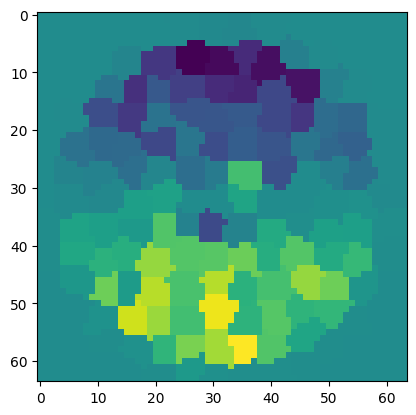

In [ ]:
plt.imshow(vor_u_data[100,:,:])

#### CAE+LSTM Datasets Creation

In [ ]:
datasize = 300*150
# Create train and test indices
train_rate = 0.90
train_index = np.arange(0, int(datasize * train_rate))
test_index = np.arange(train_index[-1] + 1, datasize)

# Data categories
data_types = ['u', 'v', 'h']
vor_data = [vor_u_data, vor_v_data,vor_h_data]
true_data = [true_v_data,true_u_data,true_h_data]

# Initialize lists to store the split datasets
vor_train, vor_test, true_train, true_test = [], [], [], []

# Processing loop
for vor, true in zip(vor_data, true_data):
    # Split vor data
    vor_train.append(vor[train_index])
    vor_test.append(vor[test_index])

    # Split true data
    true_train.append(true[train_index])
    true_test.append(true[test_index])

# Final concatenation
vor_train = np.stack(vor_train, axis=-1)
true_train = np.stack(true_train, axis=-1)
vor_test = np.stack(vor_test, axis=-1)
true_test = np.stack(true_test, axis=-1)



In [ ]:
import os

# Directory to save the files
save_dir = '/content/drive/MyDrive/Physics/Physics/Dataset'

# Create the directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)

# Save the arrays
np.save(os.path.join(save_dir, 'vor_train.npy'), vor_train)
np.save(os.path.join(save_dir, 'true_train.npy'), true_train)
np.save(os.path.join(save_dir, 'vor_test.npy'), vor_test)
np.save(os.path.join(save_dir, 'true_test.npy'), true_test)

del vor_train,true_train,vor_test,true_test


#### ConvLSTM Dataset Creation

In [ ]:
# Assuming 'datasize' is defined earlier in your code
datasize = len(vor_u_data)  # Example, adjust according to your data

# Create train and test indices
train_index = np.arange(0, int(datasize * 0.9))
test_index = np.arange(train_index[-1] + 1, datasize)
'''
def normalize_and_index(data, index):
    data_min, data_max = np.min(data), np.max(data)
    data_norm = (data - data_min) / (data_max - data_min)
    data_indexed = data_norm[index]
    return data_indexed, data_max - data_min, data_min

def split_normalize_concatenate(data, train_index, test_index):
    train_data, range_train, min_train = normalize_and_index(data, train_index)
    test_data, range_test, min_test = normalize_and_index(data, test_index)
    return train_data, test_data, (range_train, min_train), (range_test, min_test)


'''
# Data categories
data_types = ['u', 'v', 'h']
vor_data = [vor_u_data, vor_v_data, vor_h_data]
true_data = [true_u_data, true_v_data, true_h_data]

# Initialize lists to store results
vor_train, vor_test, true_train, true_test = [], [], [], []
ranges_mins = {'vor': {'train': [], 'test': []}, 'true': {'train': [], 'test': []}}

# Processing loop
for data_type, vor, true in zip(data_types, vor_data, true_data):
    vor_train_dt, vor_test_dt, rm_train, rm_test = split_normalize_concatenate(vor, train_index, test_index)
    vor_train.append(vor_train_dt)
    vor_test.append(vor_test_dt)
    ranges_mins['vor']['train'].append(rm_train)
    ranges_mins['vor']['test'].append(rm_test)

    true_train_dt, true_test_dt, rm_train, rm_test = split_normalize_concatenate(true, train_index, test_index)
    true_train.append(true_train_dt)
    true_test.append(true_test_dt)
    ranges_mins['true']['train'].append(rm_train)
    ranges_mins['true']['test'].append(rm_test)

# Final concatenation
vor_train = np.stack(vor_train, axis=-1)
true_train = np.stack(true_train, axis=-1)
vor_test = np.stack(vor_test, axis=-1)
true_test = np.stack(true_test, axis=-1)


FileNotFoundError: [Errno 2] No such file or directory: '/content/0121/vor_u_full.npy'

In [ ]:
# Assuming 'datasize' is defined earlier in your code
datasize = len(vor_u_data)  # Example, adjust according to your data

# Create train and test indices
train_index = np.arange(0, int(datasize * 0.9))
test_index = np.arange(train_index[-1] + 1, datasize)

# Function to index data
def index_data(data, index):
    return data[index]

# Data categories
data_types = ['u', 'v', 'h']
vor_data = [vor_u_data, vor_v_data, vor_h_data]
true_data = [true_u_data, true_v_data, true_h_data]

# Initialize lists to store split data
vor_train, vor_test, true_train, true_test = [], [], [], []

# Splitting and indexing loop
for vor, true in zip(vor_data, true_data):
    # Split Vor data
    vor_train.append(index_data(vor, train_index))
    vor_test.append(index_data(vor, test_index))

    # Split True data
    true_train.append(index_data(true, train_index))
    true_test.append(index_data(true, test_index))

# Concatenation for model input/output format
vor_train = np.stack(vor_train, axis=-1)
true_train = np.stack(true_train, axis=-1)
vor_test = np.stack(vor_test, axis=-1)
true_test = np.stack(true_test, axis=-1)


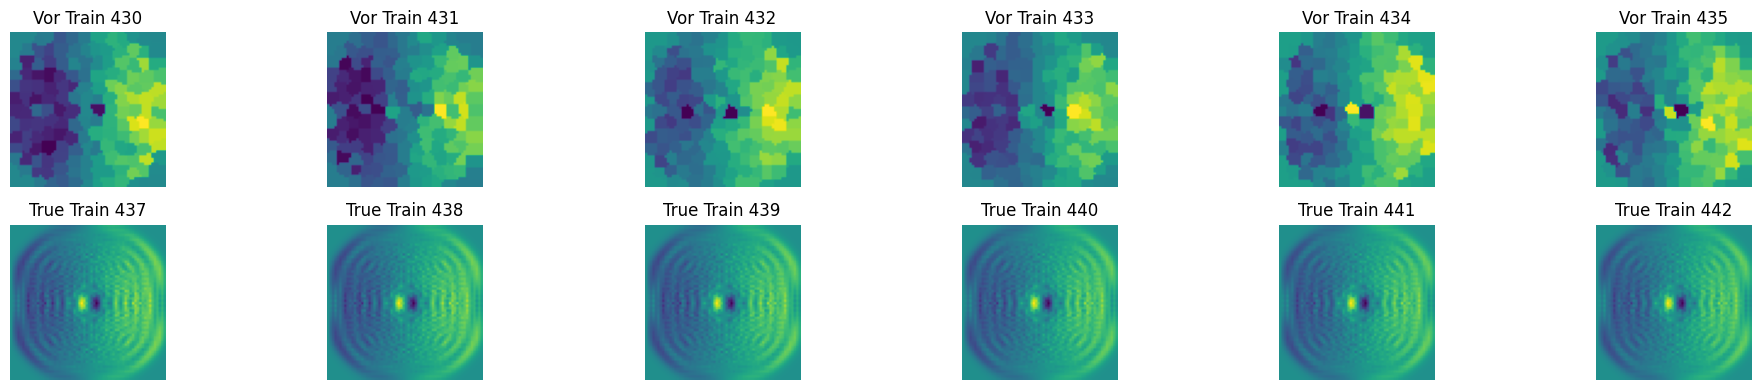

In [ ]:
'''vor_train = np.load('/content/drive/MyDrive/Physics/Physics/Dataset/vor_train_convlstm.npy')
true_train = np.load('/content/drive/MyDrive/Physics/Physics/Dataset/true_train_convlstm.npy')
vor_test = np.load('/content/drive/MyDrive/Physics/Physics/Dataset/vor_test_convlstm.npy')
true_test = np.load('/content/drive/MyDrive/Physics/Physics/Dataset/true_test_convlstm.npy')'''
# Define the start and end indices for vor_train and true_train sequences
start_vor = 100+30+300
end_vor = 106+30+300  # Python slices are exclusive at the end, so 106 includes up to 105
start_true = 107+30+300
end_true = 113+30+300  # Includes up to 112

# Set up the matplotlib figure and axes
fig, axes = plt.subplots(nrows=2, ncols=end_vor - start_vor, figsize=(20, 4))  # Adjust figsize as needed

# Plot vor_train sequence
for i, idx in enumerate(range(start_vor, end_vor)):
    axes[0, i].imshow(vor_train[idx, :, :, 1], cmap='viridis')  # Assuming the last dimension is channels and we're interested in the first channel
    axes[0, i].set_title(f'Vor Train {idx}')
    axes[0, i].axis('off')  # Hide the axes

# Plot true_train sequence
for i, idx in enumerate(range(start_true, end_true)):
    axes[1, i].imshow(true_train[idx, :, :, 0], cmap='viridis')  # Same assumption as above
    axes[1, i].set_title(f'True Train {idx}')
    axes[1, i].axis('off')  # Hide the axes

plt.tight_layout()
plt.show()


In [ ]:
n_frames = 6

# Load the saved datasets
vor_train = np.load('/content/drive/MyDrive/Physics/Physics/Dataset/vor_train_convlstm.npy')
true_train = np.load('/content/drive/MyDrive/Physics/Physics/Dataset/true_train_convlstm.npy')
vor_test = np.load('/content/drive/MyDrive/Physics/Physics/Dataset/vor_test_convlstm.npy')
true_test = np.load('/content/drive/MyDrive/Physics/Physics/Dataset/true_test_convlstm.npy')

def create_sequences(data, sequence_length):
    return np.array([data[i:i+sequence_length] for i in range(len(data) - sequence_length + 1)])

def create_shifted_frames(vor, true, n_frames):
    return vor[:-n_frames], true[n_frames:]

# Apply the sequence and shifting process
x_train_convlstm, y_train_convlstm = create_shifted_frames(create_sequences(vor_train, n_frames), create_sequences(true_train, n_frames), n_frames)

np.save('/content/drive/MyDrive/Physics/Physics/Dataset/x_train_convlstm.npy', x_train_convlstm)
np.save('/content/drive/MyDrive/Physics/Physics/Dataset/y_train_convlstm.npy', y_train_convlstm)

del x_train_convlstm, y_train_convlstm
x_val_convlstm, y_val_convlstm = create_shifted_frames(create_sequences(vor_test, n_frames), create_sequences(true_test, n_frames), n_frames)

# Corrected print statement to display the shape of y_train_convlstm
print(y_train_convlstm.shape)

In [ ]:
# Assuming 'datasize' is defined earlier in your code
datasize = len(vor_u_data)  # Example, adjust according to your data

# Create train and test indices
train_index = np.arange(0, int(datasize * 0.9))
test_index = np.arange(train_index[-1] + 1, datasize)

# Function to index data
def index_data(data, index):
    return data[index]

# Data categories
data_types = ['u', 'v', 'h']
vor_data = [vor_u_data, vor_v_data, vor_h_data]
true_data = [true_u_data, true_v_data, true_h_data]

# Initialize lists to store split data
vor_train, vor_test, true_train, true_test = [], [], [], []

# Splitting and indexing loop
for vor, true in zip(vor_data, true_data):
    # Split Vor data
    vor_train.append(index_data(vor, train_index))
    vor_test.append(index_data(vor, test_index))

    # Split True data
    true_train.append(index_data(true, train_index))
    true_test.append(index_data(true, test_index))

# Concatenation for model input/output format
vor_train = np.stack(vor_train, axis=-1)
true_train = np.stack(true_train, axis=-1)
vor_test = np.stack(vor_test, axis=-1)
true_test = np.stack(true_test, axis=-1)


In [ ]:
# Assuming 'datasize' is defined earlier in your code
datasize = len(vor_u_data)  # Example, adjust according to your data

# Create train and test indices
train_index = np.arange(0, int(datasize * 0.9))
test_index = np.arange(train_index[-1] + 1, datasize)

# Function to index data
def index_data(data, index):
    return data[index]

# Data categories
data_types = ['u', 'v', 'h']
vor_data = [vor_u_data, vor_v_data, vor_h_data]
true_data = [true_u_data, true_v_data, true_h_data]

# Initialize lists to store split data
vor_train, vor_test, true_train, true_test = [], [], [], []

# Splitting and indexing loop
for vor, true in zip(vor_data, true_data):
    # Split Vor data
    vor_train.append(index_data(vor, train_index))
    vor_test.append(index_data(vor, test_index))

    # Split True data
    true_train.append(index_data(true, train_index))
    true_test.append(index_data(true, test_index))

# Concatenation for model input/output format
vor_train = np.stack(vor_train, axis=-1)
true_train = np.stack(true_train, axis=-1)
vor_test = np.stack(vor_test, axis=-1)
true_test = np.stack(true_test, axis=-1)


In [ ]:
np.save('/content/drive/MyDrive/Physics/Physics/Dataset/vor_train_convlstm.npy',vor_train)
np.save('/content/drive/MyDrive/Physics/Physics/Dataset/true_train_convlstm.npy',true_train)
np.save('/content/drive/MyDrive/Physics/Physics/Dataset/vor_test_convlstm.npy',vor_test)
np.save('/content/drive/MyDrive/Physics/Physics/Dataset/true_test_convlstm.npy',true_test)

In [ ]:

# Load the saved datasets
vor_train = np.load('/content/drive/MyDrive/Physics/Physics/Dataset/vor_train_convlstm.npy')
true_train = np.load('/content/drive/MyDrive/Physics/Physics/Dataset/true_train_convlstm.npy')
vor_test = np.load('/content/drive/MyDrive/Physics/Physics/Dataset/vor_test_convlstm.npy')
true_test = np.load('/content/drive/MyDrive/Physics/Physics/Dataset/true_test_convlstm.npy')


In [ ]:
vor_train.shape

(40500, 64, 64, 3)

IndexError: too many indices for array: array is 4-dimensional, but 5 were indexed

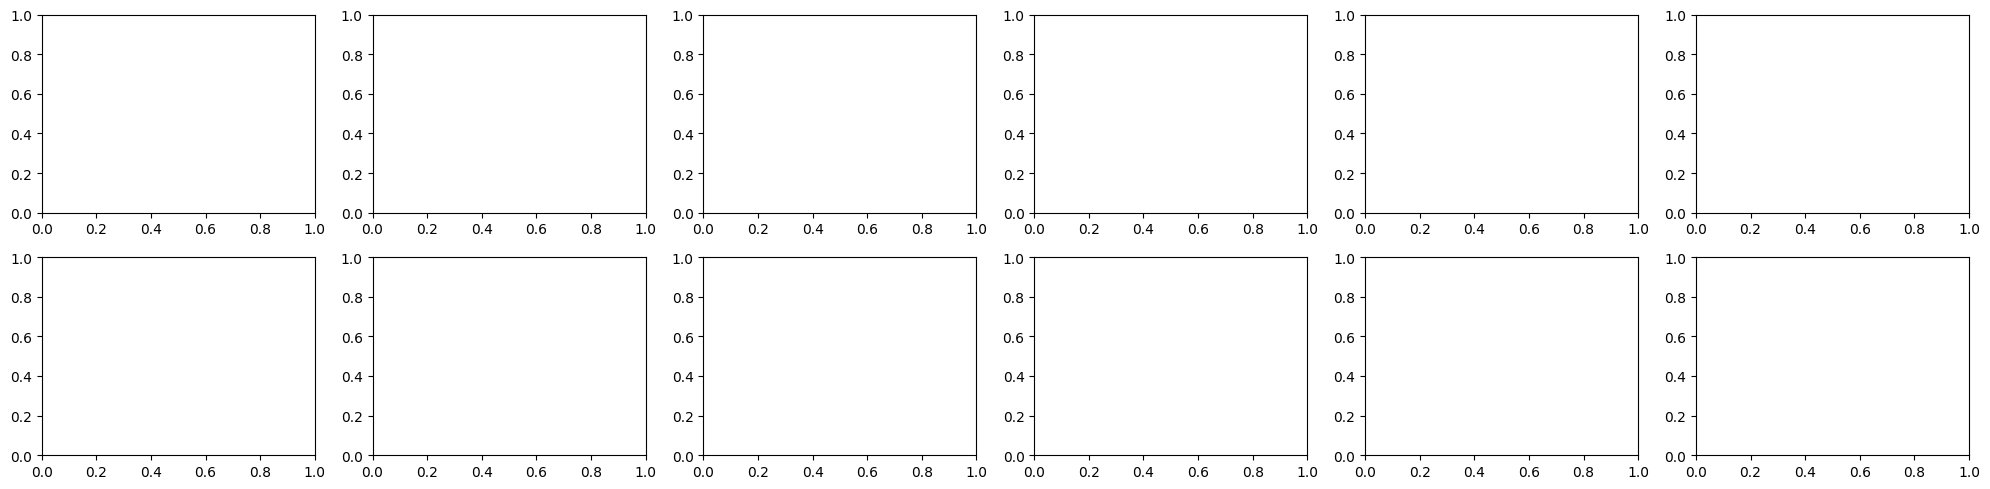

In [ ]:
import matplotlib.pyplot as plt

# Selecting a specific example from your dataset
example_index = 100

# Number of steps you want to plot
steps = range(6)  # This will plot steps 0, 1, 2, ..., 6

# Set up the figure and axes for a grid of plots
fig, axes = plt.subplots(nrows=2, ncols=len(steps), figsize=(20, 5))  # Adjust figsize as needed

# Adjust the layout
plt.tight_layout()

# Plotting loop
for i, step in enumerate(steps):
    # Voronoi tessellation input plots
    ax = axes[0, i]
    ax.imshow(vor_train[example_index, step, :, :, 0], cmap='viridis')  # Using cmap='viridis' for visualization
    ax.set_title(f'Vor Step {step}')
    ax.axis('off')  # Hide axes for clarity

    # Corresponding true state output plots
    ax = axes[1, i]
    ax.imshow(true_train[example_index, step, :, :, 0], cmap='viridis')  # Assuming channel 0 for visualization
    ax.set_title(f'True Step {step}')
    ax.axis('off')  # Hide axes for clarity

# Show plot
plt.show()


In [ ]:
'''del vor_train,true_train,vor_test,true_test'''

# CNN

## 0331

In [ ]:
vor_train = np.load('/content/vor_train.npy', mmap_mode="r")
true_train = np.load('/content/true_train.npy', mmap_mode="r")
vor_test = np.load('/content/vor_test.npy', mmap_mode="r")
true_test = np.load('/content/true_test.npy', mmap_mode="r")


(array([[ 0.,  0.,  0.,  0.,  0., 64.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0., 31., 33.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0., 33., 31.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0., 35., 29.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0., 37., 27.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0., 39., 25.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0., 43., 21.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0., 45., 19.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0., 47., 17.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0., 49., 15.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0., 51., 13.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0., 51., 13.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0., 53., 11.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  3., 52.,  9.,  0.,  0.,  0.,  0.],
        [ 0.,  7.,  4.,  4., 42.,  7.,  0.,  0.,  0.,  0.],
        [ 0., 11.,  4.,  4., 40.,  5.,  0.,  0.,  0.,  0.],
        [ 5., 12.,  2.,  2., 40.,  3.,  

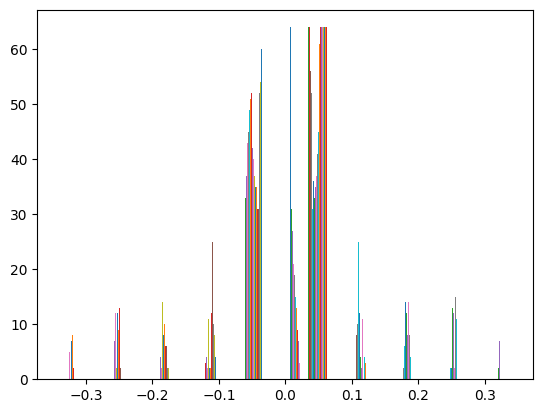

In [ ]:
plt.hist(true_train[1,:,:,0])

In [ ]:
from tensorflow.keras.layers import Input, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
input_img = Input(shape=(64,64,3))
x = Conv2D(48, (7,7),activation='relu', padding='same')(input_img)
x = Conv2D(48, (7,7),activation='relu', padding='same')(x)
x = Conv2D(48, (7,7),activation='relu', padding='same')(x)
x = Conv2D(48, (7,7),activation='relu', padding='same')(x)
x = Conv2D(48, (7,7),activation='relu', padding='same')(x)
x = Conv2D(48, (7,7),activation='relu', padding='same')(x)
x = Conv2D(48, (7,7),activation='relu', padding='same')(x)
x_final = Conv2D(3, (7,7), padding='same')(x)
model = Model(input_img, x_final)
model.compile(optimizer='adam', loss='mse')


from keras.callbacks import ModelCheckpoint,EarlyStopping
model_cb=ModelCheckpoint('./Model_NOAA.hdf5', monitor='val_loss',save_best_only=True,verbose=1)
early_cb=EarlyStopping(monitor='val_loss', patience=100,verbose=1)
cb = [model_cb, early_cb]
history = model.fit(vor_train,true_train,epochs=5000,batch_size=32,verbose=1,callbacks=cb,shuffle=True,validation_data=[vor_test, true_test])

Epoch 1/5000
149/150 [============================>.] - ETA: 0s - loss: 0.6817
Epoch 1: val_loss improved from inf to 0.00624, saving model to ./Model_NOAA.hdf5
150/150 [==============================] - 17s 44ms/step - loss: 0.6772 - val_loss: 0.0062
Epoch 2/5000
  3/150 [..............................] - ETA: 5s - loss: 0.0056

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


149/150 [============================>.] - ETA: 0s - loss: 0.0049
Epoch 2: val_loss improved from 0.00624 to 0.00590, saving model to ./Model_NOAA.hdf5
150/150 [==============================] - 6s 38ms/step - loss: 0.0050 - val_loss: 0.0059
Epoch 3/5000
149/150 [============================>.] - ETA: 0s - loss: 0.0046
Epoch 3: val_loss improved from 0.00590 to 0.00556, saving model to ./Model_NOAA.hdf5
150/150 [==============================] - 6s 38ms/step - loss: 0.0046 - val_loss: 0.0056
Epoch 4/5000
149/150 [============================>.] - ETA: 0s - loss: 0.0044
Epoch 4: val_loss improved from 0.00556 to 0.00431, saving model to ./Model_NOAA.hdf5
150/150 [==============================] - 6s 39ms/step - loss: 0.0044 - val_loss: 0.0043
Epoch 5/5000
149/150 [============================>.] - ETA: 0s - loss: 0.0029
Epoch 5: val_loss improved from 0.00431 to 0.00268, saving model to ./Model_NOAA.hdf5
150/150 [==============================] - 6s 38ms/step - loss: 0.0029 - val_loss: 

In [ ]:
model = tf.keras.models.load_model('/content/Model_NOAA.hdf5')

In [ ]:
# Calculate inference time
start_time = time.time()
res_orign = model.predict(vor_test)
inference_time = time.time() - start_time
y_true = true_test
# Calculate SSIM

ssim_score = ssim(y_true, res_orign, multichannel=True)
res_orig_flat = res_orign.flatten()
y_true_flat = y_true.flatten()

mse_orig = mean_squared_error(res_orig_flat, y_true_flat)
rrmse = np.sqrt(mse_orig) / np.mean(y_true)




print("SSIM:", ssim_score)
print("RRMSE:", rrmse)
print("MSE_orig:", mse_orig)
print("Inference Time:", inference_time)

In [ ]:
n = 10
vor_train_dataset = np.array([vor_train[i:i+n,:,:,:] for i in range(len(vor_train)-n)]).astype('float16')
true_train_dataset = np.array([true_train[j:j+n,:,:,:] for j in range(len(true_train)-n)]).astype('float16')
vor_test_dataset = np.array([vor_test[i:i+n,:,:,:] for i in range(len(vor_test)-n)]).astype('float16')
true_test_dataset = np.array([true_test[j:j+n,:,:,:] for j in range(len(true_test)-n)]).astype('float16')


def create_shifted_frames(vor_data, true_data, n_frames):
    x = vor_data[0 : vor_data.shape[0] - n_frames]
    y = true_data[n_frames : true_data.shape[0]]
    return x, y

# Apply the processing function to the datasets.
x_train, y_train = create_shifted_frames(vor_train_dataset,true_train_dataset,n)
x_val, y_val = create_shifted_frames(vor_test_dataset,true_test_dataset,n)

print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

Training Dataset Shapes: (4780, 10, 64, 64, 3), (4780, 10, 64, 64, 3)
Validation Dataset Shapes: (2380, 10, 64, 64, 3), (2380, 10, 64, 64, 3)


In [ ]:
np.save('/content/x_train.npy',x_train)
np.save('/content/y_train.npy',y_train)
np.save('/content/x_val.npy',x_val)
np.save('/content/y_val.npy',y_val)

In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = '0'  # Errors ONLY
physical_devices = tf.config.list_physical_devices('GPU')
physical_devices[0]

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

## Pytorch COnvLSTM

In [ ]:
x_train = np.load('/content/x_train.npy', mmap_mode="r")
y_train = np.load('/content/y_train.npy', mmap_mode="r")
x_val= np.load('/content/x_val.npy', mmap_mode="r")
y_val = np.load('/content/y_val.npy', mmap_mode="r")

FileNotFoundError: [Errno 2] No such file or directory: '/content/x_train.npy'

In [ ]:

def pde_loss6(y_true, y_pred):
    y_true = y_true.numpy()
    y_pred = y_pred.numpy()
    N = 64
    R = 64
    num_time_steps = 10
    batch_size = y_true.shape[0]

    SW = shallow(N=N, px=32, py=32, R=R, Hp=0.1, b=0.2)

    final_loss = []

    for i in range(num_time_steps - 1):
        loss = []
        for j in range(batch_size):
            # Extract image components
            image_u = y_pred[j, i, :, :, 0]
            image_v = y_pred[j, i, :, :, 1]
            image_h = y_pred[j, i, :, :, 2]

            SW.u, SW.v, SW.h = image_u, image_v, image_h

            true_u_vect = np.zeros((1, N, N))
            true_v_vect = np.zeros((1, N, N))
            true_h_vect = np.zeros((1, N, N))


            for k in range(6):
                SW.evolve()

                if k % 6 == 0:
                    true_u_vect[0] = SW.u

                    true_v_vect[0] = SW.v
                    true_h_vect[0] = SW.h

            # Concatenate the arrays along the last axis
            res = np.stack((true_u_vect[0], true_v_vect[0], true_h_vect[0]), axis=-1)

            res = tf.convert_to_tensor(res, dtype=tf.float32)
            mse_loss = tf.losses.mean_squared_error(res, y_true[j, i+1])

            loss.append(mse_loss)

        batch_loss = tf.reduce_mean(loss)
        final_loss.append(batch_loss)

    lossf = tf.reduce_mean(final_loss)
    return lossf





In [ ]:

def calculate_image_energy(img):
    dx = 1
    g = 9.81

    # Calculate kinetic energy
    kinetic_energy = 0.5 * tf.reduce_sum(tf.square(img[..., 0])) * dx**2
    kinetic_energy += 0.5 * tf.reduce_sum(tf.square(img[..., 1])) * dx**2

    # Calculate potential energy
    potential_energy = 0.5 * g * tf.reduce_sum(tf.square(img[..., 2])) * dx**2

    # Calculate total energy
    total_energy = kinetic_energy + potential_energy

    return total_energy

def calculate_energy_loss(y_true, y_pred):
    dx = 1
    g = 9.81

    batch_size = tf.shape(y_true)[0]
    num_steps = tf.shape(y_true)[1]
      # Calculate the energy of the last true image
    energy_diffs = []
    for i in range(10):
        predicted_energy = calculate_image_energy(y_pred[:, i])
        ideal_energy = calculate_image_energy(y_true[:, i])  # Calculate the energy of each predicted image
        energy_diff = tf.abs((predicted_energy - ideal_energy) / ideal_energy)  # Calculate the absolute difference between predicted and ideal energy
        energy_diffs.append(energy_diff)

    energy_restriction = tf.reduce_sum(energy_diffs)  / (tf.cast(batch_size, tf.float32) * tf.cast(num_steps, tf.float32)) # Sum the energy differences
    return energy_restriction  # Stack energy differences along the time dimension




def inverse_problem_regularization_loss(observed_data, model_output):
    lambda_reg=0.15
    mse_loss = tf.losses.mean_squared_error(observed_data, model_output)
    regularization_loss = tf.losses.mean_squared_error(model_output, observed_data)
    return mse_loss + lambda_reg * regularization_loss

def calculate_symmetry_loss(y_true, y_pred):
    batch_size = tf.shape(y_pred)[0]
    num_steps = tf.shape(y_pred)[1]
    image_size = tf.shape(y_pred)[2]

    u_left = y_pred[:, :, :, :image_size // 2, 1]
    u_right = y_pred[:, :, :, image_size // 2:, 1]
    u_lr_symmetry_diff = tf.abs(u_left - u_right)
    u_lr_symmetry_loss = tf.reduce_mean(u_lr_symmetry_diff)

    v_left = y_pred[:, :, :image_size // 2, :, 0]
    v_right = y_pred[:, :, image_size // 2:, :, 0]
    v_lr_symmetry_diff = tf.abs(v_left - v_right)
    v_lr_symmetry_loss = tf.reduce_mean(v_lr_symmetry_diff)

    h_left = y_pred[:, :, :image_size // 2, :, 2]
    h_right = y_pred[:, :, image_size // 2:, :, 2]
    h_lr_symmetry_diff = tf.abs(h_left - h_right)
    h_lr_symmetry_loss = tf.reduce_mean(h_lr_symmetry_diff)

    total_symmetry_loss = u_lr_symmetry_loss + v_lr_symmetry_loss #+ h_lr_symmetry_loss
    normalized_symmetry_loss = total_symmetry_loss / tf.cast(batch_size * num_steps, tf.float32)

    return normalized_symmetry_loss

def custom_loss(y_true, y_pred):
    energy_restriction = calculate_energy_loss(y_true, y_pred)
    inverse_loss = inverse_problem_regularization_loss(y_true, y_pred)
    pde = pde_loss6(y_true,y_pred)

    original_loss = tf.losses.mean_squared_error(y_true, y_pred)  # Original loss function (MSE)

    lambda_energy = 0.005
    lambda_inverse = 0.2
    lambda_symmetry = 0.3  # Adjust this weight based on your requirements

    loss = (
        original_loss +
        lambda_energy * energy_restriction +
        lambda_inverse * inverse_loss
        +lambda_symmetry * pde
    )

    return loss




# ConvLSTM

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

inp = layers.Input(shape=(n,64,64,3))

x = layers.ConvLSTM2D(
    filters=32,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)

x = layers.ConvLSTM2D(
    filters=32,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)

x = layers.ConvLSTM2D(
    filters=32,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)

x = layers.Conv3D(
    filters=3, kernel_size=(3, 3, 3), activation="relu", padding="same"
)(x)
#tf.config.run_functions_eagerly(True)
#tf.keras.backend.clear_session()
model = keras.models.Model(inp, x)


model.compile(loss=keras.losses.mean_squared_error, optimizer=keras.optimizers.Adam())


In [ ]:
tf.keras.backend.clear_session()


In [ ]:
model.fit(
    x_train,
    y_train,  # Pass y_train twice to match the output structure of custom_loss
    validation_data=(x_val, y_val),  # Pass y_val twice for validation data
    epochs=10,
    batch_size=16,
    shuffle=True
)

Epoch 1/10
299/299 [==============================] - 89s 238ms/step - loss: 0.0110 - val_loss: 0.0012
Epoch 2/10
299/299 [==============================] - 64s 215ms/step - loss: 6.8093e-04 - val_loss: 6.1232e-04
Epoch 3/10
299/299 [==============================] - 64s 215ms/step - loss: 5.5300e-04 - val_loss: 5.7518e-04
Epoch 4/10
299/299 [==============================] - 65s 217ms/step - loss: 5.2763e-04 - val_loss: 5.5344e-04
Epoch 5/10
299/299 [==============================] - 67s 223ms/step - loss: 5.1549e-04 - val_loss: 5.3486e-04
Epoch 6/10
299/299 [==============================] - 64s 216ms/step - loss: 5.0555e-04 - val_loss: 5.3709e-04
Epoch 7/10
299/299 [==============================] - 65s 218ms/step - loss: 4.9772e-04 - val_loss: 5.1884e-04
Epoch 8/10
299/299 [==============================] - 65s 216ms/step - loss: 4.9197e-04 - val_loss: 5.4462e-04
Epoch 9/10
299/299 [==============================] - 65s 217ms/step - loss: 4.8337e-04 - val_loss: 5.1062e-04
Epoch 10/

In [ ]:
model.save('./10stepspdeconvlstm.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
#model = tf.keras.models.load_model('/home/scheng1/Hanyang/Phy_Res/phy_model_0622.h5')
loaded_model = tf.keras.models.load_model('/home/scheng1/Hanyang/Phy_Res/Phy_model_10stepspdeconvlstm.h5',
                                           custom_objects={'custom_loss': custom_loss,
                                                           'inverse_problem_regularization_loss':inverse_problem_regularization_loss,
                                                            'calculate_energy_loss': calculate_energy_loss,
                                                            'pde_loss':pde_loss6})



In [ ]:
tf.config.run_functions_eagerly(True)
res_phy =tf.keras.models.load_model('/home/scheng1/Hanyang/Phy_Res/Phy_model_10stepspdeconvlstm.h5',
                                           custom_objects={'custom_loss': custom_loss,
                                                           'inverse_problem_regularization_loss':inverse_problem_regularization_loss,
                                                            'calculate_energy_loss': calculate_energy_loss,
                                                            'pde_loss6':pde_loss6})

In [ ]:
x_train = np.load('/home/scheng1/Hanyang/Datasets/x_train.npy', mmap_mode="r")
y_train = np.load('/home/scheng1/Hanyang/Datasets/y_train.npy', mmap_mode="r")
x_val= np.load('/home/scheng1/Hanyang/Datasets/x_val.npy', mmap_mode="r")
y_val = np.load('/home/scheng1/Hanyang/Datasets/y_val.npy', mmap_mode="r")

In [ ]:
from tensorflow.python.keras.models import load_model
# Save the trained model
model.save('/home/scheng1/Hanyang/Phy_Res/Phy_model_10stepspdeconvlstm.h5')



2023-08-22 15:42:51.092271: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-08-22 15:42:51.108978: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3504000000 Hz
2023-08-22 15:42:51.434300: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2023-08-22 15:42:52.330985: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8100
2023-08-22 15:42:53.006442: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-08-22 15:42:53.006462: W tensorflow/stream_executor/gpu/asm_compiler.cc:56] Couldn't invoke ptxas --version
2023-08-22 15:42:53.006974: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-08-22 15:42:53.007130: W tensorflow/stream_executor/gpu/redzone_allocator.cc:31

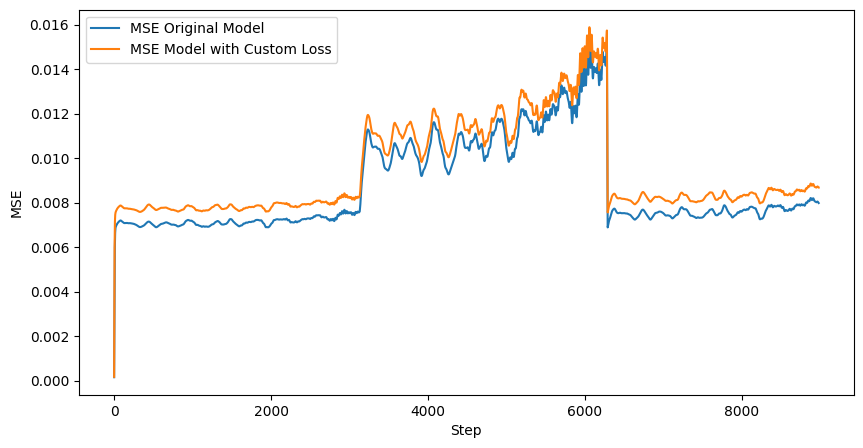

In [ ]:
orig_model = tf.keras.models.load_model('/home/scheng1/Hanyang/Phy_Res/orign_model_10steps.h5')
res_orig =tf.keras.models.load_model('/home/scheng1/Hanyang/Phy_Res/Phy_model_10stepspdeconvlstm.h5',
                                           custom_objects={'custom_loss': custom_loss,
                                                           'inverse_problem_regularization_loss':inverse_problem_regularization_loss,
                                                            'calculate_energy_loss': calculate_energy_loss,
                                                            'pde_loss6':pde_loss6})

# Define a function to make predictions using the model and calculate MSE

# Define a function to make step-by-step predictions using the model and calculate MSE
def predict_and_calc_mse(model, x_data, y_data):
    mse_values = []
    num_steps = x_data.shape[0]

    # Initial input for the first step
    x_input = x_data[0, :, :, :, :]

    for step in range(num_steps):
        x_input = np.expand_dims(x_input, axis=0)  # Add a batch dimension
        y_true = np.expand_dims(y_data[step, :, :, :, :], axis=0)  # Add a batch dimension

        # Predict the output for the current step
        y_pred = model.predict(x_input)

        mse = np.mean((y_pred - y_true) ** 2)
        mse_values.append(mse)

        # Prepare input for the next step
        x_input = y_pred[0]

    return mse_values


# Call the function for the 'orig_model' and 'res_orig' model
mse_orig_model = predict_and_calc_mse(orig_model, x_val, y_val)
mse_res_orig = predict_and_calc_mse(res_orig, x_val, y_val)

# Plot the MSE values
plt.figure(figsize=(10, 5))
plt.plot(mse_orig_model, label='MSE Original Model')
plt.plot(mse_res_orig, label='MSE Model with Custom Loss')
plt.xlabel('Step')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error


#orig_model = tf.keras.models.load_model('/home/scheng1/Hanyang/Phy_Res/orign_model_10steps.h5')
#res_orig =tf.keras.models.load_model('/home/scheng1/Hanyang/Phy_Res/Phy_model_10stepsfinal.h5',
                                          # custom_objects={'custom_loss': custom_loss,
                                                    #       'inverse_problem_regularization_loss':inverse_problem_regularization_loss,
                                                      #      'calculate_energy_loss': calculate_energy_loss,
                                                       #     'calculate_symmetry_loss':calculate_symmetry_loss})

# Calculate inference time
start_time = time.time()
res_orign = model.predict(x_val)
inference_time = time.time() - start_time

# Assuming vor_test is your concatenated array with shape (n, 64, 64, 3)
# And vor_test_u_scaler, vor_test_v_scaler, vor_test_h_scaler are the scalers used for u, v, and h channels respectively

# Step 1: Separate the channels
vor_test_u = res_orign[:,0,:,:,0]
vor_test_v = res_orign[:,0,:,:,1]
vor_test_h = res_orign[:,0,:,:,2]

# Step 2: Inverse transform each channel
vor_test_u_original = vor_test_u * range_vu + min_vu
vor_test_v_original = vor_test_v * range_vv + min_vv
vor_test_h_original = vor_test_h * range_vh + min_vh

# Step 3: Recombine the channels
res_orign = np.stack([vor_test_u_original, vor_test_v_original, vor_test_h_original], axis=-1)

# Repeat the same steps for y_val if needed
vor_test_u = y_val[:,0,:,:,0]
vor_test_v = y_val[:,0,:,:,1]
vor_test_h = y_val[:,0,:,:,2]

vor_test_u_original = vor_test_u * range_vu + min_vu
vor_test_v_original = vor_test_v * range_vv + min_vv
vor_test_h_original = vor_test_h * range_vh + min_vh

# Recombine the channels
y_val = np.stack([vor_test_u_original, vor_test_v_original, vor_test_h_original], axis=-1)


res_orign = res_orign[:,:,:,:]
y_true = y_val[:, :, :, :]
res_orig_flat = res_orign.flatten()
y_true_flat = y_true.flatten()

mse_orig = mean_squared_error(res_orig_flat, y_true_flat)

ssim_score = ssim(y_true, res_orign, multichannel=True)

# Calculate RRMSE
rrmse = np.sqrt(mse_orig) / np.mean(y_true)


print("SSIM:", ssim_score)
print("RRMSE:", rrmse)
print("MSE_orig:", mse_orig)
print("Inference Time:", inference_time)


75/75 [==============================] - 7s 90ms/step


<ipython-input-31-dbac277f2b5f>:52: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_score = ssim(y_true, res_orign, multichannel=True)
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


SSIM: 0.8414425
RRMSE: 0.1023664
MSE_orig: 0.0012594232
Inference Time: 10.843816757202148


In [ ]:
y_val.shape

(2380, 10, 64, 3, 3)

In [ ]:
from sklearn.metrics import mean_squared_error
from tensorflow.python.keras.models import load_model
#orig_model = tf.keras.models.load_model('/home/scheng1/Hanyang/Phy_Res/orign_model_10steps.h5')
res_phy =tf.keras.models.load_model('/home/scheng1/Hanyang/Phy_Res/Phy_model_10stepspdeconvlstm.h5',
                                           custom_objects={'custom_loss': custom_loss,
                                                           'inverse_problem_regularization_loss':inverse_problem_regularization_loss,
                                                            'calculate_energy_loss': calculate_energy_loss,
                                                            'pde_loss6':pde_loss6})
res_orig=orig_model.predict(x_val)
res_phy=res_phy.predict(x_val)

res_orig = res_orig[:,0,:,:,:]
res_phy=res_phy[:,0,:,:,:]

y_true = y_val[:,0,:,:,:]

mse_orig = mean_squared_error(res_orig.flatten(), y_true.flatten())
mse_phy = mean_squared_error(res_phy.flatten(), y_true.flatten())

print("MSE_orig:", mse_orig)
print("mse_phy:", mse_phy)

MSE_orig: 0.0015882252
mse_phy: 0.0016327875


In [ ]:
from skimage.metrics import structural_similarity as ssim

# Compute SSIM between the two images

ssim_score_orig = ssim(y_true, res_orig,multichannel=True)
ssim_score_phy = ssim(y_true, res_phy,multichannel=True)

# Print the SSIM score
print("The SSIM score orig is:", ssim_score_orig)
print("The SSIM score phy is:", ssim_score_phy)


# Flatten the image sets to size (7500, 12288)
flat_set_true = y_true.reshape((y_true.shape[0], -1))
flat_set_orig = res_orig.reshape((res_orig.shape[0], -1))
flat_set_phy = res_phy.reshape((res_phy.shape[0], -1))

# Compute the L2 norm between the two flattened sets
diff_vectors_orig = flat_set_true - flat_set_orig
diff_vectors_phy = flat_set_true - flat_set_phy

l2_norms_orig = np.linalg.norm(diff_vectors_orig, axis=1)
l2_norms_phy = np.linalg.norm(diff_vectors_phy, axis=1)


relative_errors_orig = l2_norms_orig / np.linalg.norm(flat_set_true, axis=1)
relative_errors_phy = l2_norms_phy / np.linalg.norm(flat_set_true, axis=1)

mean_relative_error_orig = np.mean(relative_errors_orig)
mean_relative_error_phy = np.mean(relative_errors_phy)


# Print the L2 norm error
print("The L2 norm error orig is:", mean_relative_error_orig)
print("The L2 norm error phy is:", mean_relative_error_phy)

/home/scheng1/miniconda3/envs/a6000/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  """
/home/scheng1/miniconda3/envs/a6000/lib/python3.7/site-packages/skimage/_shared/utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)
/home/scheng1/miniconda3/envs/a6000/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  


The SSIM score orig is: 0.8190329
The SSIM score phy is: 0.8171802
The L2 norm error orig is: 0.07497508
The L2 norm error phy is: 0.07623915


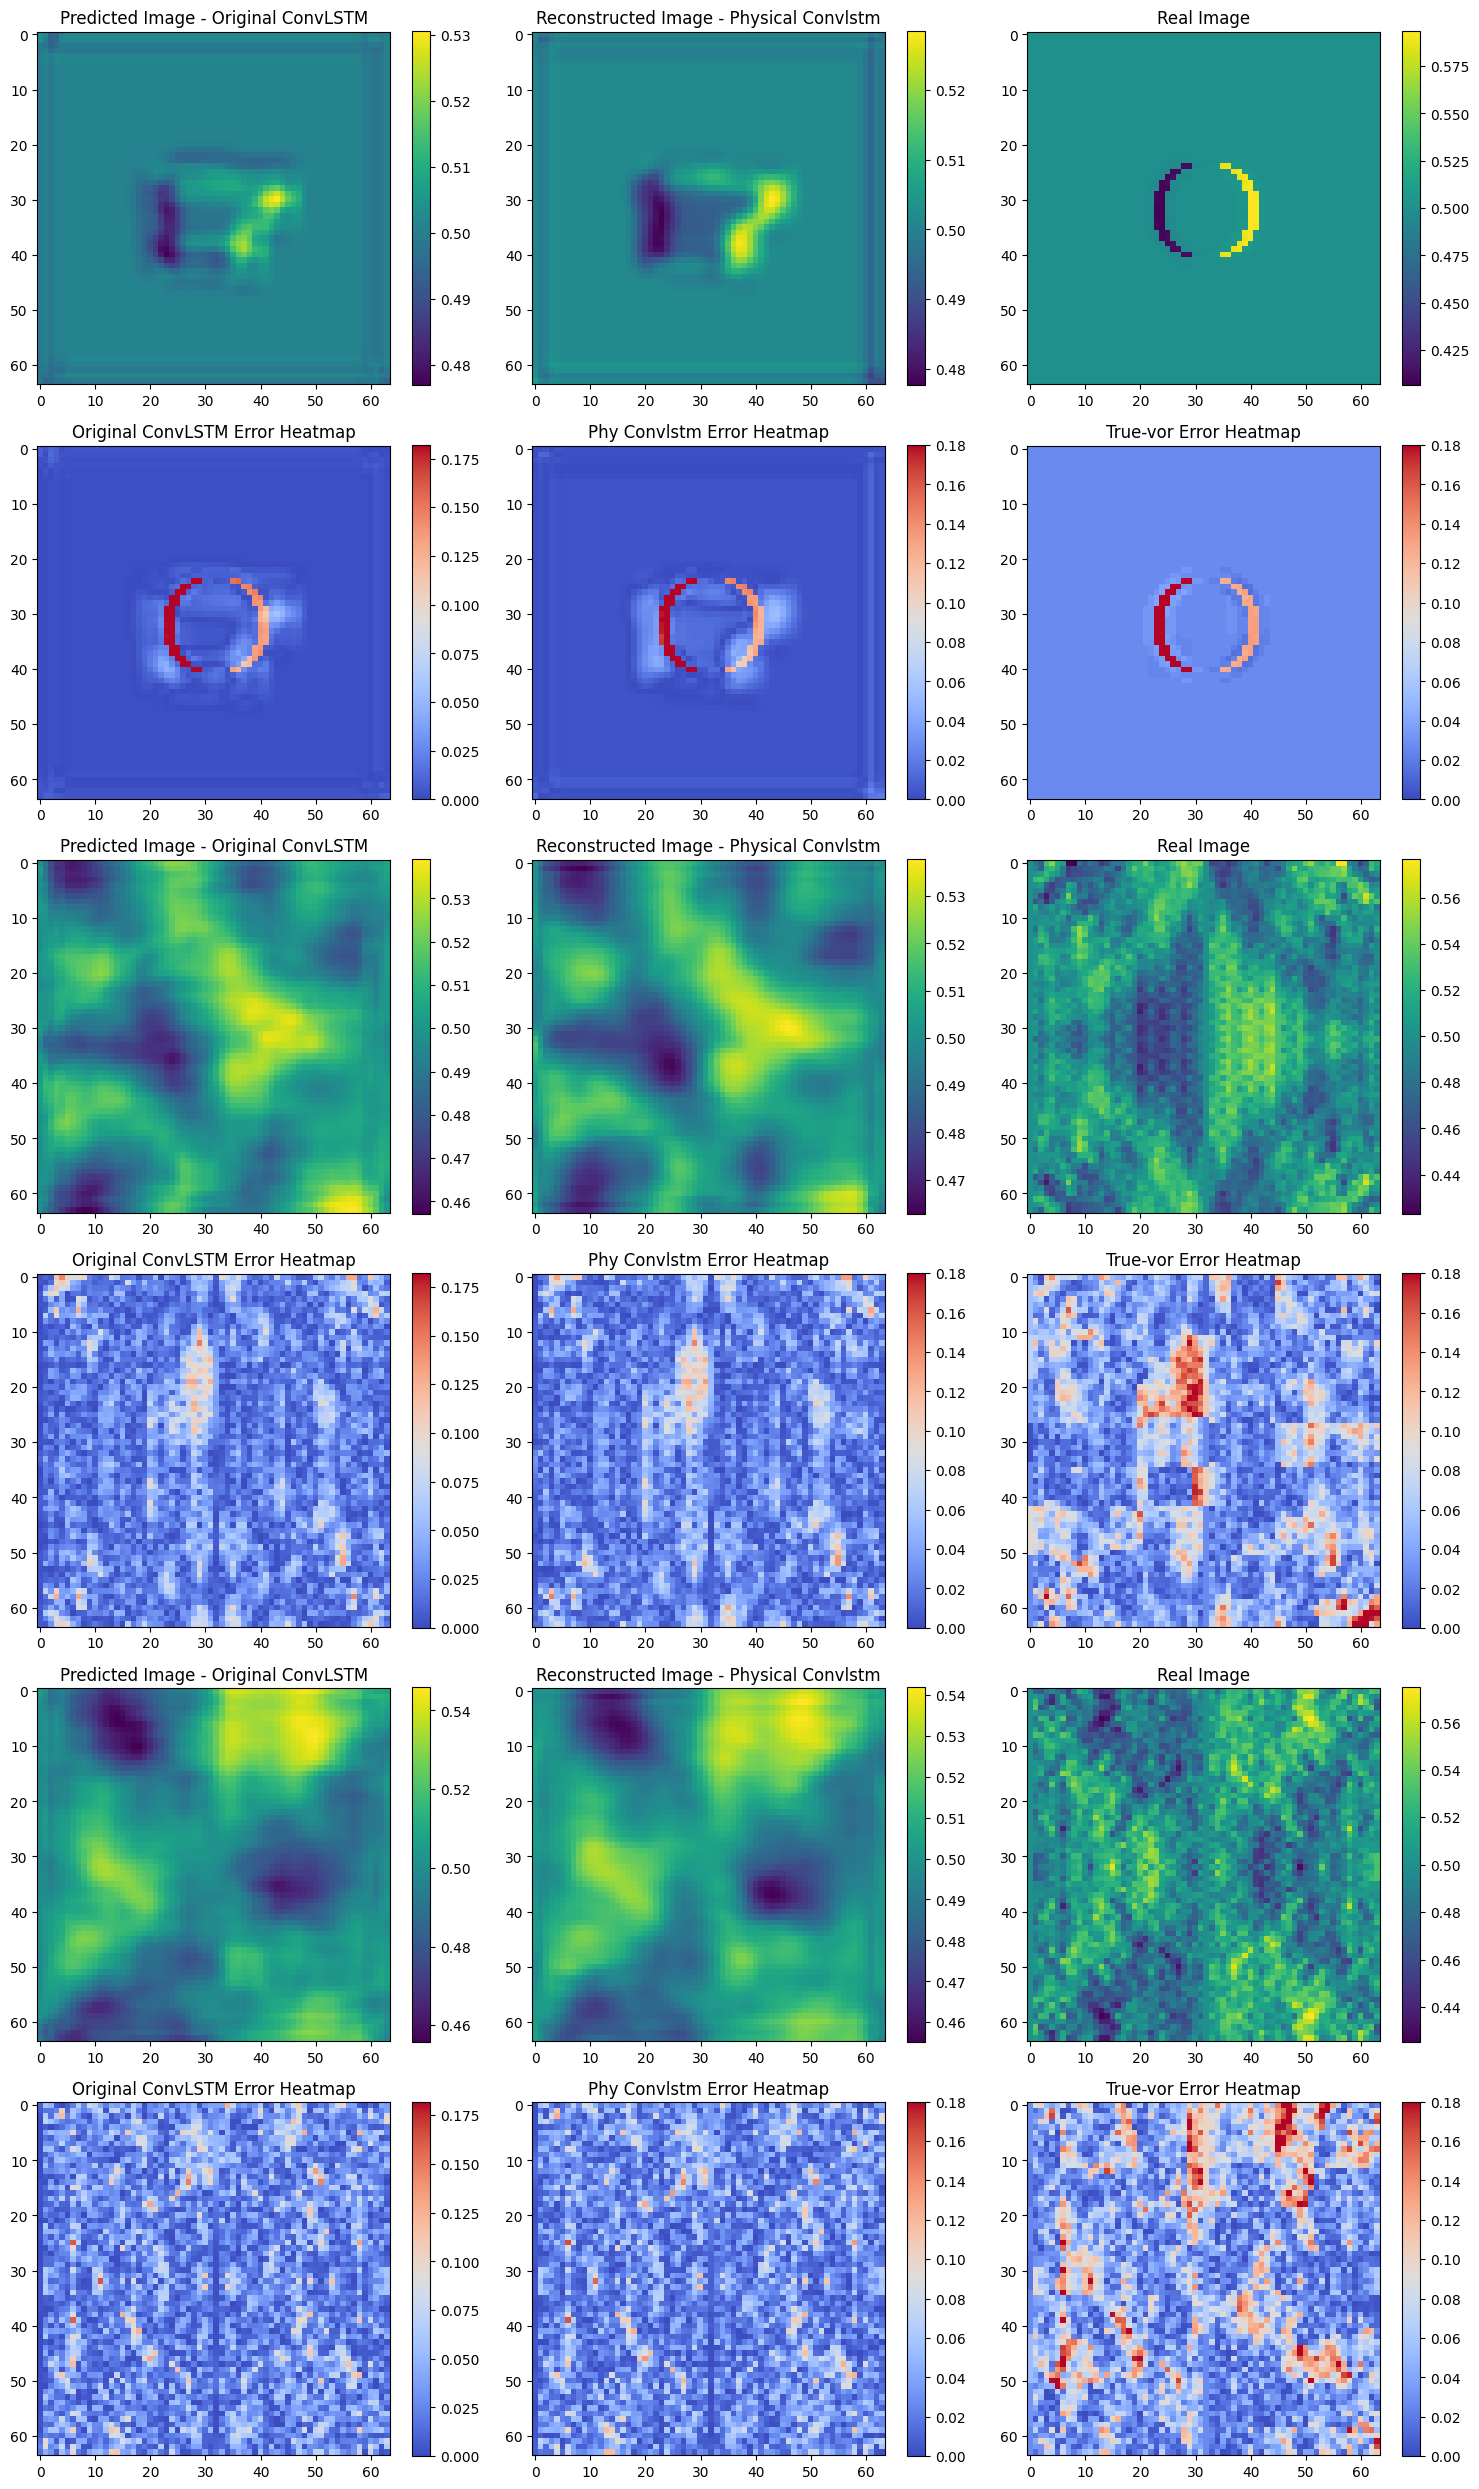

In [ ]:
x_train = np.load('/home/scheng1/Hanyang/Datasets/x_train.npy', mmap_mode="r")
y_train = np.load('/home/scheng1/Hanyang/Datasets/y_train.npy', mmap_mode="r")
x_val= np.load('/home/scheng1/Hanyang/Datasets/x_val.npy', mmap_mode="r")
y_val = np.load('/home/scheng1/Hanyang/Datasets/y_val.npy', mmap_mode="r")
# Define the subplot layout
fig, axs = plt.subplots(nrows=6, ncols=3, figsize=(15, 25))

# Define the vmin and vmax values for the heatmaps
vmin = 0
vmax = 0.18
res = res_orig[:,:,:,0]
reconstructed_images_train = res_phy[:,:,:,0]
y_val = y_val[:,0,:,:,0]
x_val = x_val[:,0,:,:,0]


# Loop through the subplots and show the images and heatmaps
for i in (0,2,4):
    # Show the predicted image
    im = axs[i, 0].imshow(res[400*i, :, :])
    axs[i, 0].set_title('Predicted Image - Original ConvLSTM')
    fig.colorbar(im, ax=axs[i, 0])
    # Show the reconstructed image
    im = axs[i, 1].imshow(reconstructed_images_train[400*i, :, :])
    axs[i, 1].set_title('Reconstructed Image - Physical Convlstm')
    fig.colorbar(im, ax=axs[i, 1])

    im = axs[i, 2].imshow(y_val[400*i, :, :])
    axs[i, 2].set_title('Real Image')
    fig.colorbar(im, ax=axs[i, 2])

    # Calculate the L2 norm error between the predicted and target images
    flat_target = y_val[400*i,:, :]
    flat_pred = res[400*i,:, :]
    diff_vector = flat_target - flat_pred
    l2_norm_error = diff_vector / flat_target

    # Show the heatmap with a colorbar
    abs_diff_vector = np.abs(l2_norm_error)
    im = axs[i+1, 0].imshow(abs_diff_vector, cmap='coolwarm', vmin=vmin, vmax=vmax+0.002)
    fig.colorbar(im, ax=axs[i+1, 0])
    axs[i+1, 0].set_title('Original ConvLSTM Error Heatmap')

    # Calculate the L2 norm error between the reconstructed and target images
    flat_target = y_val[400*i, :, :]
    flat_pred = reconstructed_images_train[400*i, :, :]
    diff_vector = flat_target - flat_pred
    l2_norm_error = diff_vector / flat_target

    # Show the heatmap with a colorbar
    abs_diff_vector = np.abs(l2_norm_error)
    im = axs[i+1, 1].imshow(abs_diff_vector, cmap='coolwarm', vmin=vmin, vmax=vmax)
    fig.colorbar(im, ax=axs[i+1, 1])
    axs[i+1, 1].set_title('Phy Convlstm Error Heatmap')

    # Calculate the L2 norm error between the reconstructed and target images
    flat_target = y_val[400*i, :, :]
    flat_pred = x_val[400*i, :, :]
    diff_vector = flat_target - flat_pred
    l2_norm_error = diff_vector / flat_target

    # Show the heatmap with a colorbar
    abs_diff_vector = np.abs(l2_norm_error)
    im = axs[i+1, 2].imshow(abs_diff_vector, cmap='coolwarm', vmin=vmin, vmax=vmax)
    fig.colorbar(im, ax=axs[i+1, 2])
    axs[i+1, 2].set_title('True-vor Error Heatmap')

# Adjust the subplot layout
fig.tight_layout()
plt.savefig('my_figure.png')

plt.show()

In [ ]:

# Load the saved model
#loaded_model = tf.keras.models.load_model('/home/scheng1/Hanyang/Datasets/my_model_4.h5')
#res = loaded_model.predict(x_val)
res=model.predict(x_val)


In [ ]:
res_d = res[:,0,:,:,:]
y_true = y_val[:,0,:,:,:]
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(res_d.flatten(), y_true.flatten())
print("MSE:", mse)



MSE: 0.0005541991


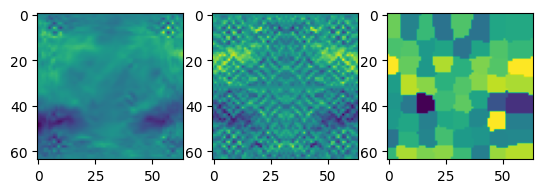

In [ ]:
plt.subplot(1,3,1)
imshow(res[3000,0,:,:,1])
plt.subplot(1,3,2)
imshow(y_val[3000,0,:,:,1])
plt.subplot(1,3,3)
imshow(x_val[2300,0,:,:,1])

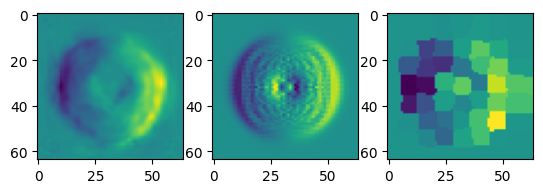

In [ ]:
plt.subplot(1,3,1)
imshow(res[200,0,:,:,0])
plt.subplot(1,3,2)
imshow(y_val[200,0,:,:,0])
plt.subplot(1,3,3)
imshow(x_val[201,0,:,:,0])

In [ ]:
res_ssim = res[:,0,:,:,:]
y_val_ssim = y_val[:,0,:,:,:]

In [ ]:
y_val_ssim.shape

(12992, 64, 64, 3)

In [ ]:
from skimage.metrics import structural_similarity as ssim

# Compute SSIM between the two images

ssim_score = ssim(y_val_ssim, res_ssim,multichannel=True)

# Print the SSIM score
print("The SSIM score is:", ssim_score)

# Flatten the image sets to size (7500, 12288)
flat_set1 = y_val_ssim.reshape((12992, -1))
flat_set2 = res_ssim.reshape((12992, -1))

# Compute the L2 norm between the two flattened sets
diff_vectors = flat_set1 - flat_set2
l2_norms = np.linalg.norm(diff_vectors, axis=1)
relative_errors = l2_norms / np.linalg.norm(flat_set1, axis=1)
mean_relative_error = np.mean(relative_errors)


# Print the L2 norm error
print("The L2 norm error is:", mean_relative_error)

/home/scheng1/miniconda3/envs/a6000tf26/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  """


The SSIM score is: 0.90589935
The L2 norm error is: 0.04547094


In [ ]:
relative_errors_3d = relative_errors.reshape(7484,64,64,3)
fig, ax = plt.subplots()
im = ax.imshow(relative_errors_3d, cmap='viridis')

# Set the axis labels and title
ax.set_xlabel('Image Set 2')
ax.set_ylabel('Image Set 1')
ax.set_title('L2 Norm Error Heatmap')

In [ ]:
del loaded_model

# ConvAutoencoder

In [3]:
vor_train = np.load('/content/drive/MyDrive/Physics/Physics/Dataset/vor_train.npy', mmap_mode="r")
true_train = np.load('/content/drive/MyDrive/Physics/Physics/Dataset/true_train.npy', mmap_mode="r")
vor_test = np.load('/content/drive/MyDrive/Physics/Physics/Dataset/vor_test.npy', mmap_mode="r")
true_test = np.load('/content/drive/MyDrive/Physics/Physics/Dataset/true_test.npy', mmap_mode="r")

In [4]:
vor_image = np.vstack([vor_train,vor_test])
true_image = np.vstack([true_train,true_test])


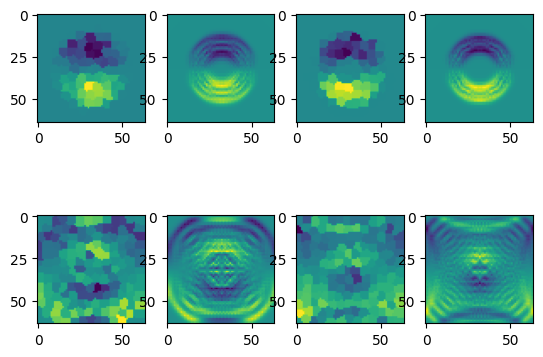

In [5]:
plt.subplot(2,4,1)
plt.imshow(vor_test[10,:,:,0])
plt.subplot(2,4,2)
plt.imshow(true_test[10,:,:,0])
plt.subplot(2,4,3)
plt.imshow(vor_train[300,:,:,0])
plt.subplot(2,4,4)
plt.imshow(true_train[300,:,:,0])
plt.subplot(2,4,5)
plt.imshow(vor_test[500,:,:,0])
plt.subplot(2,4,6)
plt.imshow(true_test[500,:,:,0])
plt.subplot(2,4,7)
plt.imshow(vor_test[200,:,:,0])
plt.subplot(2,4,8)
plt.imshow(true_test[200,:,:,0])

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

tf.keras.utils.set_random_seed(1)

# Encoder
input_img = layers.Input(shape=(64, 64, 3))
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.Flatten()(x)
encoded = layers.Dense(512, activation='relu', name='encoded')(x)

# Decoder
x = layers.Dense(16*16*64, activation='relu')(encoded)
x = layers.Reshape((16, 16, 64))(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(3, (3, 3), activation='tanh', padding='same', name='decoded')(x)

# Autoencoder Model
autoencoder = models.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 16)        4624      
                                                                 
 flatten (Flatten)           (None, 16384)             0         
                                                                 
 encoded (Dense)             (None, 512)               8389120   
                                                             

In [ ]:

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Set the random seed for reproducibility
tf.keras.utils.set_random_seed(1337)

# Callbacks for adaptive learning rate and early stopping
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=15,
    min_lr=1e-6
)
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

# Training the autoencoder
# Make sure autoencoder, vor_train, true_train, vor_test, and true_test are properly defined
history = autoencoder.fit(
    vor_train,
    true_train,
    epochs=100,
    batch_size=128,
    callbacks=[reduce_lr, early_stop],
    validation_data=(vor_test, true_test),
    shuffle=True
)


Epoch 1/100
317/317 [==============================] - 13s 21ms/step - loss: 0.0097 - val_loss: 0.0046 - lr: 0.0010
Epoch 2/100
317/317 [==============================] - 5s 15ms/step - loss: 0.0045 - val_loss: 0.0043 - lr: 0.0010
Epoch 3/100
317/317 [==============================] - 5s 15ms/step - loss: 0.0044 - val_loss: 0.0042 - lr: 0.0010
Epoch 4/100
317/317 [==============================] - 5s 15ms/step - loss: 0.0043 - val_loss: 0.0042 - lr: 0.0010
Epoch 5/100
317/317 [==============================] - 5s 15ms/step - loss: 0.0042 - val_loss: 0.0041 - lr: 0.0010
Epoch 6/100
317/317 [==============================] - 5s 15ms/step - loss: 0.0042 - val_loss: 0.0041 - lr: 0.0010
Epoch 7/100
317/317 [==============================] - 5s 15ms/step - loss: 0.0042 - val_loss: 0.0041 - lr: 0.0010
Epoch 8/100
317/317 [==============================] - 5s 15ms/step - loss: 0.0042 - val_loss: 0.0041 - lr: 0.0010
Epoch 9/100
317/317 [==============================] - 5s 15ms/step - loss: 0.0

In [ ]:
import json
from tensorflow.keras.models import model_from_json

# Step 1: Serialize model to JSON
model_json = autoencoder.to_json()
with open("/content/drive/MyDrive/Physics/Physics/MOdel_para/CAE/autoencoder_architecture.json", "w") as json_file:
    json_file.write(model_json)

# Step 2: Serialize weights to HDF5
autoencoder.save_weights("/content/drive/MyDrive/Physics/Physics/MOdel_para/CAE/autoencoder_weights.h5")
print("Saved model to disk 😄")

# Step 3 & 4: Document training parameters and performance metrics
with open("/content/drive/MyDrive/Physics/Physics/MOdel_para/CAE/model_info.txt", "w") as f:
    f.write("Training Parameters and Performance Metrics\n")
    f.write("=================================================\n")
    f.write("ReduceLROnPlateau settings:\n")
    f.write(f"- Monitor: val_loss\n")
    f.write(f"- Factor: 0.2\n")
    f.write(f"- Patience: 30\n")
    f.write(f"- Min LR: 1e-6\n\n")
    f.write("EarlyStopping settings:\n")
    f.write(f"- Monitor: val_loss\n")
    f.write(f"- Patience: 40\n")
    f.write(f"- Restore Best Weights: True\n\n")
    f.write("Training History:\n")
    for key, values in history.history.items():
        f.write(f"- {key}: {values}\n")

print("All model information has been saved successfully 😄")

# To reload the model architecture and weights later:
# with open('autoencoder_architecture.json', 'r') as json_file:
#     loaded_model_json = json_file.read()
# loaded_model = model_from_json(loaded_model_json)
# loaded_model.load_weights("autoencoder_weights.h5")


Saved model to disk 😄
All model information has been saved successfully 😄


In [6]:

from tensorflow.keras.models import model_from_json
import keras
import tensorflow as tf
from tensorflow.keras import layers, models

# Load the model architecture from JSON file
with open('/content/drive/MyDrive/Physics/Physics/MOdel_para/CAE/autoencoder_architecture.json', 'r') as json_file:
    loaded_model_json = json_file.read()
    autoencoder = model_from_json(loaded_model_json)

# Load weights into the loaded model
autoencoder.load_weights("/content/drive/MyDrive/Physics/Physics/MOdel_para/CAE/autoencoder_weights.h5")

# Extracting the last layers from the loaded model
# Assuming 'last_layers' should start from the 6th layer (index 5) till the end
encode_layers = autoencoder.layers[:6]

# Create a new Sequential model with the extracted layers
encoded = keras.models.Sequential(encode_layers)


last_layers = autoencoder.layers[-7:]
new_model = tf.keras.models.Sequential(last_layers)
encoded_features = encoded.predict(vor_image)


1407/1407 [==============================] - 4s 2ms/step


In [ ]:
import tensorflow as tf
encoder = tf.keras.models.Model(input_img, encoded)


'''encoded_features = encoded.predict(vor_image)'''
reconstructed_images = autoencoder.predict(vor_image)

1407/1407 [==============================] - 4s 2ms/step


NameError: name 'reconstructed_images' is not defined

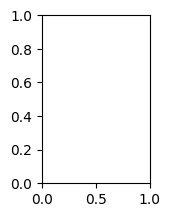

In [ ]:

plt.subplot(2,4,1)
plt.imshow(reconstructed_images[140,:,:,1])
plt.subplot(2,4,2)
plt.imshow(true_image[-200,:,:,0])
plt.subplot(2,4,3)
plt.imshow(reconstructed_images[450,:,:,0])
plt.subplot(2,4,4)
plt.imshow(true_image[800,:,:,0])
plt.subplot(2,4,5)
plt.imshow(reconstructed_images[800,:,:,0])
plt.subplot(2,4,6)
plt.imshow(true_image[-580,:,:,0])
plt.subplot(2,4,7)
plt.imshow(reconstructed_images[1100,:,:,0])
plt.subplot(2,4,8)
plt.imshow(true_image[-30,:,:,0])

In [ ]:
#encoded = norm_auto(encoded_features)

import numpy as np
from sklearn.model_selection import train_test_split

# Assuming encoded_features is defined and loaded correctly
n_frames = 6
x_train_cnn, x_test_cnn = train_test_split(encoded_features, test_size=0.10, shuffle=False)

def create_sequences(data, sequence_length):
    return np.array([data[i:i+sequence_length] for i in range(len(data) - sequence_length)])

def create_shifted_frames(data, n_frames):
    return data[:-n_frames], data[n_frames:]

# Create sequences
x_train = create_sequences(x_train_cnn, n_frames)
x_test = create_sequences(x_test_cnn, n_frames)

# Apply the processing function to the datasets
x_train, y_train = create_shifted_frames(x_train, n_frames)
x_val, y_val = create_shifted_frames(x_test, n_frames)

print(y_train.shape)  # To display the shape of y_train

(40488, 6, 512)


In [ ]:
def create_sequences(data, sequence_length):
    return np.array([data[i:i+sequence_length] for i in range(len(data) - sequence_length)])

def create_shifted_frames(data, n_frames):
    return data[:-n_frames], data[n_frames:]
true_image = create_sequences(true_train, 6)

true_image = true_image[6:]


In [ ]:
np.save('/content/drive/MyDrive/Physics/Physics/Dataset/x_train_LSTM.npy', x_train)
np.save('/content/drive/MyDrive/Physics/Physics/Dataset/y_train_LSTM.npy', y_train)
np.save('/content/drive/MyDrive/Physics/Physics/Dataset/x_val_LSTM.npy', x_val)
np.save('/content/drive/MyDrive/Physics/Physics/Dataset/y_val_LSTM.npy', y_val)



In [7]:
x_train = np.load('/content/drive/MyDrive/Physics/Physics/Dataset/x_train_LSTM.npy')
y_train = np.load('/content/drive/MyDrive/Physics/Physics/Dataset/y_train_LSTM.npy')
x_val = np.load('/content/drive/MyDrive/Physics/Physics/Dataset/x_val_LSTM.npy')
y_val = np.load('/content/drive/MyDrive/Physics/Physics/Dataset/y_val_LSTM.npy')


In [8]:
import tensorflow as tf

class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, decoder_model, **kwargs):
        super(DecoderLayer, self).__init__(**kwargs)
        # Ensure the decoder_model is a callable (e.g., a Keras model or a function)
        if not callable(decoder_model):
            raise ValueError("decoder_model must be callable")
        self.decoder_model = decoder_model

    def call(self, inputs):
        # It's good practice to check if the inputs are valid for the decoder_model
        # This can be more specific based on the expected input shape, type, etc.
        if inputs is None:
            raise ValueError("Input to DecoderLayer cannot be None")

        # Use decoder_model to decode the inputs
        decoded_images = self.decoder_model(inputs)
        return decoded_images



# Physical Constraint Function

In [9]:
import tensorflow as tf
decoder_layer = DecoderLayer(new_model)

x=512
n=6
def preprocess_images(y_true, y_pred):
    decoder_layer = DecoderLayer(new_model)
    y_pred = tf.reshape(y_pred, (-1, 512))
    y_true = tf.reshape(y_true, (-1, 512))
    y_pred = decoder_layer(y_pred)
    y_true = decoder_layer(y_true)
    y_pred = tf.reshape(y_pred, (-1, n, 64, 64, 3))
    y_true = tf.reshape(y_true, (-1, n, 64, 64, 3))
    return y_true, y_pred

def calculate_image_energy(img):
    g = 9.81
    dx = 1
    img = tf.reshape(img, (-1, img.shape[2], img.shape[3],3))

    kinetic_energy = 0.5 * tf.reduce_sum(tf.square(img[..., 0]), axis=(1, 2)) * dx**2
    kinetic_energy += 0.5 * tf.reduce_sum(tf.square(img[..., 1]), axis=(1, 2)) * dx**2
    # Calculate potential energy
    potential_energy = 0.5 * g * tf.reduce_sum(tf.square(img[..., 2]), axis=(1, 2)) * dx**2
    # Calculate total energy
    total_energy = kinetic_energy + potential_energy
    return total_energy


def calculate_relative_energy_error(y_true, y_pred):
    y_true, y_pred = preprocess_images(y_true, y_pred)
    energy_true = calculate_image_energy(y_true)
    energy_pred = calculate_image_energy(y_pred)
    return tf.reduce_sum(tf.abs(energy_pred - energy_true))

def calculate_mass_conservation(y):
    y = tf.reshape(y, (-1, y.shape[2], y.shape[3], 3))
    h, u, v = y[..., 2:3], y[..., 0:1], y[..., 1:2]
    dh_dx, dh_dy = tf.image.image_gradients(h)
    du_dx, _ = tf.image.image_gradients(u)
    _, dv_dy = tf.image.image_gradients(v)
    return dh_dx * u + h * du_dx + dh_dy * v + h * dv_dy

def calculate_mass_conservation_loss(y_true, y_pred):
    y_true, y_pred = preprocess_images(y_true, y_pred)
    mass_conservation_true = calculate_mass_conservation(y_true)
    mass_conservation_pred = calculate_mass_conservation(y_pred)
    return tf.reduce_mean(tf.abs(mass_conservation_pred - mass_conservation_true))

def custom_loss(y_true, y_pred):
    mse_loss = tf.losses.mean_squared_error(y_true, y_pred)
    energy_restriction = calculate_relative_energy_error(y_true, y_pred)
    mass_conservation_loss_value = calculate_mass_conservation_loss(y_true, y_pred)
    return mse_loss + 5e-09 * energy_restriction + 0.001 * mass_conservation_loss_value


# CED Origin

In [ ]:
import tensorflow as tf
from tensorflow.keras import Model, Input, layers, callbacks

tf.keras.utils.set_random_seed(42)

def build_original_model(n_step=6, feature_dim=512):
    """Builds an original LSTM model without physics-informed constraints."""
    inputs = Input(shape=(n_step, feature_dim))
    x = layers.LSTM(32)(inputs)
    x = layers.RepeatVector(n_step)(x)
    x = layers.LSTM(32, return_sequences=True)(x)
    x = layers.TimeDistributed(layers.Dense(feature_dim))(x)
    outputs = layers.Activation('relu')(x)

    model = Model(inputs=inputs, outputs=outputs, name="OriginalModel")
    return model

original_model = build_original_model()
original_model.compile(
    loss='mse',
    optimizer=tf.keras.optimizers.Adam(lr=0.05),
    metrics=['mean_squared_error', calculate_relative_energy_error,calculate_mass_conservation_loss]
)

original_model.summary()


# Training the original model
original_history = original_model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=50,
    batch_size=128,
    shuffle=True,
)



Model: "OriginalModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 6, 512)]          0         
                                                                 
 lstm_4 (LSTM)               (None, 32)                69760     
                                                                 
 repeat_vector_2 (RepeatVec  (None, 6, 32)             0         
 tor)                                                            
                                                                 
 lstm_5 (LSTM)               (None, 6, 32)             8320      
                                                                 
 time_distributed_2 (TimeDi  (None, 6, 512)            16896     
 stributed)                                                      
                                                                 
 activation_2 (Activation)   (None, 6, 512)          

In [ ]:
import tensorflow as tf
from tensorflow.keras import Model, Input, layers, callbacks
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau

tf.keras.utils.set_random_seed(1)


def build_original_model(n_step=6, feature_dim=512):
    """Builds an original LSTM model without physics-informed constraints."""
    inputs = Input(shape=(n_step, feature_dim))
    x = layers.LSTM(32)(inputs)
    x = layers.RepeatVector(n_step)(x)
    x = layers.LSTM(32, return_sequences=True)(x)
    x = layers.TimeDistributed(layers.Dense(feature_dim))(x)
    outputs = layers.Activation('relu')(x)

    model = Model(inputs=inputs, outputs=outputs, name="OriginalModel")
    return model

original_model = build_original_model()
original_model.compile(
    loss='mse',
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    metrics=['mean_squared_error', calculate_relative_energy_error,calculate_mass_conservation_loss]
)

original_model.summary()

#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.0005)

# Training the original model with the ReduceLROnPlateau callback
original_history = original_model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=60,
    batch_size=128,
    shuffle=True,
#    callbacks=[reduce_lr]  # Add the callback here
)

Model: "OriginalModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 6, 512)]          0         
                                                                 
 lstm_22 (LSTM)              (None, 32)                69760     
                                                                 
 repeat_vector_11 (RepeatVe  (None, 6, 32)             0         
 ctor)                                                           
                                                                 
 lstm_23 (LSTM)              (None, 6, 32)             8320      
                                                                 
 time_distributed_11 (TimeD  (None, 6, 512)            16896     
 istributed)                                                     
                                                                 
 activation_11 (Activation)  (None, 6, 512)          

KeyboardInterrupt: 

In [ ]:
# 保存整个模型
original_model.save('/content/drive/MyDrive/Physics/Physics/MOdel_para/LSTM/0215-Orig/original_model.h5')  # 保存为HDF5文件

# 仅保存模型权重
original_model.save_weights('/content/drive/MyDrive/Physics/Physics/MOdel_para/LSTM/0215-Orig/original_model_weights.h5')

import json

# 将history对象中的历史数据转换为字典
history_dict = original_history.history

# 将字典保存为JSON文件
with open('/content/drive/MyDrive/Physics/Physics/MOdel_para/LSTM/0215-Orig/original_model_history.json', 'w') as f:
    json.dump(history_dict, f)



/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# CED phy

In [ ]:
def build_physical_model(n_step=6, feature_dim=512):
    """Builds a LSTM model with physics-informed constraints."""
    inputs = Input(shape=(n_step, feature_dim))
    x = layers.LSTM(32)(inputs)
    x = layers.RepeatVector(n_step)(x)
    x = layers.LSTM(32, return_sequences=True)(x)
    x = layers.TimeDistributed(layers.Dense(feature_dim))(x)
    outputs = layers.Activation('relu')(x)

    model = Model(inputs=inputs, outputs=outputs, name="PhysicalModel")
    return model


In [ ]:
from tensorflow.keras.callbacks import Callback

class UpdateLossWeights(Callback):
    def __init__(self, alpha, beta, alpha_increment, beta_increment):
        super(UpdateLossWeights, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.alpha_increment = alpha_increment
        self.beta_increment = beta_increment

    def on_epoch_end(self, epoch, logs=None):
        self.alpha += self.alpha_increment
        self.beta += self.beta_increment
        print(f"Updated alpha: {self.alpha}, beta: {self.beta}")
        # You may want to log/print the updated values for monitoring purposes

# Assuming initial values and increments for alpha and beta
initial_alpha = 5e-10
initial_beta = 1e-4
alpha_increment = 1e-10
beta_increment = 1e-4

# Instantiate the callback
update_loss_weights_callback = UpdateLossWeights(initial_alpha, initial_beta, alpha_increment, beta_increment)



In [ ]:
physical_model = build_physical_model()

physical_model.compile(
    loss=custom_loss,
    optimizer=tf.keras.optimizers.Adam(lr=0.05),
    metrics=['mean_squared_error', calculate_relative_energy_error,calculate_mass_conservation_loss]
)

# Use the callback during model training
physical_history = physical_model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=50,
    batch_size=128,
    shuffle=True,
    #callbacks=[update_loss_weights_callback]
)


Epoch 1/50
317/317 [==============================] - 39s 102ms/step - loss: 0.0111 - mean_squared_error: 0.0104 - calculate_relative_energy_error: 131392.5000 - calculate_mass_conservation_loss: 0.0205 - val_loss: 0.0058 - val_mean_squared_error: 0.0054 - val_calculate_relative_energy_error: 75600.9062 - val_calculate_mass_conservation_loss: 0.0176
Epoch 2/50
317/317 [==============================] - 30s 96ms/step - loss: 0.0045 - mean_squared_error: 0.0042 - calculate_relative_energy_error: 70117.2031 - calculate_mass_conservation_loss: 0.0124 - val_loss: 0.0037 - val_mean_squared_error: 0.0033 - val_calculate_relative_energy_error: 69688.0078 - val_calculate_mass_conservation_loss: 0.0112
Epoch 3/50
317/317 [==============================] - 31s 96ms/step - loss: 0.0034 - mean_squared_error: 0.0030 - calculate_relative_energy_error: 67330.6172 - calculate_mass_conservation_loss: 0.0091 - val_loss: 0.0031 - val_mean_squared_error: 0.0028 - val_calculate_relative_energy_error: 68485.

In [ ]:
from tensorflow.keras.callbacks import Callback

class UpdateLossWeights(Callback):
    def __init__(self, alpha, beta, alpha_increment, beta_increment):
        super(UpdateLossWeights, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.alpha_increment = alpha_increment
        self.beta_increment = beta_increment

    def on_epoch_end(self, epoch, logs=None):
        self.alpha += self.alpha_increment
        self.beta += self.beta_increment
        print(f"Updated alpha: {self.alpha}, beta: {self.beta}")
        # You may want to log/print the updated values for monitoring purposes

# Assuming initial values and increments for alpha and beta
initial_alpha = 5e-10
initial_beta = 1e-4
alpha_increment = 1e-10
beta_increment = 1e-4

# Instantiate the callback
update_loss_weights_callback = UpdateLossWeights(initial_alpha, initial_beta, alpha_increment, beta_increment)



In [ ]:
physical_model = build_physical_model()
physical_model.compile(
    loss=custom_loss,
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    metrics=['mean_squared_error', calculate_relative_energy_error,calculate_mass_conservation_loss]
)

original_model.summary()

#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.0005)

# Training the original model with the ReduceLROnPlateau callback
physical_model = physical_model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=60,
    batch_size=128,
    shuffle=True,
    callbacks=[update_loss_weights_callback]  # Add the callback here
)

Model: "OriginalModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 6, 512)]          0         
                                                                 
 lstm_12 (LSTM)              (None, 32)                69760     
                                                                 
 repeat_vector_6 (RepeatVec  (None, 6, 32)             0         
 tor)                                                            
                                                                 
 lstm_13 (LSTM)              (None, 6, 32)             8320      
                                                                 
 time_distributed_6 (TimeDi  (None, 6, 512)            16896     
 stributed)                                                      
                                                                 
 activation_6 (Activation)   (None, 6, 512)          

In [ ]:
pip install keras_tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 4.5 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers, Input
from tensorflow.keras.optimizers import Adam
from keras_tuner import RandomSearch, HyperParameters

def build_physical_model(n_step=6, feature_dim=512):
    """Builds a LSTM model with physics-informed constraints and hyperparameters."""
    inputs = Input(shape=(n_step, feature_dim))
    x = layers.LSTM(32)(inputs)
    x = layers.RepeatVector(n_step)(x)
    x = layers.LSTM(32, return_sequences=True)(x)
    x = layers.TimeDistributed(layers.Dense(feature_dim))(x)
    outputs = layers.Activation('relu')(x)

    model = Model(inputs=inputs, outputs=outputs, name="PhysicalModel")
    return model

def custom_loss(alpha, beta):
    """Returns a loss function that is parametrized by hyperparameters alpha and beta."""
    def loss(y_true, y_pred):
        mse_loss = tf.losses.mean_squared_error(y_true, y_pred)
        energy_restriction = calculate_relative_energy_error(y_true, y_pred)
        mass_conservation_loss_value = calculate_mass_conservation_loss(y_true, y_pred)
        return mse_loss + alpha * energy_restriction + beta * mass_conservation_loss_value
    return loss

def model_builder(hp):
    model = build_physical_model(n_step=6, feature_dim=512)
    alpha = hp.Float('alpha', min_value=1e-9, max_value=1e-7, sampling='LOG')
    beta = hp.Float('beta', min_value=1e-4, max_value=1e-2, sampling='LOG')

    model.compile(
        loss=custom_loss(alpha, beta),
        optimizer=Adam(0.05),
        metrics=['mean_squared_error', calculate_relative_energy_error, calculate_mass_conservation_loss]
    )
    return model

from kerastuner.tuners import Hyperband

tuner = RandomSearch(
    model_builder,
    objective='val_loss',
    max_trials=20,
    executions_per_trial=2,
    directory='/content/drive/MyDrive/Physics/Physics/MOdel_para/LSTM/0215-Orig/Hyper',
    project_name='PhysicalModelTuningHyperband_random'
)


# Start hyperparameter search
tuner.search(
    x_train, y_train,
    epochs=50,
    validation_data=(x_val, y_val),
    batch_size=128,
    shuffle=True
)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The best hyperparameters are:
- Alpha: {best_hps.get('alpha')}
- Beta: {best_hps.get('beta')}
""")



<ipython-input-11-58dbf35e24db>:40: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import Hyperband



Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
1.0895e-09        |1.0895e-09        |alpha
0.00025948        |0.00025948        |beta

Epoch 1/50
317/317 [==============================] - 44s 106ms/step - loss: 0.0104 - mean_squared_error: 0.0102 - calculate_relative_energy_error: 192135.1719 - calculate_mass_conservation_loss: 0.0210 - val_loss: 0.0073 - val_mean_squared_error: 0.0072 - val_calculate_relative_energy_error: 93079.0703 - val_calculate_mass_conservation_loss: 0.0201
Epoch 2/50
317/317 [==============================] - 31s 98ms/step - loss: 0.0063 - mean_squared_error: 0.0062 - calculate_relative_energy_error: 91759.4922 - calculate_mass_conservation_loss: 0.0155 - val_loss: 0.0057 - val_mean_squared_error: 0.0056 - val_calculate_relative_energy_error: 87494.6094 - val_calculate_mass_conservation_loss: 0.0152
Epoch 3/50
317/317 [==============================] - 31s 98ms/step - loss: 0.0053 - mean_squared_error: 0.0052 - calculate_relati

KeyboardInterrupt: 

In [ ]:
# Save the entire physical model
physical_model.save('/content/drive/MyDrive/Physics/Physics/MOdel_para/LSTM/0215-Orig/physical_model.h5')  # Saving as HDF5 file

# Save only the physical model weights
physical_model.save_weights('/content/drive/MyDrive/Physics/Physics/MOdel_para/LSTM/0215-Orig/physical_model_weights.h5')

import json

# Convert the history object's history data to a dictionary
physical_history_dict = physical_history.history

# Save the dictionary as a JSON file
with open('/content/drive/MyDrive/Physics/Physics/MOdel_para/LSTM/0215-Orig/physical_model_history.json', 'w') as f:
    json.dump(physical_history_dict, f)


In [ ]:
import tensorflow as tf


import tensorflow as tf
decoder_layer = DecoderLayer(new_model)

x=512
n=6
def preprocess_images(y_pred):
    decoder_layer = DecoderLayer(new_model)
    y_pred = tf.reshape(y_pred, (-1, 512))
    y_pred = decoder_layer(y_pred)
    y_pred = tf.reshape(y_pred, (-1, n, 64, 64, 3))
    return y_pred

def calculate_image_energy(img):
    g = 9.81
    dx = 1
    img = tf.reshape(img, (-1, img.shape[2], img.shape[3],3))

    kinetic_energy = 0.5 * tf.reduce_sum(tf.square(img[..., 0]), axis=(1, 2)) * dx**2
    kinetic_energy += 0.5 * tf.reduce_sum(tf.square(img[..., 1]), axis=(1, 2)) * dx**2
    # Calculate potential energy
    potential_energy = 0.5 * g * tf.reduce_sum(tf.square(img[..., 2]), axis=(1, 2)) * dx**2
    # Calculate total energy
    total_energy = kinetic_energy + potential_energy
    return total_energy


def calculate_relative_energy_error(y_true, y_pred):
    energy_true = calculate_image_energy(y_true)
    energy_pred = calculate_image_energy(y_pred)
    energy_pred = tf.cast(energy_pred, tf.float32)
    energy_true = tf.cast(energy_true, tf.float32)
    return tf.reduce_sum(tf.abs(energy_pred - energy_true))

def calculate_mass_conservation(y):
    y = tf.reshape(y, (-1, y.shape[2], y.shape[3], 3))
    h, u, v = y[..., 2:3], y[..., 0:1], y[..., 1:2]
    dh_dx, dh_dy = tf.image.image_gradients(h)
    du_dx, _ = tf.image.image_gradients(u)
    _, dv_dy = tf.image.image_gradients(v)
    return dh_dx * u + h * du_dx + dh_dy * v + h * dv_dy

def calculate_mass_conservation_loss(y_true, y_pred):
    mass_conservation_true = calculate_mass_conservation(y_true)
    mass_conservation_pred = calculate_mass_conservation(y_pred)
    mass_conservation_true = tf.cast(mass_conservation_true, tf.float32)
    mass_conservation_pred = tf.cast(mass_conservation_pred, tf.float32)

    return tf.reduce_mean(tf.abs(mass_conservation_pred - mass_conservation_true))



# 假设你已经定义了相关的物理损失计算函数
def custom_loss(true_images, y_true, y_pred):
    # 首先，使用decoder_layer将y_pred和y_true解码成图像
    true_images = tf.reshape(true_images, (-1, n, 64, 64, 3))
    y_pred_images = preprocess_images(y_pred)
    y_true_images = true_images  # 这里假设true_images已经是解码后的图像

    # 计算物理损失，例如能量和质量守恒损失
    energy_loss = calculate_relative_energy_error(y_true_images, y_pred_images)
    mass_loss = calculate_mass_conservation_loss(y_true_images, y_pred_images)

    # 计算传统的损失，例如均方误差
    mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))

    # 组合损失
    total_loss = mse_loss + 5e-09 * energy_loss + 0.001 * mass_loss
    return total_loss


In [ ]:
import numpy as np
import tensorflow as tf

# 加载数据

inputs = x_train
true_images = true_image
y_true = y_train

dataset = tf.data.Dataset.from_tensor_slices((inputs, true_images, y_true))


'''# 确保数据类型兼容TensorFlow，可根据需要调整dtype
inputs = tf.constant(inputs, dtype=tf.float32)
true_images = tf.constant(true_image, dtype=tf.float32)
y_true = tf.constant(y_true, dtype=tf.float32)'''

# 创建TensorFlow数据集

# 批量处理和打乱数据集
batch_size = 128  # 可以根据需要调整批量大小
dataset = dataset.shuffle(buffer_size=1000).batch(batch_size)




In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense, Activation
from tensorflow.keras.optimizers import Adam
def build_physical_model(n_step=6, feature_dim=512):
    """Builds a LSTM model with physics-informed constraints."""
    inputs = Input(shape=(n_step, feature_dim))
    x = layers.LSTM(32)(inputs)
    x = layers.RepeatVector(n_step)(x)
    x = layers.LSTM(32, return_sequences=True)(x)
    x = layers.TimeDistributed(layers.Dense(feature_dim))(x)
    outputs = layers.Activation('relu')(x)

    model = Model(inputs=inputs, outputs=outputs, name="PhysicalModel")
    return model

In [ ]:
optimizer = tf.keras.optimizers.Adam()

@tf.function
def train_step(inputs, true_images, y_true, model):
    with tf.GradientTape() as tape:
        y_pred = model(inputs, training=True)
        loss = tf.keras.losses.MeanSquaredError()#custom_loss(true_images, y_true, y_pred)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss



In [ ]:
model = build_physical_model(n_step=6, feature_dim=512)
num_epochs = 10  # Adjust the number of epochs as necessary

for epoch in range(num_epochs):
    epoch_loss = 0
    batch_count = 0
    for inputs_batch, true_images_batch, y_true_batch in dataset:
        loss = train_step(inputs_batch, true_images_batch, y_true_batch, model)
        epoch_loss += loss.numpy()
        batch_count += 1

    # Calculate average loss for the epoch
    epoch_loss /= batch_count
    print(f"Epoch {epoch + 1}, Loss: {epoch_loss:.4f}")


TypeError: in user code:

    File "<ipython-input-39-88e3f0bf9969>", line 8, in train_step  *
        gradients = tape.gradient(loss, model.trainable_variables)

    TypeError: Cannot convert the argument `type_value`: <keras.src.losses.MeanSquaredError object at 0x79b914eb73d0> to a TensorFlow DType.


# 循环预测

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Load models with specified custom objects
original_model_path = '/content/drive/MyDrive/Physics/Physics/MOdel_para/LSTM/0215-Orig/original_model.h5'
physical_model_path = '/content/drive/MyDrive/Physics/Physics/MOdel_para/LSTM/0215-Orig/physical_model.h5'

original_model = tf.keras.models.load_model(original_model_path, custom_objects={
    'calculate_relative_energy_error': calculate_relative_energy_error,
    'calculate_mass_conservation_loss': calculate_mass_conservation_loss
})

physical_model = tf.keras.models.load_model(physical_model_path, custom_objects={
    'custom_loss': custom_loss,
    'calculate_relative_energy_error': calculate_relative_energy_error,
    'calculate_mass_conservation_loss': calculate_mass_conservation_loss
})

In [11]:
from sklearn.model_selection import train_test_split

# Assuming vor_image is your input data and encoded is your model
encoded_features = encoded.predict(vor_image)

# Split the encoded features into training and testing datasets
x_train_cnn, x_test_cnn = train_test_split(encoded_features, test_size=0.10, shuffle=False)

x_val = np.array([x_test_cnn[i:i+6] for i in range(0, len(x_test_cnn) - 6, 6)])

y_val = np.array([x_test_cnn[i:i+6] for i in range(6, len(x_test_cnn), 6)])


1407/1407 [==============================] - 3s 2ms/step


In [44]:
 true_i = decoder_layer(x_test_cnn)

In [49]:
true_img = np.array([true_test[i:i+6] for i in range(0, len(true_test)-6, 6)])

# Imge Long-Time

In [14]:
from sklearn.metrics import mean_squared_error

start_pos = 20
def rolling_forecast(model, initial_input, true_img):

    input_sequence = initial_input.reshape(1, 6, 512)  # Reshape to match LSTM input shape
    predictions = []
    mse_array = []
    ssim_array = []
    true_is = []
    for i in range(27):  # Since we're considering 5 steps at a time

        next_steps = model.predict(input_sequence)
        next_steps_2d = next_steps.reshape(-1, 512)

        true_image = true_img[start_pos+i]

        predictions.extend(next_steps_2d)
        mse = np.mean((next_steps_2d - true_image) ** 2).reshape(-1, 1)

        mse_array.append(mse)
        input_sequence = next_steps
    return np.array(predictions), np.array(mse_array)
def prepare_test_data(x_val, y_val, i):
    x_test_cu = x_val[50 * (i):(50) * (i+1)-1,:, :]
    y_test_cu = y_val[50 * (i)+1:(50) * (i+1),:, :]
    return x_test_cu, y_test_cu


all_mse_orig = []
all_mse_phy = []
pred_orig_list = []
pred_phy_list = []


# 收集每个数据集的MSE
for i in range(15):
    x_test_cu, y_test_cu = prepare_test_data(x_val, y_val, i)
    initial_input = x_test_cu[start_pos]

    pred_orig, mse = rolling_forecast(original_model, initial_input, y_test_cu)
    pred_phy, mse_phy= rolling_forecast(physical_model, initial_input, y_test_cu)

    average_mse_per_group = np.mean(mse, axis=1)
    average_mse_per_phy = np.mean(mse_phy, axis=1)

    all_mse_orig.append(average_mse_per_group)
    all_mse_phy.append(average_mse_per_phy)
    pred_orig = decoder_layer(pred_orig)
    pred_phy = decoder_layer(pred_phy)
    pred_orig_list.append(pred_orig)
    pred_phy_list.append(pred_phy)
    t_orig_list.append(to)
    t_phy_list.append(tp)

# 计算汇总的平均值和标准差
all_mse_orig = np.array(all_mse_orig)
all_mse_phy = np.array(all_mse_phy)

avg_mse_orig = np.mean(all_mse_orig, axis=0)
std_mse_orig = np.std(all_mse_orig, axis=0)

avg_mse_phy = np.mean(all_mse_phy, axis=0)
std_mse_phy = np.std(all_mse_phy, axis=0)


avg_mse_orig = np.asarray(avg_mse_orig).flatten()

std_mse_orig = np.asarray(std_mse_orig).flatten()
# 绘制汇总图表
plt.figure(figsize=(10, 6))
plt.plot(avg_mse_orig, label='Original Model Images Average MSE')
plt.fill_between(range(len(avg_mse_orig)),
                 avg_mse_orig - std_mse_orig,
                 avg_mse_orig + std_mse_orig,
                 alpha=0.2)
avg_mse_phy = np.asarray(avg_mse_phy).flatten()

std_mse_phy = np.asarray(std_mse_phy).flatten()
# Plot the average MSE for the physics-based model with shaded standard deviation area
plt.plot(avg_mse_phy, label='Physics-based Images Average MSE')
plt.fill_between(range(len(avg_mse_phy)), avg_mse_phy - std_mse_phy, avg_mse_phy + std_mse_phy, alpha=0.2)

plt.title('Aggregated Images MSE with Standard Deviation over Steps Compared to Decoded True Fields')
plt.xlabel('Step')
plt.ylabel('MSE')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

1/1 [==============================] - 0s 21ms/step


NameError: name 't_orig_list' is not defined

1/1 [==============================] - 0s 22ms/step
28
1/1 [==============================] - 0s 24ms/step
28
1/1 [==============================] - 0s 32ms/step
28
1/1 [==============================] - 0s 22ms/step
28
1/1 [==============================] - 0s 20ms/step
28
1/1 [==============================] - 0s 20ms/step
28
1/1 [==============================] - 0s 20ms/step
28
1/1 [==============================] - 0s 22ms/step
28
1/1 [==============================] - 0s 21ms/step
28
1/1 [==============================] - 0s 20ms/step
28
1/1 [==============================] - 0s 21ms/step
28
1/1 [==============================] - 0s 22ms/step
28
1/1 [==============================] - 0s 22ms/step
28
1/1 [==============================] - 0s 20ms/step
28
1/1 [==============================] - 0s 21ms/step
28
1/1 [==============================] - 0s 20ms/step
28
1/1 [==============================] - 0s 20ms/step
28
1/1 [==============================] - 0s 21ms/step
28
1/1 [=====

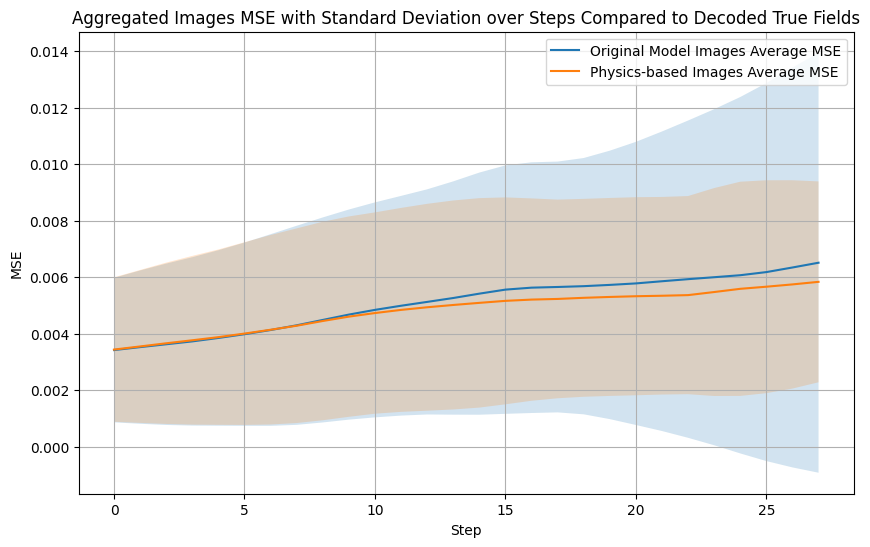

In [50]:
from sklearn.metrics import mean_squared_error

start_pos = 20
def rolling_forecast(model, initial_input, true_img):

    input_sequence = initial_input.reshape(1, 6, 512)  # Reshape to match LSTM input shape
    predictions = []
    mse_array = []
    ssim_array = []
    true_is = []
    for i in range(28):  # Since we're considering 5 steps at a time

        next_steps = model.predict(input_sequence)
        next_steps_2d = next_steps.reshape(-1, 512)

        predicted_image = decoder_layer(next_steps_2d)
        #true_image = decoder_layer(y_true[20+i].reshape(-1, 512))
        true_image = true_img[start_pos+i]

        predictions.extend(next_steps_2d)
        mse = np.mean((predicted_image - true_image) ** 2, axis=(1, 2, 3)).reshape(-1, 1)

        mse_array.append(mse)
        true_is.append(true_image)
        input_sequence = next_steps
    print(len(mse_array))
    return np.array(predictions), np.array(mse_array), np.array(true_is)
def prepare_test_data(x_val, y_val, i):
    x_test_cu = x_val[50 * (i):(50) * (i+1)-1,:, :]
    y_test_cu = y_val[50 * (i)+1:(50) * (i+1),:, :]
    return x_test_cu, y_test_cu


all_mse_orig = []
all_mse_phy = []
pred_orig_list = []
pred_phy_list = []

t_orig_list = []
t_phy_list = []
# 收集每个数据集的MSE
for i in range(15):
    x_test_cu, y_test_cu = prepare_test_data(x_val, true_img, i)
    initial_input = x_test_cu[start_pos]

    pred_orig, mse,to = rolling_forecast(original_model, initial_input, y_test_cu)
    pred_phy, mse_phy,tp = rolling_forecast(physical_model, initial_input, y_test_cu)

    average_mse_per_group = np.mean(mse, axis=1)
    average_mse_per_phy = np.mean(mse_phy, axis=1)

    all_mse_orig.append(average_mse_per_group)
    all_mse_phy.append(average_mse_per_phy)
    pred_orig = decoder_layer(pred_orig)
    pred_phy = decoder_layer(pred_phy)
    pred_orig_list.append(pred_orig)
    pred_phy_list.append(pred_phy)
    t_orig_list.append(to)
    t_phy_list.append(tp)

# 计算汇总的平均值和标准差
all_mse_orig = np.array(all_mse_orig)
all_mse_phy = np.array(all_mse_phy)

avg_mse_orig = np.mean(all_mse_orig, axis=0)
std_mse_orig = np.std(all_mse_orig, axis=0)

avg_mse_phy = np.mean(all_mse_phy, axis=0)
std_mse_phy = np.std(all_mse_phy, axis=0)


avg_mse_orig = np.asarray(avg_mse_orig).flatten()

std_mse_orig = np.asarray(std_mse_orig).flatten()
# 绘制汇总图表
plt.figure(figsize=(10, 6))
plt.plot(avg_mse_orig, label='Original Model Images Average MSE')
plt.fill_between(range(len(avg_mse_orig)),
                 avg_mse_orig - std_mse_orig,
                 avg_mse_orig + std_mse_orig,
                 alpha=0.2)
avg_mse_phy = np.asarray(avg_mse_phy).flatten()

std_mse_phy = np.asarray(std_mse_phy).flatten()
# Plot the average MSE for the physics-based model with shaded standard deviation area
plt.plot(avg_mse_phy, label='Physics-based Images Average MSE')
plt.fill_between(range(len(avg_mse_phy)), avg_mse_phy - std_mse_phy, avg_mse_phy + std_mse_phy, alpha=0.2)

plt.title('Aggregated Images MSE with Standard Deviation over Steps Compared to Decoded True Fields')
plt.xlabel('Step')
plt.ylabel('MSE')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


In [51]:
pred_orig_array = np.array(pred_orig_list).reshape(-1, 64, 64, 3)
pred_phy_array = np.array(pred_phy_list).reshape(-1, 64, 64, 3)
t_orig_array = np.array(t_orig_list).reshape(-1, 64, 64, 3)

In [52]:
from skimage.metrics import structural_similarity as compare_ssim
from skimage.metrics import mean_squared_error

# Assuming pred_orig_array, pred_phy_array, and t_orig_array are your image arrays

# Compute SSIM
ssim_orig = compare_ssim(pred_orig_array, t_orig_array, multichannel=True)
ssim_phy = compare_ssim(pred_phy_array, t_orig_array, multichannel=True)

print("SSIM (pred_orig_array to t_orig_array):", ssim_orig)
print("SSIM (pred_phy_array to t_orig_array):", ssim_phy)

# Compute MSE
mse_orig = mean_squared_error(pred_orig_array, t_orig_array)
mse_phy = mean_squared_error(pred_phy_array, t_orig_array)

print("MSE (pred_orig_array to t_orig_array):", mse_orig)
print("MSE (pred_phy_array to t_orig_array):", mse_phy)


<ipython-input-52-c7a67793b4c5>:7: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_orig = compare_ssim(pred_orig_array, t_orig_array, multichannel=True)
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)
<ipython-input-52-c7a67793b4c5>:8: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_phy = compare_ssim(pred_phy_array, t_orig_array, multichannel=True)


SSIM (pred_orig_array to t_orig_array): 0.779835
SSIM (pred_phy_array to t_orig_array): 0.7707677
MSE (pred_orig_array to t_orig_array): 0.005078536391845374
MSE (pred_phy_array to t_orig_array): 0.004815023031039188


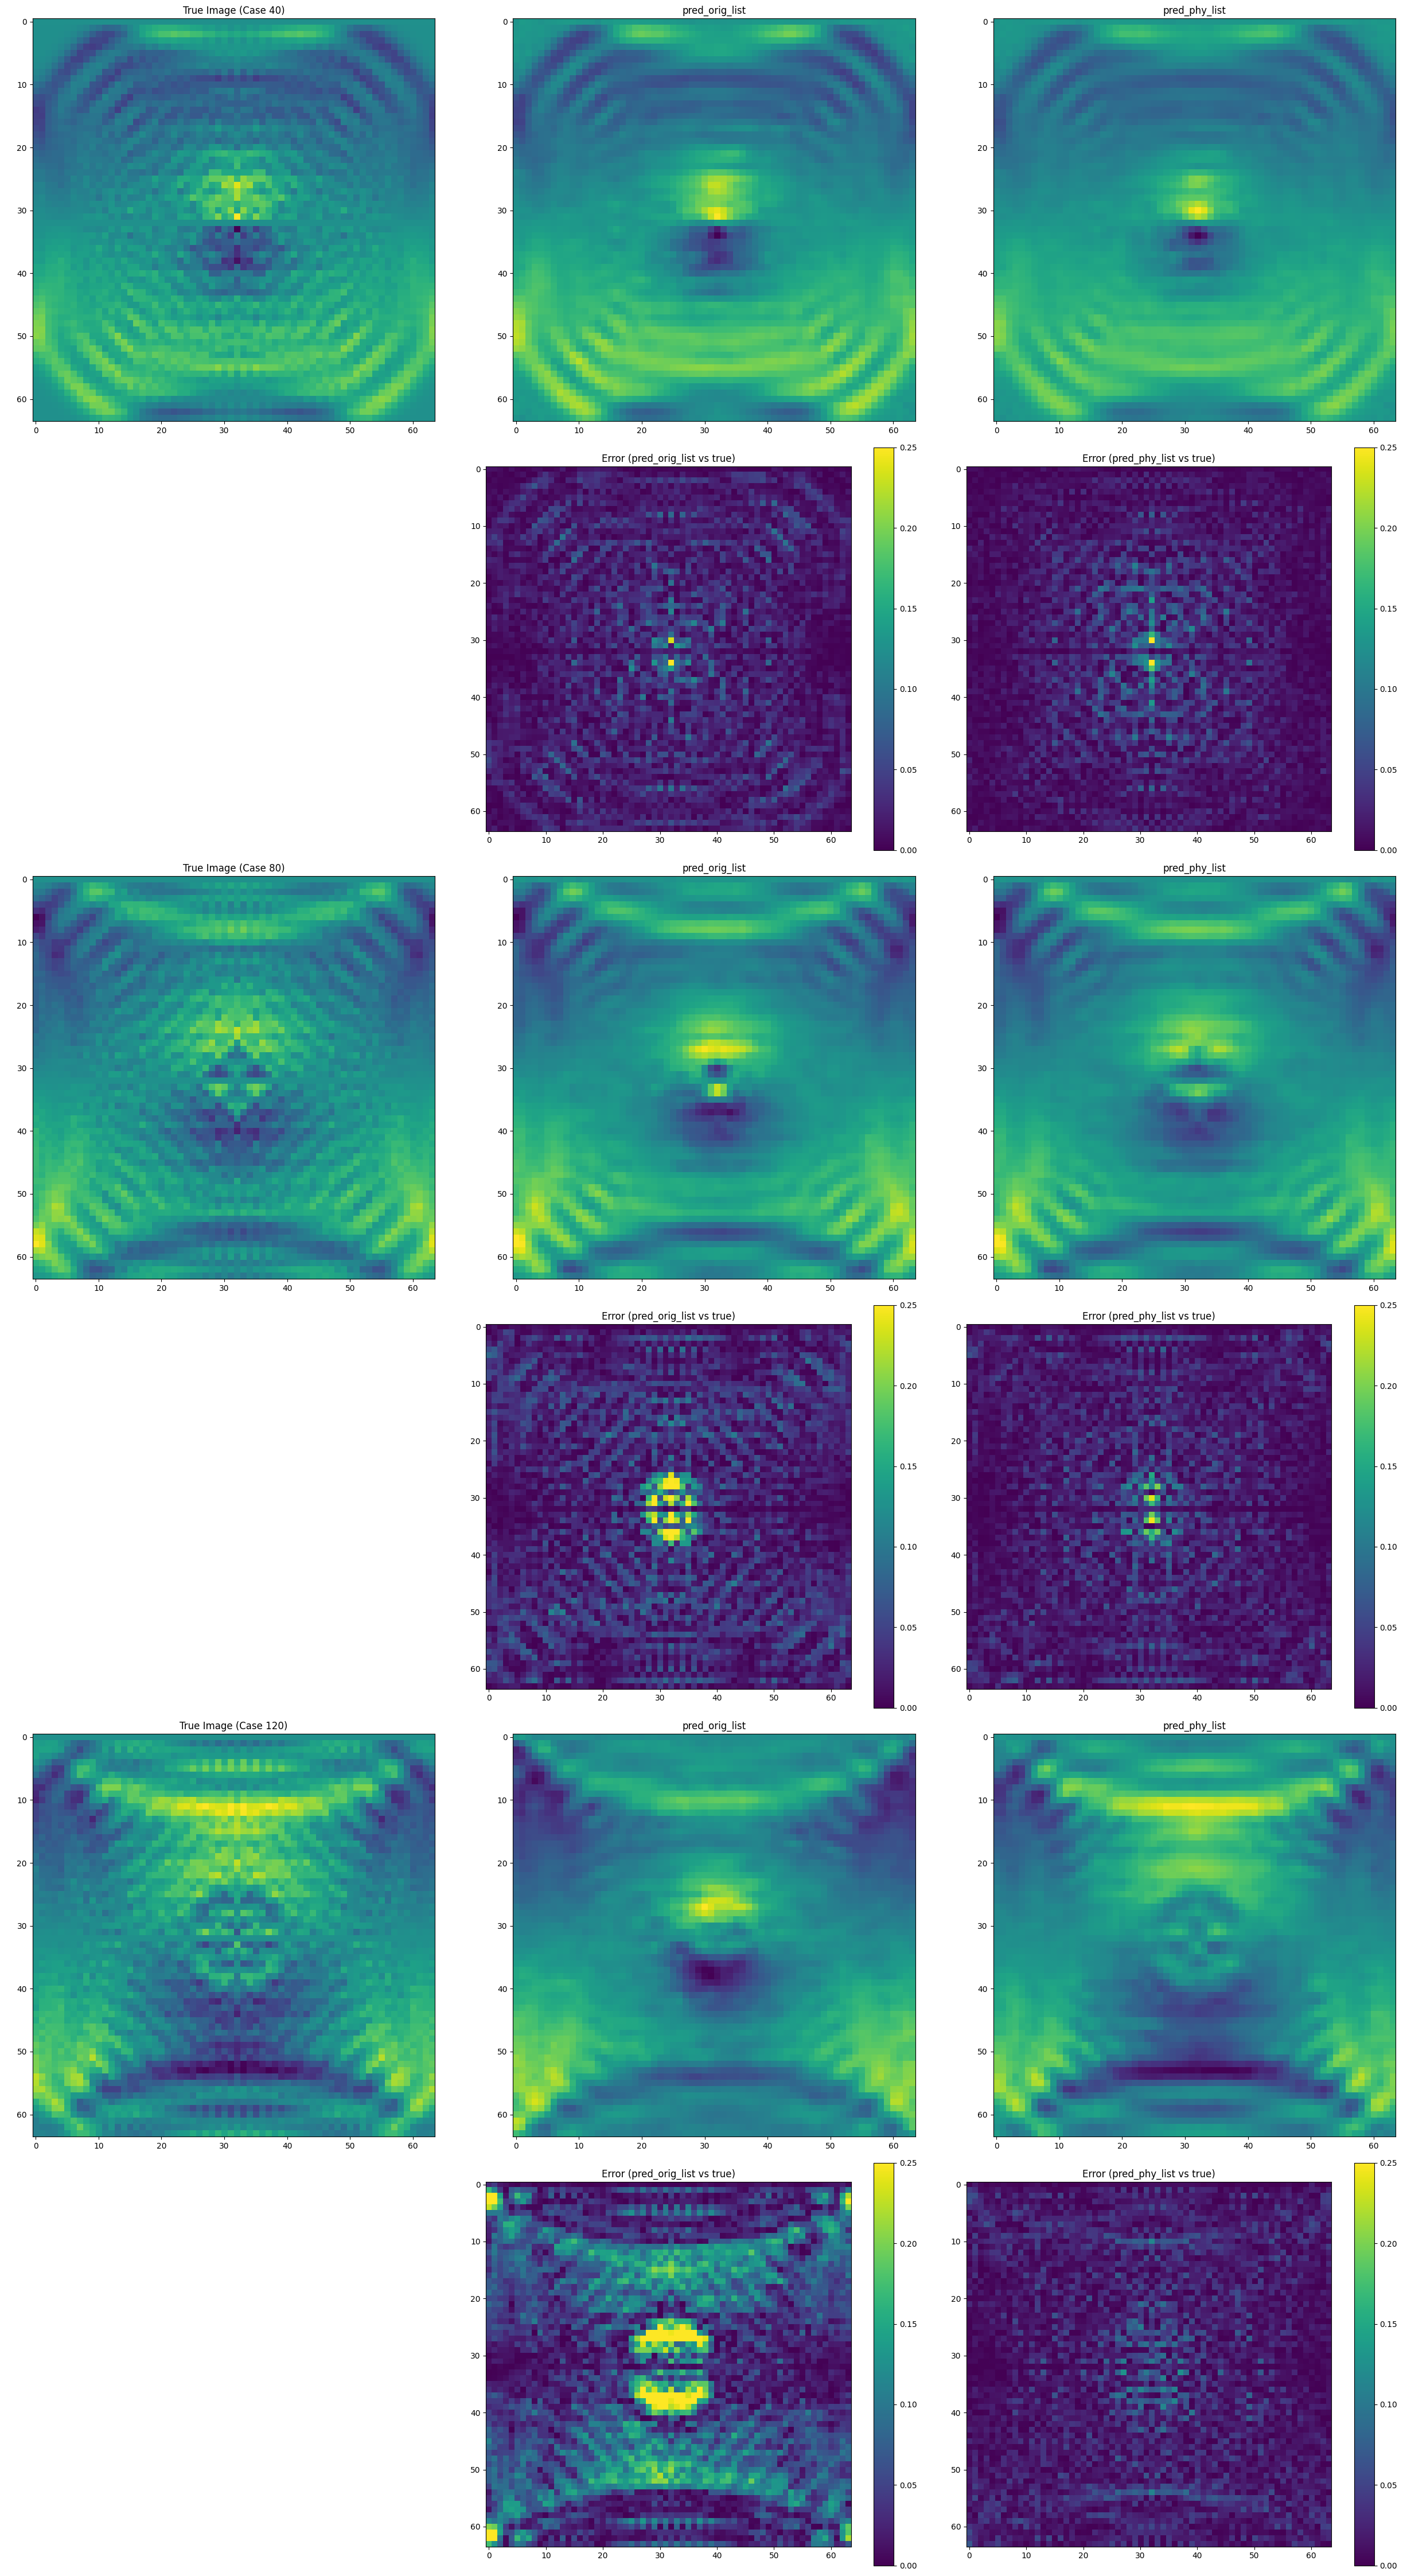

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming t_orig_array, pred_orig_array, and pred_phy_array are defined elsewhere
pred_orig_array = np.array(pred_orig_list).reshape(-1, 64, 64, 3)
pred_phy_array = np.array(pred_phy_list).reshape(-1, 64, 64, 3)
t_orig_array = np.array(t_orig_list).reshape(-1, 64, 64, 3)

# Cases to plot
d = 168*0
cases = [40+d, 80+d, 120+d]

# Plotting images and error plots for each case
fig, axes = plt.subplots(len(cases) * 2, 3, figsize=(25, 45))

for idx, case in enumerate(cases):
    # Plotting true image
    axes[idx * 2, 0].imshow(t_orig_array[case, :, :, 0])
    axes[idx * 2, 0].set_title(f'True Image (Case {case})')

    # Plotting pred_orig_list
    axes[idx * 2, 1].imshow(pred_orig_array[case, :, :, 0])
    axes[idx * 2, 1].set_title('pred_orig_list')

    # Plotting pred_phy_list
    axes[idx * 2, 2].imshow(pred_phy_array[case, :, :, 0])
    axes[idx * 2, 2].set_title('pred_phy_list')

    # Plotting NaN (if needed)
    axes[idx * 2 + 1, 0].axis('off')

    # Plotting error between pred_orig_list and t_orig_array
    error_orig = np.abs(pred_orig_array - t_orig_array)
    im1 = axes[idx * 2 + 1, 1].imshow(error_orig[case, :, :, 0], vmin=0, vmax=0.25)
    axes[idx * 2 + 1, 1].set_title('Error (pred_orig_list vs true)')
    fig.colorbar(im1, ax=axes[idx * 2 + 1, 1])

    # Plotting error between pred_phy_list and t_orig_array
    error_phy = np.abs(pred_phy_array - t_orig_array)
    im2 = axes[idx * 2 + 1, 2].imshow(error_phy[case, :, :, 0], vmin=0, vmax=0.25)
    axes[idx * 2 + 1, 2].set_title('Error (pred_phy_list vs true)')
    fig.colorbar(im2, ax=axes[idx * 2 + 1, 2])

plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 22ms/step


/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


1/1 [==============================] - 0s 20ms/step
finish!
1/1 [==============================] - 0s 22ms/step
finish!
1/1 [==============================] - 0s 22ms/step
finish!
1/1 [==============================] - 0s 20ms/step
finish!
1/1 [==============================] - 0s 22ms/step
finish!
1/1 [==============================] - 0s 19ms/step
finish!
1/1 [==============================] - 0s 19ms/step
finish!
1/1 [==============================] - 0s 20ms/step
finish!
1/1 [==============================] - 0s 19ms/step
finish!
1/1 [==============================] - 0s 20ms/step
finish!
1/1 [==============================] - 0s 20ms/step
finish!
1/1 [==============================] - 0s 19ms/step
finish!
1/1 [==============================] - 0s 20ms/step
finish!
1/1 [==============================] - 0s 24ms/step
finish!
1/1 [==============================] - 0s 23ms/step
finish!
1/1 [==============================] - 0s 23ms/step


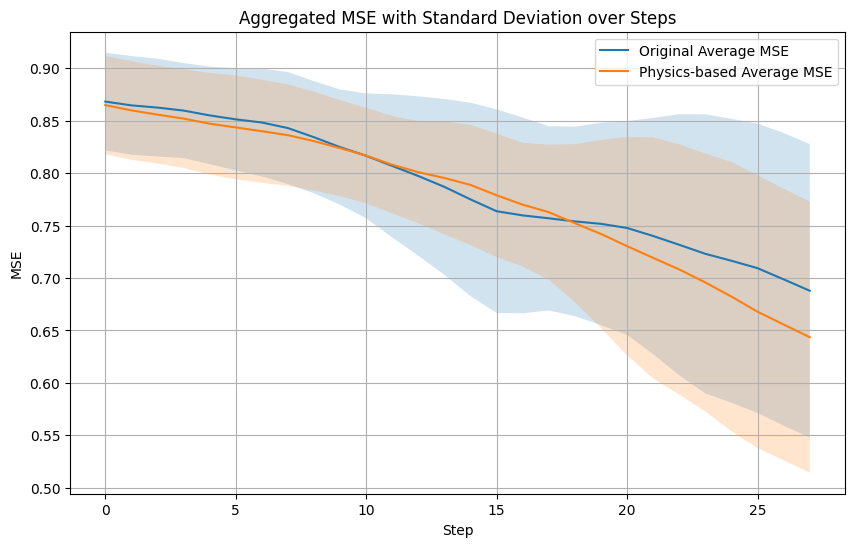

In [ ]:
from skimage.metrics import structural_similarity as ssim
start_pos = 20
def rolling_forecast(model, initial_input, true_img):

    input_sequence = initial_input.reshape(1, 6, 512)  # Reshape to match LSTM input shape
    predictions = []
    mse_array = []
    ssim_array = []

    for i in range(28):  # Considering 5 steps at a time
        next_steps = model.predict(input_sequence)
        next_steps_2d = next_steps.reshape(-1, 512)

        predicted_image = decoder_layer(next_steps_2d)
        true_image = true_img[start_pos+i]

        predictions.extend(next_steps_2d)
        mse = np.mean((predicted_image - true_image) ** 2, axis=(1, 2, 3)).reshape(-1, 1)
        mse_array.append(mse)

        predicted_image_np = np.array(predicted_image[:5])
        true_image_np = np.array(true_image[:5])
        ssim_value = ssim(predicted_image_np, true_image_np, win_size=5, channel_axis=-1)
        ssim_array.append(ssim_value)


        input_sequence = next_steps

    return np.array(predictions), np.array(mse_array), np.array(ssim_array)


def prepare_test_data(x_val, y_val, i):
    x_test_cu = x_val[50 * (i):(50) * (i+1)-1,:, :]
    y_test_cu = y_val[50 * (i)+1:(50) * (i+1),:, :]
    return x_test_cu, y_test_cu

all_ssim_orig = []
all_ssim_phy = []

# 收集每个数据集的MSE
for i in range(15):
    x_test_cu, y_test_cu = prepare_test_data(x_val, true_img, i)
    initial_input = x_test_cu[start_pos]
    _, mse_phy,ssim_phy = rolling_forecast(physical_model, initial_input, y_test_cu)
    print('finish!')
    _, mse,ssim_n = rolling_forecast(original_model, initial_input, y_test_cu)
    average_ssim_per_group = ssim_n
    average_ssim_per_phy = ssim_phy

    all_ssim_orig.append(average_ssim_per_group)
    all_ssim_phy.append(average_ssim_per_phy)

# 计算汇总的平均值和标准差
all_ssim_orig = np.array(all_ssim_orig)
all_ssim_phy = np.array(all_ssim_phy)

avg_ssim_orig = np.mean(all_ssim_orig, axis=0)
std_ssim_orig = np.std(all_ssim_orig, axis=0)

avg_ssim_phy = np.mean(all_ssim_phy, axis=0)
std_ssim_phy = np.std(all_ssim_phy, axis=0)


avg_ssim_orig = np.asarray(avg_ssim_orig).flatten()

std_ssim_orig = np.asarray(std_ssim_orig).flatten()
# 绘制汇总图表
plt.figure(figsize=(10, 6))
plt.plot(avg_ssim_orig, label='Original Average MSE')
plt.fill_between(range(len(avg_ssim_orig)), avg_ssim_orig - std_ssim_orig, avg_ssim_orig + std_ssim_orig, alpha=0.2)

avg_mse_phy = np.asarray(avg_ssim_phy).flatten()

std_mse_phy = np.asarray(std_ssim_phy).flatten()
plt.plot(avg_mse_phy, label='Physics-based Average MSE')
plt.fill_between(range(len(avg_ssim_phy)), avg_ssim_phy - std_ssim_phy, avg_ssim_phy + std_ssim_phy, alpha=0.2)

plt.title('Aggregated MSE with Standard Deviation over Steps')
plt.xlabel('Step')
plt.ylabel('MSE')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [ ]:
avga_mse_orig = np.asarray(avg_mse_orig).flatten()


stda_mse_orig = np.asarray(std_mse_orig).flatten()

avga_mse_orig

array([4.2382901e-05, 1.1790522e-04, 3.2018815e-04, 6.3423603e-04,
       1.0602331e-03, 1.4870766e-03, 1.8513675e-03, 2.1741486e-03,
       2.4804852e-03, 2.8251836e-03, 3.2050437e-03, 3.6373874e-03,
       4.0893168e-03, 4.5292154e-03, 4.9836487e-03, 5.4067159e-03,
       5.7724686e-03, 6.0451841e-03, 6.2871338e-03, 6.5276194e-03,
       6.7717168e-03, 7.0005725e-03, 7.2579584e-03, 7.5217932e-03,
       7.6814634e-03, 7.7727605e-03, 7.8015942e-03, 7.8492956e-03,
       7.9023633e-03, 7.9700779e-03, 8.0354353e-03, 8.2402360e-03,
       8.4105413e-03, 8.5240128e-03, 8.6659091e-03, 8.8487472e-03,
       9.0543572e-03, 9.2315422e-03, 9.4390856e-03, 9.5561324e-03,
       9.6857566e-03, 9.7952681e-03, 9.9248355e-03, 1.0027251e-02,
       1.0068694e-02, 1.0056263e-02, 1.0053009e-02, 1.0099294e-02,
       1.0206519e-02], dtype=float32)

In [ ]:
def rolling_forecast(model, initial_input, y_true):
    input_sequence = initial_input.reshape(1, 6, 512)  # Reshape to match LSTM input shape
    predictions = []
    mse_array = []
    ssim_array = []

    for i in range(len(y_true)):
        next_steps = model.predict(input_sequence)
        next_steps_2d = next_steps.reshape(-1, 512)

        predicted_image = decoder_layer(next_steps_2d)
        true_image = decoder_layer(y_true[i].reshape(-1, 512))


        predictions.extend(predicted_image)

        mse = np.mean((predicted_image - true_image) ** 2)
        mse_array.append(mse)

        ssim_value = ssim(predicted_image.numpy(), true_image.numpy(), win_size=5,multichannel=True)
        ssim_array.append(ssim_value)

        input_sequence = next_steps

    return np.array(predictions), np.array(mse_array), np.array(ssim_array)


def prepare_test_data(x_val, y_val, i):
    x_test_cu = x_val[300 * (i):(300-6) * (i+1),:, :]
    y_test_cu = y_val[300 * (i):(300-6) * (i+1),:, :]
    return x_test_cu, y_test_cu


all_mse_orig = []
all_mse_phy = []

all_ssim_orig = []
all_ssim_phy = []

# 收集每个数据集的MSE
for i in range(15):
    x_test_cu, y_test_cu = prepare_test_data(x_val, y_val, i)
    initial_input = x_test_cu[0]

    _, mse, ssim_orig = rolling_forecast(original_model, initial_input, y_test_cu)  # Assuming decoder_layer is passed here
    _, mse_phy, ssim_phy = rolling_forecast(physical_model, initial_input, y_test_cu)
    print(mse)
    # Ensure mse and ssim arrays are processed correctly
    all_mse_orig.append(np.mean(mse),axis = 0)
    print(all_mse_orig)
    all_mse_phy.append(np.mean(mse_phy),axis = 0)

    all_ssim_orig.append(np.mean(ssim_orig))
    all_ssim_phy.append(np.mean(ssim_phy))


import numpy as np
import matplotlib.pyplot as plt

# Assuming all_mse_orig and all_mse_phy have been populated correctly before this block
all_mse_orig = np.array(all_mse_orig)
all_mse_phy = np.array(all_mse_phy)

# Calculate the average and standard deviation of MSE for both original and physics-based models
avg_mse_orig = np.mean(all_mse_orig, axis=0)
std_mse_orig = np.std(all_mse_orig, axis=0)

avg_mse_phy = np.mean(all_mse_phy, axis=0)
std_mse_phy = np.std(all_mse_phy, axis=0)

# Assuming all_mse_orig and all_mse_phy have been populated correctly before this block
all_ssim_orig = np.array(all_ssim_orig)
all_ssim_phy = np.array(all_ssim_phy)

# Calculate the average and standard deviation of MSE for both original and physics-based models
avg_ssim_orig = np.mean(all_ssim_orig, axis=0)
std_ssim_orig = np.std(all_ssim_orig, axis=0)

avg_ssim_phy = np.mean(all_ssim_phy, axis=0)
std_ssim_phy = np.std(all_ssim_phy, axis=0)

# Plotting the aggregated MSE along with the standard deviation for visual comparison
plt.figure(figsize=(10, 6))

# Original model MSE and its standard deviation
plt.plot(avg_mse_orig, label='Original Average MSE', color='blue')
plt.fill_between(range(len(avg_mse_orig)), avg_mse_orig - std_mse_orig, avg_mse_orig + std_mse_orig, color='blue', alpha=0.2)

# Physics-based model MSE and its standard deviation
plt.plot(avg_mse_phy, label='Physics-based Average MSE', color='red')
plt.fill_between(range(len(avg_mse_phy)), avg_mse_phy - std_mse_phy, avg_mse_phy + std_mse_phy, color='red', alpha=0.2)

plt.title('Aggregated MSE with Standard Deviation over Steps')
plt.xlabel('Step')
plt.ylabel('MSE')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


1/1 [==============================] - 0s 21ms/step


<ipython-input-18-9e5bdac10a5a>:20: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_value = ssim(predicted_image.numpy(), true_image.numpy(), win_size=5,multichannel=True)


1/1 [==============================] - 0s 23ms/step


TypeError: list.append() takes no keyword arguments

In [ ]:
all_ssim_orig

array([0.4779334 , 0.51065266, 0.5565783 , 0.4586153 , 0.48087123,
       0.5333965 , 0.6013341 , 0.5260963 , 0.68432605, 0.5930675 ,
       0.5323044 , 0.57394665, 0.72920406, 0.6631779 ], dtype=float32)

In [ ]:
# Plotting the aggregated SSIM along with the standard deviation for visual comparison
plt.figure(figsize=(10, 6))

# Original model SSIM and its standard deviation
plt.plot(avg_ssim_orig, label='Original Average SSIM', color='blue')
plt.fill_between(range(len(avg_ssim_orig)), avg_ssim_orig - std_ssim_orig, avg_ssim_orig + std_ssim_orig, color='blue', alpha=0.2)

# Physics-based model SSIM and its standard deviation
plt.plot(avg_ssim_phy, label='Physics-based Average SSIM', color='red')
plt.fill_between(range(len(avg_ssim_phy)), avg_ssim_phy - std_ssim_phy, avg_ssim_phy + std_ssim_phy, color='red', alpha=0.2)

plt.title('Aggregated SSIM with Standard Deviation over Steps')
plt.xlabel('Step')
plt.ylabel('SSIM')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


In [ ]:
predictions

NameError: name 'predictions' is not defined

In [ ]:

history_dict = {key: np.array(value).tolist() for key, value in real_phy_history.history.items()}

# Save the training history as JSON
history_path = "/content/drive/MyDrive/Physics/Physics/MOdel_para/LSTM/Original Model/15steps/orig_training_history.json"
with open(history_path, 'w') as file:
    json.dump(history_dict, file)

# Save the final model
final_model_path = "/content/drive/MyDrive/Physics/Physics/MOdel_para/LSTM/Original Model/15steps/orig_final_model.h5"
real_phy_model.save(final_model_path)

# Optionally, save the model architecture as a JSON file
model_json = real_phy_model.to_json()
with open("/content/drive/MyDrive/Physics/Physics/MOdel_para/LSTM/Original Model/15steps/orig_model_architecture.json", "w") as json_file:
    json_file.write(model_json)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
pip install keras_tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 4.8 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt

def build_physical_model(hp):
    n_step = 6
    feature_dim = 512

    # Define the input layer
    inputs = Input(shape=(n_step, feature_dim))

    # LSTM layer
    x = layers.LSTM(32, return_sequences=True)(inputs)

    # RepeatVector layer to match the input shape of the subsequent LSTM layer
    x = layers.RepeatVector(n_step)(x)

    # Second LSTM layer
    x = layers.LSTM(32, return_sequences=True)(x)

    # TimeDistributed layer to apply a Dense layer to each time step separately
    x = layers.TimeDistributed(layers.Dense(feature_dim))(x)

    # Activation layer
    outputs = layers.Activation('relu')(x)


    # Hyperparameters for custom loss function weights
    alpha = hp.Float('alpha', min_value=1e-10, max_value=1e-7, sampling='log')
    beta = hp.Float('beta', min_value=1e-5, max_value=1e-2, sampling='log')

    # Custom loss function incorporating alpha and beta
    def custom_loss(y_true, y_pred):
        mse_loss = tf.keras.losses.mean_squared_error(y_true, y_pred)
        energy_restriction = calculate_relative_energy_error(y_true, y_pred)  # Assumes definition elsewhere
        mass_conservation_loss_value = calculate_mass_conservation_loss(y_true, y_pred)  # Assumes definition elsewhere
        return mse_loss + alpha * energy_restriction + beta * mass_conservation_loss_value

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.05),
        loss=custom_loss,
        metrics=['mean_squared_error', calculate_relative_energy_error, calculate_mass_conservation_loss]
    )

    return model

# Define the tuner
tuner = kt.Hyperband(
    build_physical_model,
    objective='val_mean_squared_error',
    max_epochs=50,
    factor=3,
    directory='/content/drive/MyDrive/Physics/Physics/MOdel_para/LSTM/0215-Orig/Tuner',
    project_name='hyperband_physical_model_optimization_6step_again_a'
)

# Assuming x_train, y_train, x_val, and y_val are predefined datasets
tuner.search(
    x_train, y_train,
    epochs=50,
    validation_data=(x_val, y_val)
)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal alpha weight for energy restriction is {best_hps.get('alpha')}.
The optimal beta weight for mass conservation is {best_hps.get('beta')}.
""")

# Optionally, retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]



ValueError: Input 0 of layer "repeat_vector_2" is incompatible with the layer: expected ndim=2, found ndim=3. Full shape received: (None, 6, 32)

In [ ]:
# Fetch the best hyperparameters.
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal energy restriction weight is {best_hps.get('energy_restriction_weight')}.
The optimal mass conservation weight is {best_hps.get('mass_conservation_weight')}.
""")

# Optionally, you can also retrieve the best model directly.
best_model = tuner.get_best_models(num_models=1)[0]


The optimal energy restriction weight is 1.9473369534115483e-09.
The optimal mass conservation weight is 0.00030794170455443216.



### A step

In [ ]:
import matplotlib.pyplot as plt

def plot_metric(history1, history2, metric, title, ylabel):
    """
    Plot a specified metric from the training histories.
    """
    histories = [history1, history2]
    labels = ['orig_history', 'history']
    colors = ['b', 'r']

    for i, history in enumerate(histories):
        values = history.history[metric]
        val_values = history.history[f"val_{metric}"]

        epochs = range(1, len(values) + 1)

        # Plot training values
        plt.plot(epochs, values, f'{colors[i]}o-', label=f'Training {metric} - {labels[i]}')
        # Plot validation values
        plt.plot(epochs, val_values, f'{colors[i]}--', label=f'Validation {metric} - {labels[i]}')

    # Setting plot title and labels
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)
    plt.legend()

    plt.show()
import matplotlib.pyplot as plt

def plot_metric(history1, history2, metric, title, ylabel):
    """
    Plot a specified metric from the training histories.
    """
    plt.figure(figsize=(12, 6))  # Set figure size
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)  # Add a grid for better readability
    plt.title(title, fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel(ylabel, fontsize=14)

    histories = [history1, history2]
    labels = ['origin', 'Physical Constraint']
    colors = ['b', 'r']

    for i, history in enumerate(histories):
        values = history.history[metric]
        val_values = history.history[f"val_{metric}"]

        epochs = range(1, len(values) + 1)

        # Plot training values with increased line width
        plt.plot(epochs, values, f'{colors[i]}o-', label=f'Training {metric} - {labels[i]}', linewidth=2)
        # Plot validation values with increased line width
        plt.plot(epochs, val_values, f'{colors[i]}--', label=f'Validation {metric} - {labels[i]}', linewidth=2)

    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()


# Plotting MSE
plot_metric(phy_history, real_phy_history, 'mean_squared_error', 'MSE over Epochs', 'MSE')

# Plotting calculate_relative_energy_error
plot_metric(phy_history, real_phy_history, 'calculate_relative_energy_error', 'Relative Energy Error over Epochs', 'Relative Energy Error')



NameError: name 'phy_history' is not defined

In [ ]:
# 初始化NumPy数组而不是列表
all_mse_orig = np.zeros(15)
all_mse_phy = np.zeros(15)

# 收集每个数据集的MSE
for i in range(14):
    mse_orig, mse_phy = evaluate_models(i, x_val, y_val, orig_model, real_model, decoder_layer)
    all_mse_orig[i] = mse_orig
    all_mse_phy[i] = mse_phy

# 计算汇总的平均值和标准差
avg_mse_orig = np.mean(all_mse_orig)
std_mse_orig = np.std(all_mse_orig)

avg_mse_phy = np.mean(all_mse_phy)
std_mse_phy = np.std(all_mse_phy)


plt.figure(figsize=(10, 6))

# 使用原始数组绘制平均值和标准差
plt.plot(all_mse_orig, label='Original MSE')
plt.fill_between(range(len(all_mse_orig)), all_mse_orig - std_mse_orig, all_mse_orig + std_mse_orig, alpha=0.2)

plt.plot(all_mse_phy, label='Physics-based MSE')
plt.fill_between(range(len(all_mse_phy)), all_mse_phy - std_mse_phy, all_mse_phy + std_mse_phy, alpha=0.2)

plt.title('MSE and Standard Deviation')
plt.xlabel('Dataset Index')
plt.ylabel('MSE')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
ste = 6
# Load models with specified custom objects
original_model_path = '/content/drive/MyDrive/Physics/Physics/MOdel_para/LSTM/0215-Orig/original_model.h5'
physical_model_path = '/content/drive/MyDrive/Physics/Physics/MOdel_para/LSTM/0215-Orig/physical_model.h5'

original_model = tf.keras.models.load_model(original_model_path, custom_objects={
    'calculate_relative_energy_error': calculate_relative_energy_error,
    'calculate_mass_conservation_loss': calculate_mass_conservation_loss
})

physical_model = tf.keras.models.load_model(physical_model_path, custom_objects={
    'custom_loss': custom_loss,
    'calculate_relative_energy_error': calculate_relative_energy_error,
    'calculate_mass_conservation_loss': calculate_mass_conservation_loss
})

def mse(actual, pred):
    return np.square(np.subtract(actual,pred)).mean()

def rolling_forecast(model, initial_input, y_true, steps_to_predict):
    input_sequence = initial_input.reshape(1, 6, 512)  # Reshape to match LSTM input shape
    predictions = []
    mse_array = []

    for i in range(steps_to_predict // ste):  # Since we're considering 5 steps at a time
        next_steps = model.predict(input_sequence)
        print(next_steps.shape)
        next_steps_2d = next_steps.reshape(6, 512)
        predictions.extend(next_steps_2d)

        mse_pre=mse(y_true[6*(i-1), 6*i],next_steps_2d)
        mse_array.append(mse_pre)

        # Update the input sequence for the next prediction
        input_sequence = next_steps#np.concatenate((input_sequence[:, 10:, :], next_steps), axis=1)

    return np.array(predictions), np.array(mse_array)

def prepare_test_data(x_val, y_val, i):
    x_test_cu = x_val[300 * (i):(300-6) * (i+1), 0, :]
    y_test_cu = y_val[300 * (i):(300-6) * (i+1), 0, :]
    return x_test_cu, y_test_cu

def evaluate_models(i, x_val, y_val, orig_model, real_model):
    x_test_cu, y_test_cu = prepare_test_data(x_val, y_val, i)
    initial_input = x_test_cu[:ste]

    _, mse = rolling_forecast(orig_model, initial_input, y_test_cu, len(y_test_cu))
    _, mse_phy = rolling_forecast(real_model, initial_input, y_test_cu, len(y_test_cu))

    return np.mean(mse), np.mean(mse_phy)

all_mse_orig = []
all_mse_phy = []

# 收集每个数据集的MSE
for i in range(15):
    x_test_cu, y_test_cu = prepare_test_data(x_val, y_val, i)
    initial_input = x_test_cu[:ste]

    _, mse = rolling_forecast(original_model, initial_input, y_test_cu, len(y_test_cu))
    _, mse_phy = rolling_forecast(physical_model, initial_input, y_test_cu, len(y_test_cu))

    average_mse_per_group = np.mean(mse)
    average_mse_per_phy = np.mean(mse_phy)

    all_mse_orig.append(average_mse_per_group)
    all_mse_phy.append(average_mse_per_phy)

# 计算汇总的平均值和标准差
all_mse_orig = np.array(all_mse_orig)
all_mse_phy = np.array(all_mse_phy)

avg_mse_orig = np.mean(all_mse_orig, axis=0)
std_mse_orig = np.std(all_mse_orig, axis=0)

avg_mse_phy = np.mean(all_mse_phy, axis=0)
std_mse_phy = np.std(all_mse_phy, axis=0)

# 绘制汇总图表
plt.figure(figsize=(10, 6))
plt.plot(avg_mse_orig, label='Original Average MSE')
plt.fill_between(range(len(int(avg_mse_orig))), avg_mse_orig - std_mse_orig, avg_mse_orig + std_mse_orig, alpha=0.2)

plt.plot(avg_mse_phy, label='Physics-based Average MSE')
plt.fill_between(range(len(int(avg_mse_phy))), avg_mse_phy - std_mse_phy, avg_mse_phy + std_mse_phy, alpha=0.2)

plt.title('Aggregated MSE with Standard Deviation over Steps')
plt.xlabel('Step')
plt.ylabel('MSE')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


1/1 [==============================] - 1s 739ms/step
(1, 6, 512)
1/1 [==============================] - 0s 21ms/step
(1, 6, 512)
1/1 [==============================] - 0s 22ms/step
(1, 6, 512)
1/1 [==============================] - 0s 23ms/step
(1, 6, 512)
1/1 [==============================] - 0s 21ms/step
(1, 6, 512)
1/1 [==============================] - 0s 20ms/step
(1, 6, 512)
1/1 [==============================] - 0s 23ms/step
(1, 6, 512)
1/1 [==============================] - 0s 22ms/step
(1, 6, 512)
1/1 [==============================] - 0s 22ms/step
(1, 6, 512)
1/1 [==============================] - 0s 22ms/step
(1, 6, 512)
1/1 [==============================] - 0s 21ms/step
(1, 6, 512)
1/1 [==============================] - 0s 23ms/step
(1, 6, 512)
1/1 [==============================] - 0s 22ms/step
(1, 6, 512)
1/1 [==============================] - 0s 21ms/step
(1, 6, 512)
1/1 [==============================] - 0s 21ms/step
(1, 6, 512)
1/1 [==============================] - 

TypeError: 'numpy.ndarray' object is not callable

In [ ]:
avg_mse_orig

nan

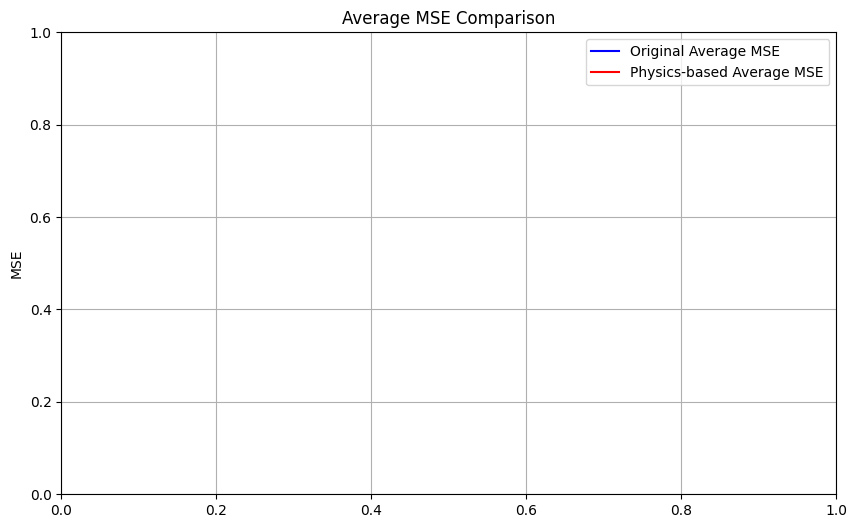

In [ ]:
# 绘制汇总图表
plt.figure(figsize=(10, 6))
plt.axhline(y=avg_mse_orig, label='Original Average MSE', color='blue')
plt.axhline(y=avg_mse_phy, label='Physics-based Average MSE', color='red')

plt.title('Average MSE Comparison')
plt.ylabel('MSE')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()



1/1 [==============================] - 0s 22ms/step
(15, 64, 64, 3)
1/1 [==============================] - 0s 23ms/step
(15, 64, 64, 3)
1/1 [==============================] - 0s 21ms/step
(15, 64, 64, 3)
1/1 [==============================] - 0s 20ms/step
(15, 64, 64, 3)
1/1 [==============================] - 0s 20ms/step
(15, 64, 64, 3)
1/1 [==============================] - 0s 22ms/step
(15, 64, 64, 3)
1/1 [==============================] - 0s 20ms/step
(15, 64, 64, 3)
1/1 [==============================] - 0s 21ms/step
(15, 64, 64, 3)
1/1 [==============================] - 0s 22ms/step
(15, 64, 64, 3)
1/1 [==============================] - 0s 22ms/step
(15, 64, 64, 3)
1/1 [==============================] - 0s 21ms/step
(15, 64, 64, 3)
1/1 [==============================] - 0s 22ms/step
(15, 64, 64, 3)
1/1 [==============================] - 0s 20ms/step
(15, 64, 64, 3)
1/1 [==============================] - 0s 21ms/step
(15, 64, 64, 3)
1/1 [==============================] - 0s 20ms/s

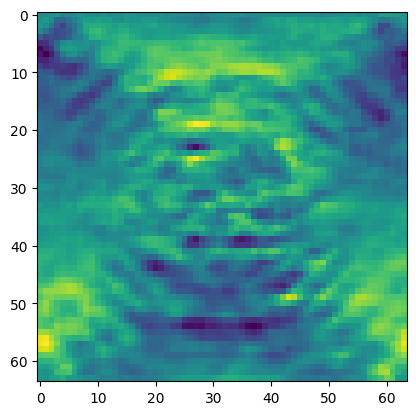

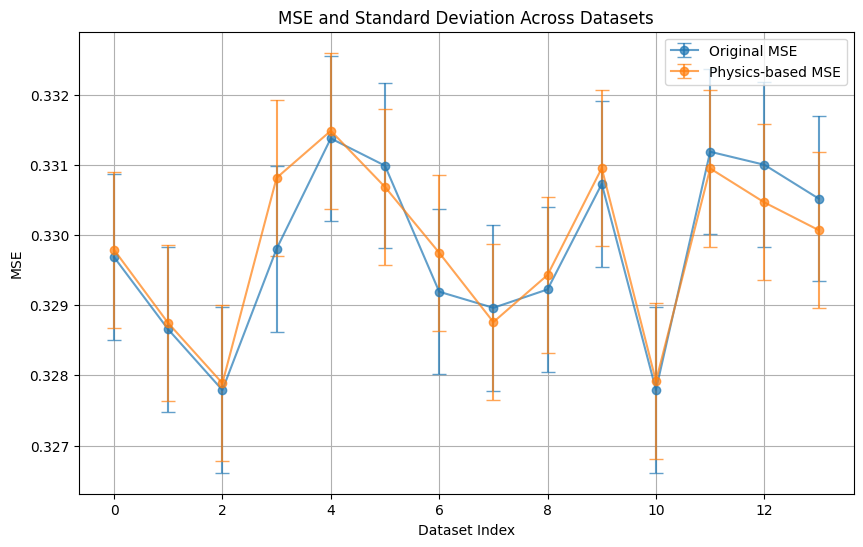

In [ ]:
def rolling_forecast(model, initial_input, true_images, steps_to_predict, decoder_layer, ste):
    input_sequence = initial_input.reshape(1, -1, 512)  # Ensure this matches the LSTM input shape
    predictions = []
    mse_array = []

    for i in range(steps_to_predict // ste):
        next_steps = model.predict(input_sequence)

        # Decode the LSTM output to images
        y_pred_images = decoder_layer(next_steps.reshape(-1, 512))  # Ensure decoder_layer accepts the correct shape
        #print(y_pred_images.shape)
        # Accumulate predictions
        predictions.extend(y_pred_images)
        plt.imshow(y_pred_images[5,:,:,0])
        # Slice true_images to match the current batch from predictions
        true_batch = true_images[i * ste:(i + 1) * ste]  # Adjusted slicing
        print(true_batch.shape)
        # Compute MSE for the current batch of images
        mse = np.mean((y_pred_images - true_batch)**2)
        mse_array.append(mse)

        # Prepare input_sequence for the next prediction
        # This line needs adjustment based on how your model is supposed to take the next input
        input_sequence = next_steps

    return np.array(predictions), np.array(mse_array)

def prepare_test_data(x_val, y_val, i):
    x_test_cu = x_val[285 + 300 * i:285 + 300 * i + 285, 0, :]
    y_test_cu = y_val[285 + 300 * i:285 + 300 * i + 285]
    return x_test_cu, y_test_cu
def evaluate_models(i, x_val, y_val, orig_model, real_model, decoder_layer, ste):
    x_test_cu, y_test_images = prepare_test_data(x_val, y_val, i)
    initial_input = x_test_cu[:ste]  # Ensure this matches the expected input shape

    mse_orig, _ = rolling_forecast(orig_model, initial_input, y_test_images, len(y_test_images), decoder_layer, ste)
    mse_phy, _ = rolling_forecast(real_model, initial_input, y_test_images, len(y_test_images), decoder_layer, ste)

    return np.mean(mse_orig), np.mean(mse_phy)
ste = 15
num_datasets = 14  # Adjust this based on the actual number of datasets you have

# Initialize arrays to hold the MSE values for each dataset
all_mse_orig = np.zeros(num_datasets)
all_mse_phy = np.zeros(num_datasets)

# Loop over each dataset, evaluate models, and store MSE
for i in range(num_datasets):
    mse_orig, mse_phy = evaluate_models(i, x_val, true_test, orig_model, real_model, decoder_layer, ste)
    all_mse_orig[i] = mse_orig
    all_mse_phy[i] = mse_phy

# Compute the average and standard deviation of MSE across all datasets
avg_mse_orig = np.mean(all_mse_orig)
std_mse_orig = np.std(all_mse_orig)
avg_mse_phy = np.mean(all_mse_phy)
std_mse_phy = np.std(all_mse_phy)

# Visualization
plt.figure(figsize=(10, 6))
plt.errorbar(range(num_datasets), all_mse_orig, yerr=std_mse_orig, label='Original MSE', fmt='-o', capsize=5, alpha=0.7)
plt.errorbar(range(num_datasets), all_mse_phy, yerr=std_mse_phy, label='Physics-based MSE', fmt='-o', capsize=5, alpha=0.7)

plt.title('MSE and Standard Deviation Across Datasets')
plt.xlabel('Dataset Index')
plt.ylabel('MSE')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

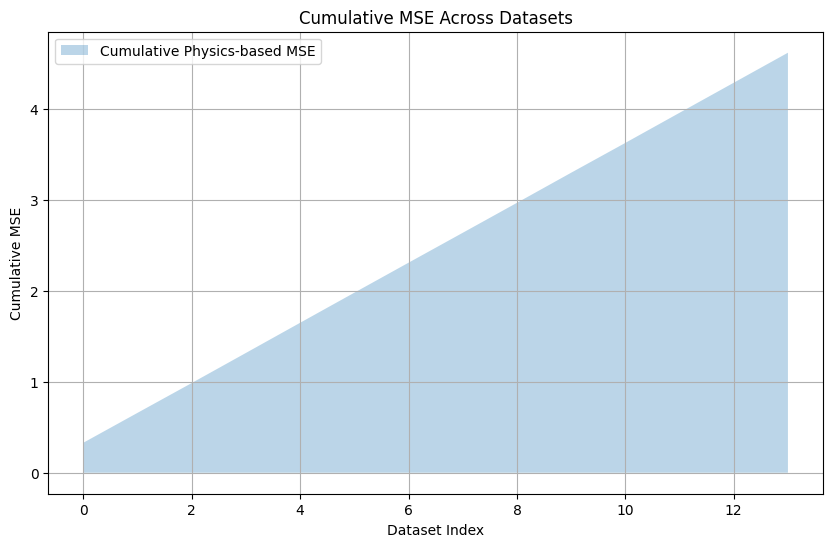

In [ ]:
plt.figure(figsize=(10, 6))

# Calculate cumulative MSE
cumulative_mse_orig = np.cumsum(all_mse_orig)
cumulative_mse_phy = np.cumsum(all_mse_phy)

#plt.fill_between(range(num_datasets), 0, cumulative_mse_orig, label='Cumulative Original MSE', alpha=0.3)
plt.fill_between(range(num_datasets), 0, cumulative_mse_phy, label='Cumulative Physics-based MSE', alpha=0.3)

plt.title('Cumulative MSE Across Datasets')
plt.xlabel('Dataset Index')
plt.ylabel('Cumulative MSE')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

1/1 [==============================] - 0s 25ms/step


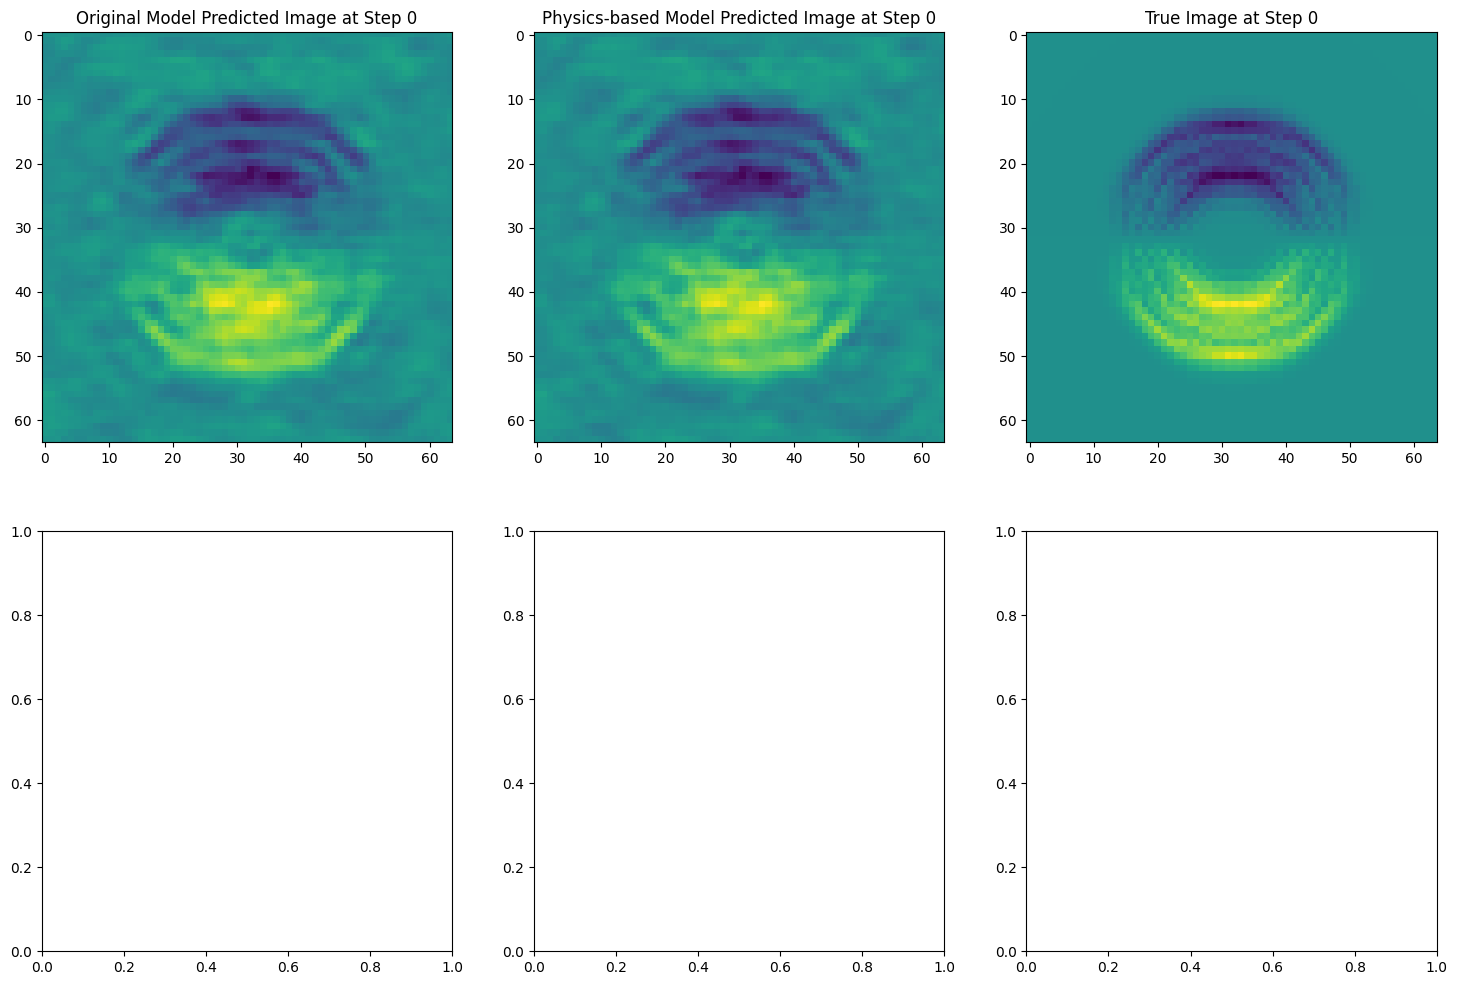

1/1 [==============================] - 0s 23ms/step


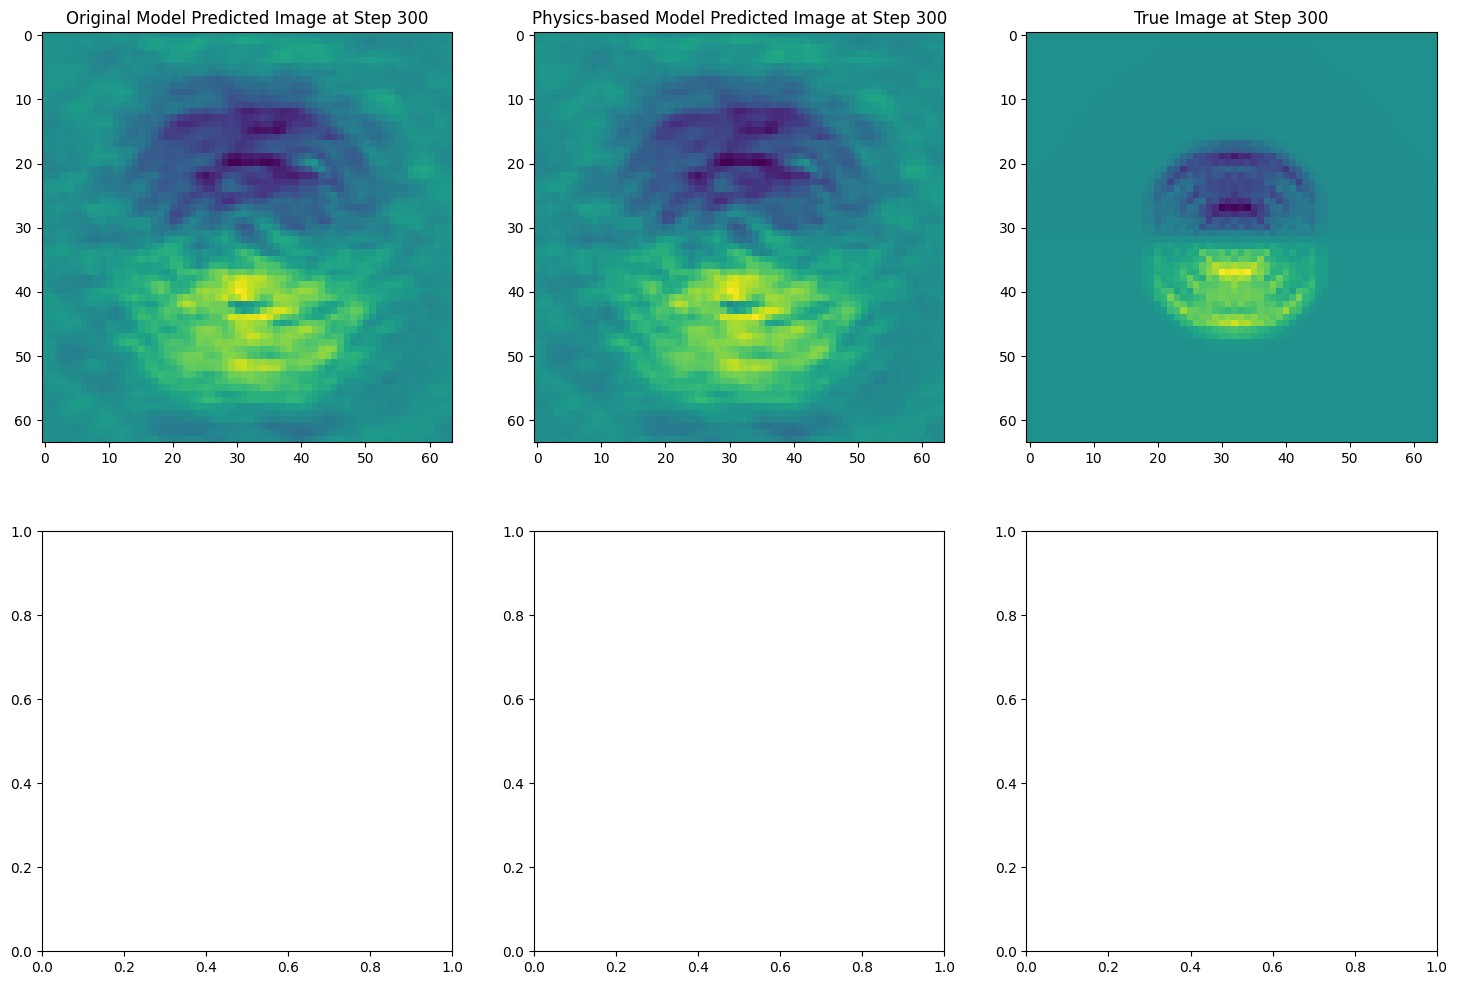

1/1 [==============================] - 0s 22ms/step


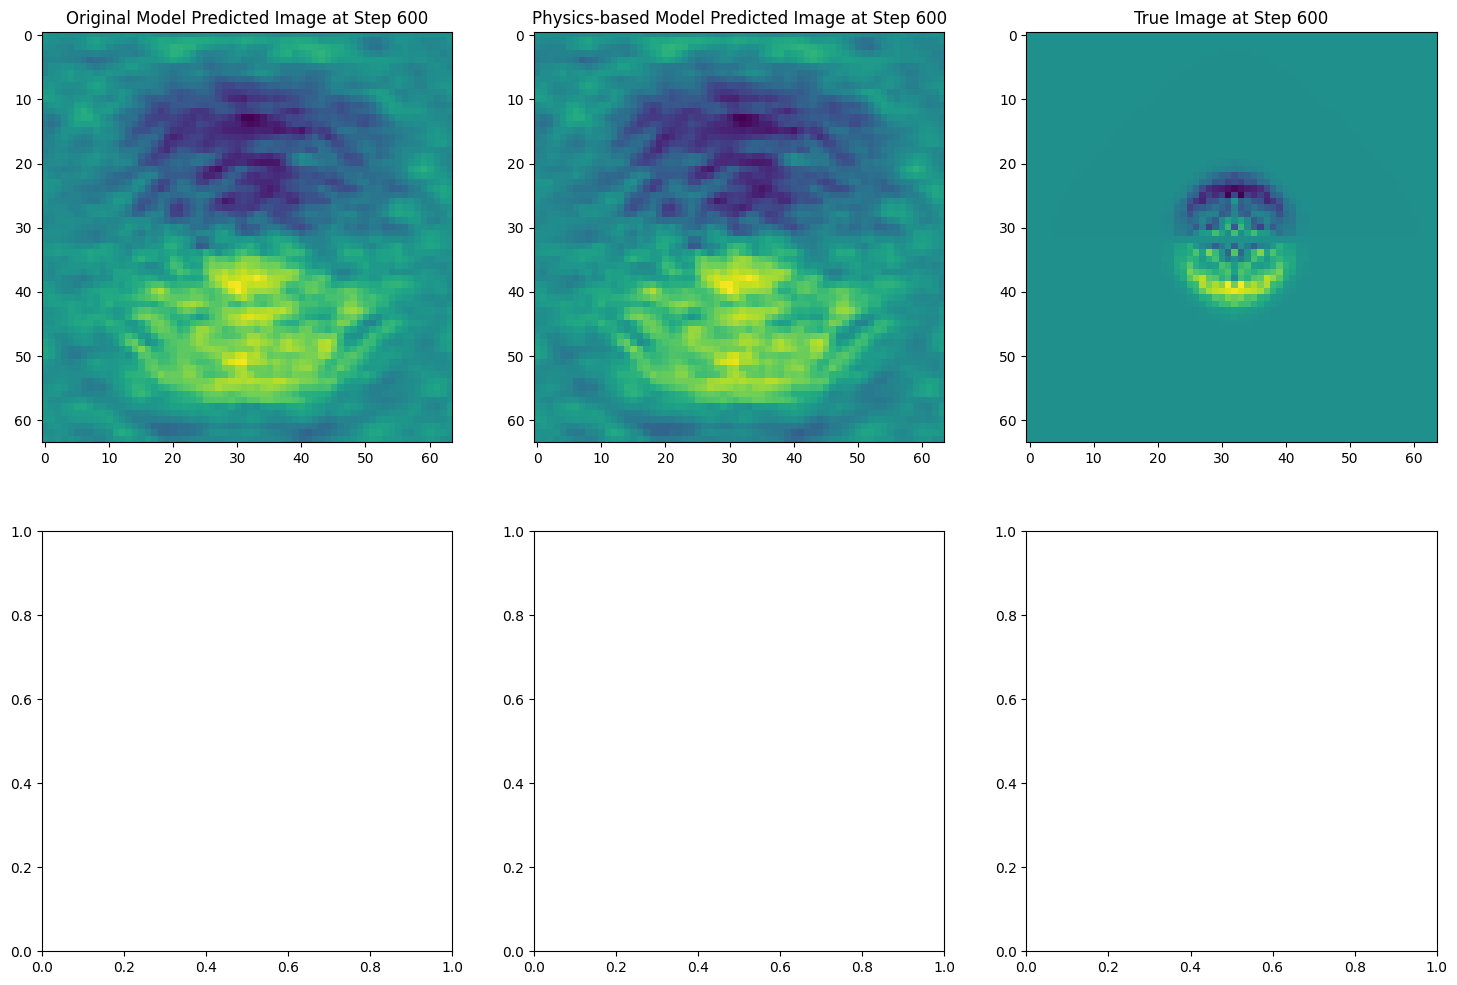

1/1 [==============================] - 0s 22ms/step


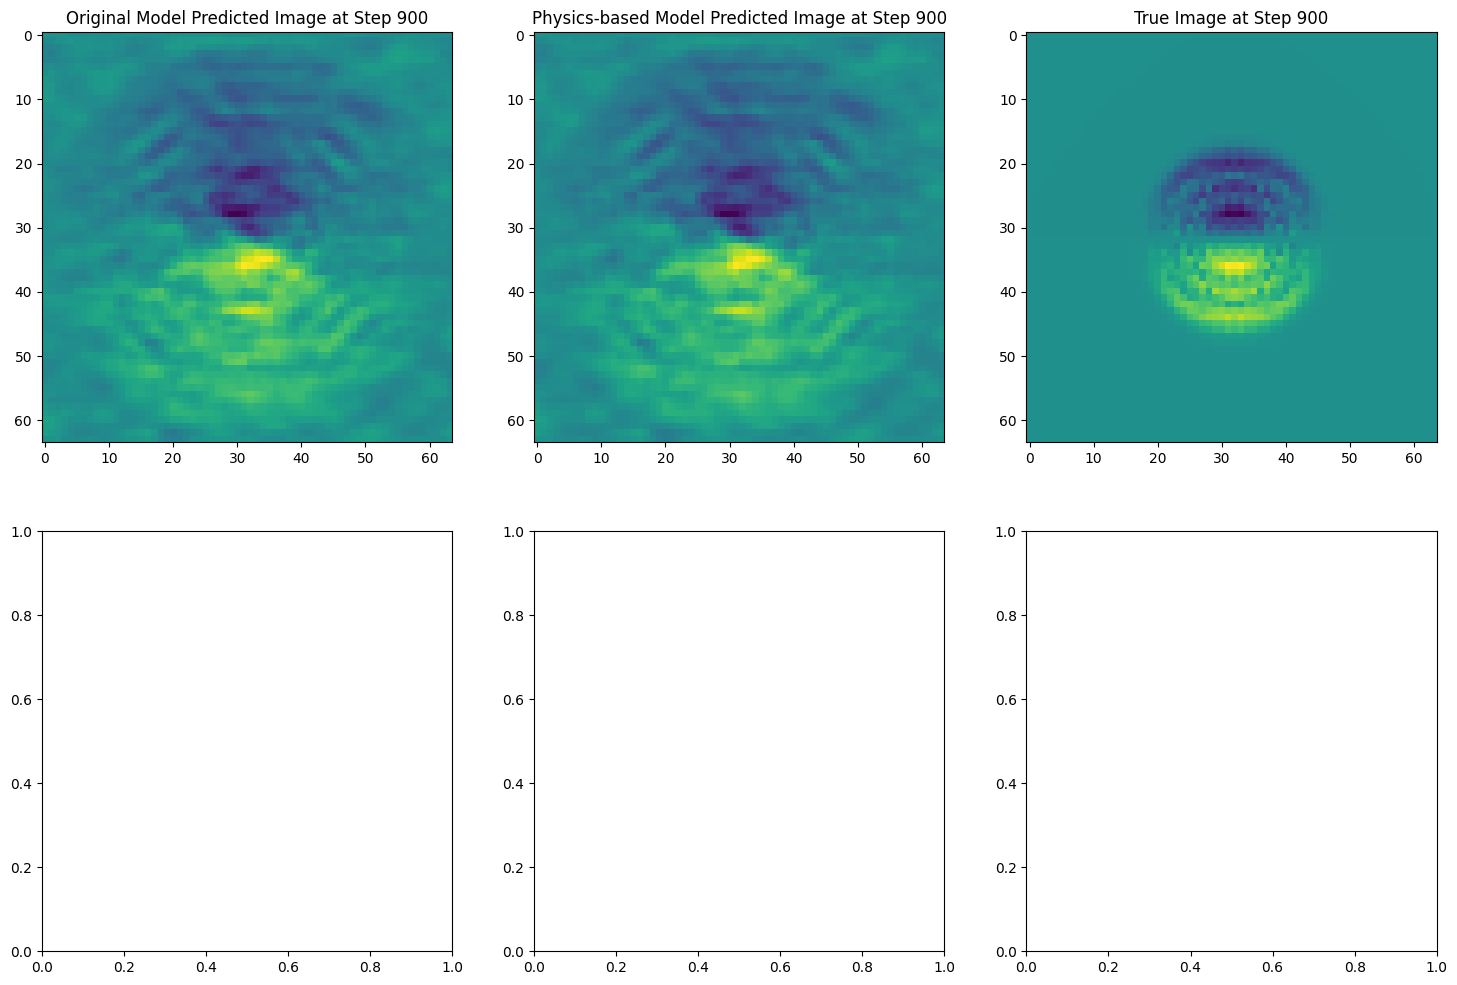

1/1 [==============================] - 0s 22ms/step


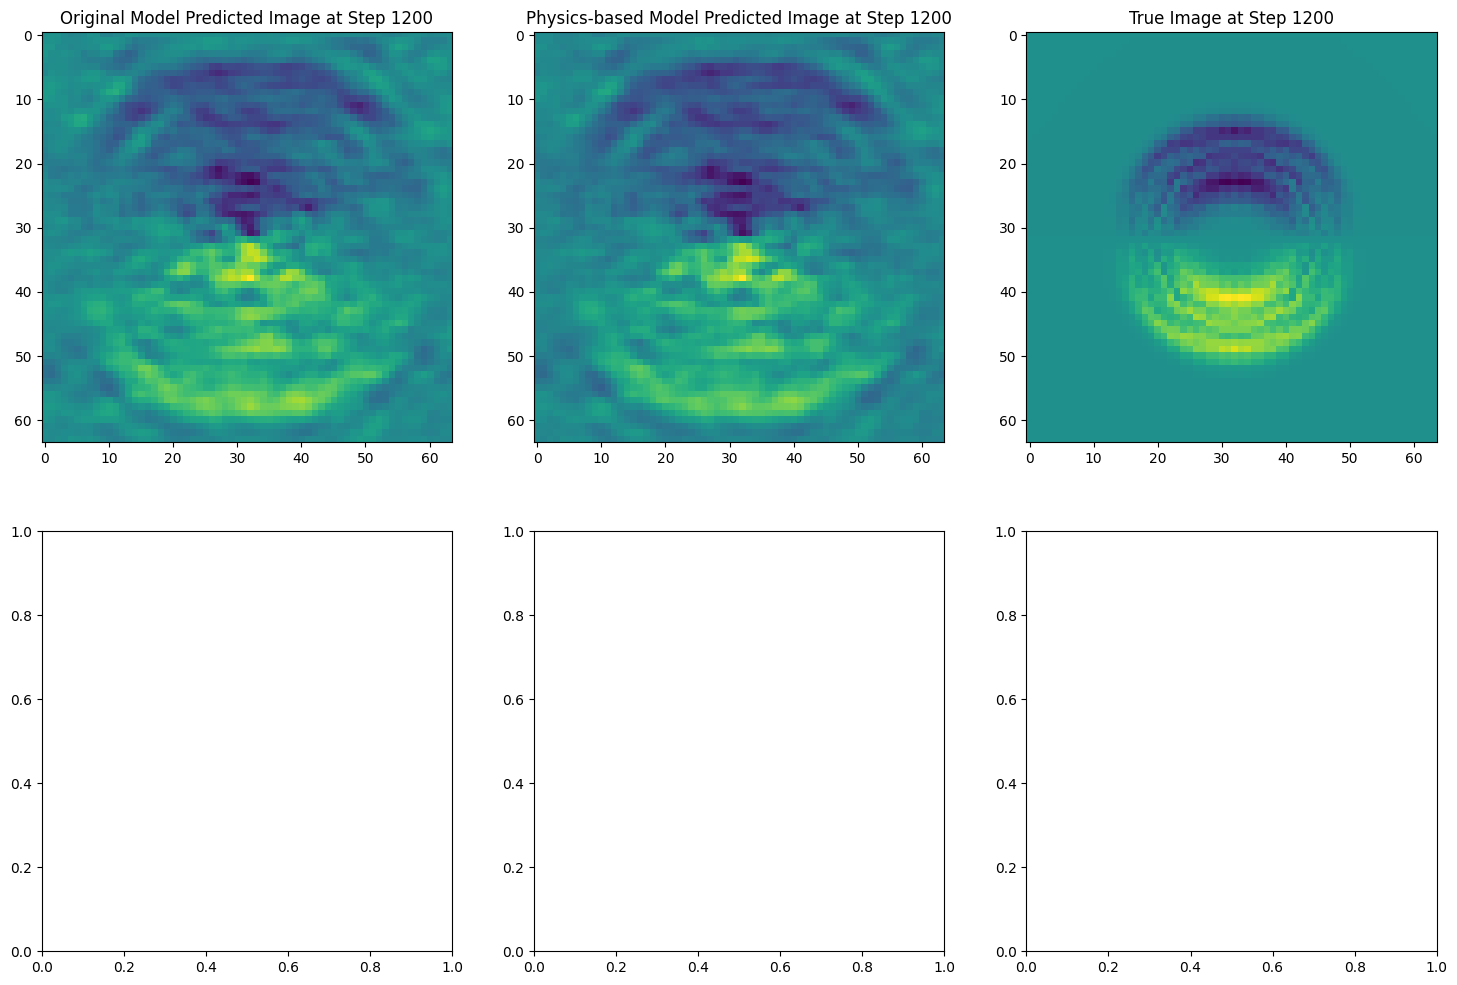

1/1 [==============================] - 0s 25ms/step


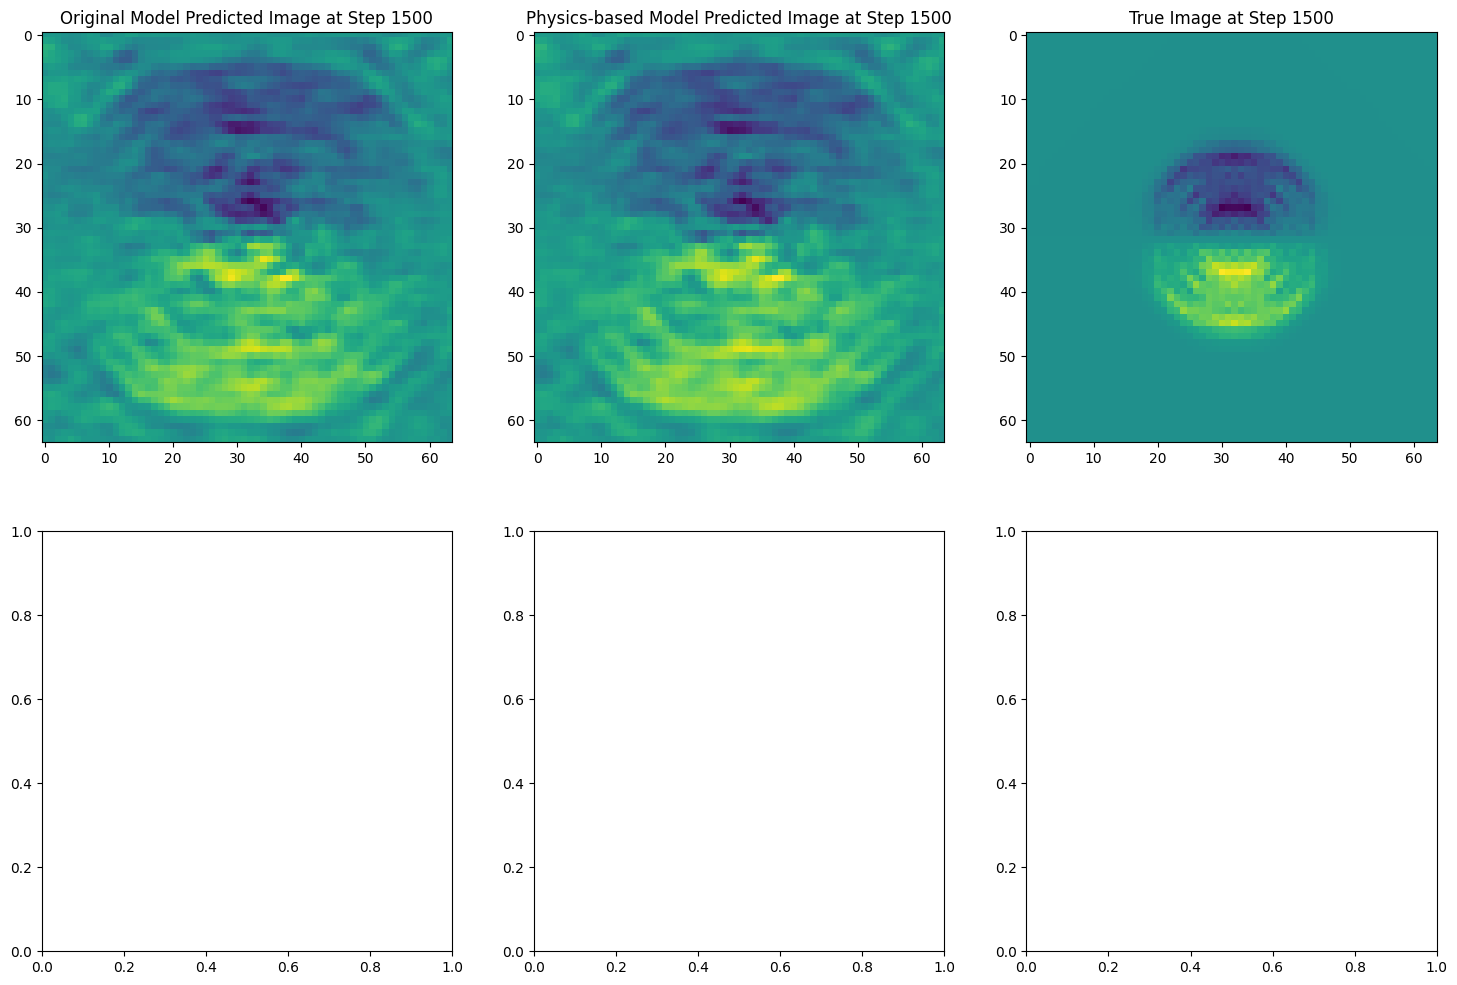

1/1 [==============================] - 0s 24ms/step


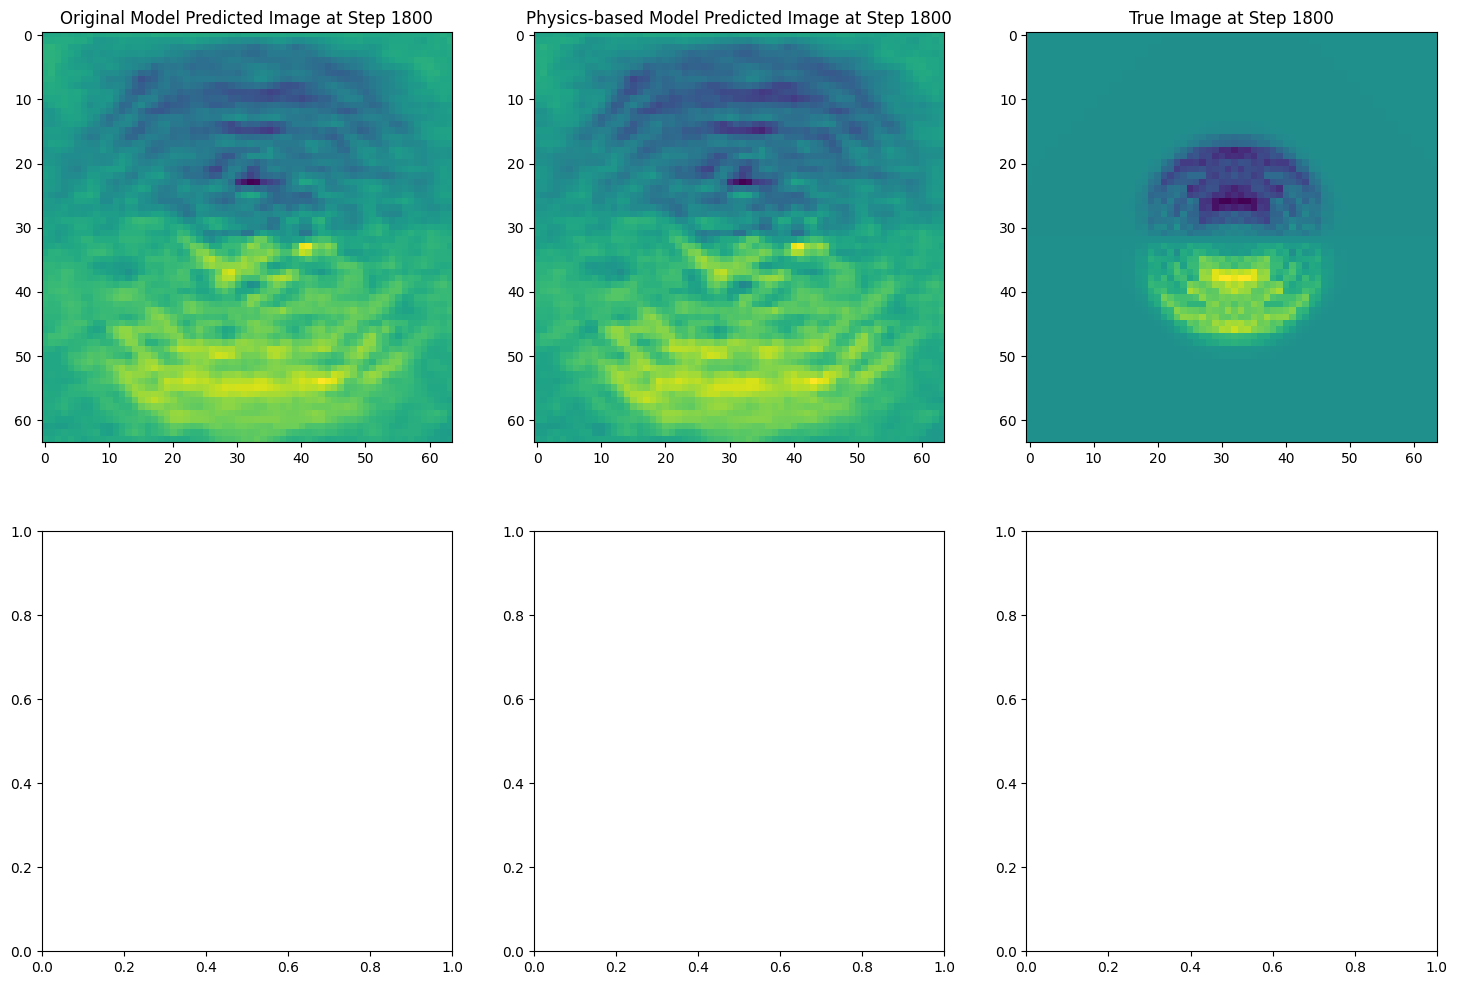

1/1 [==============================] - 0s 23ms/step


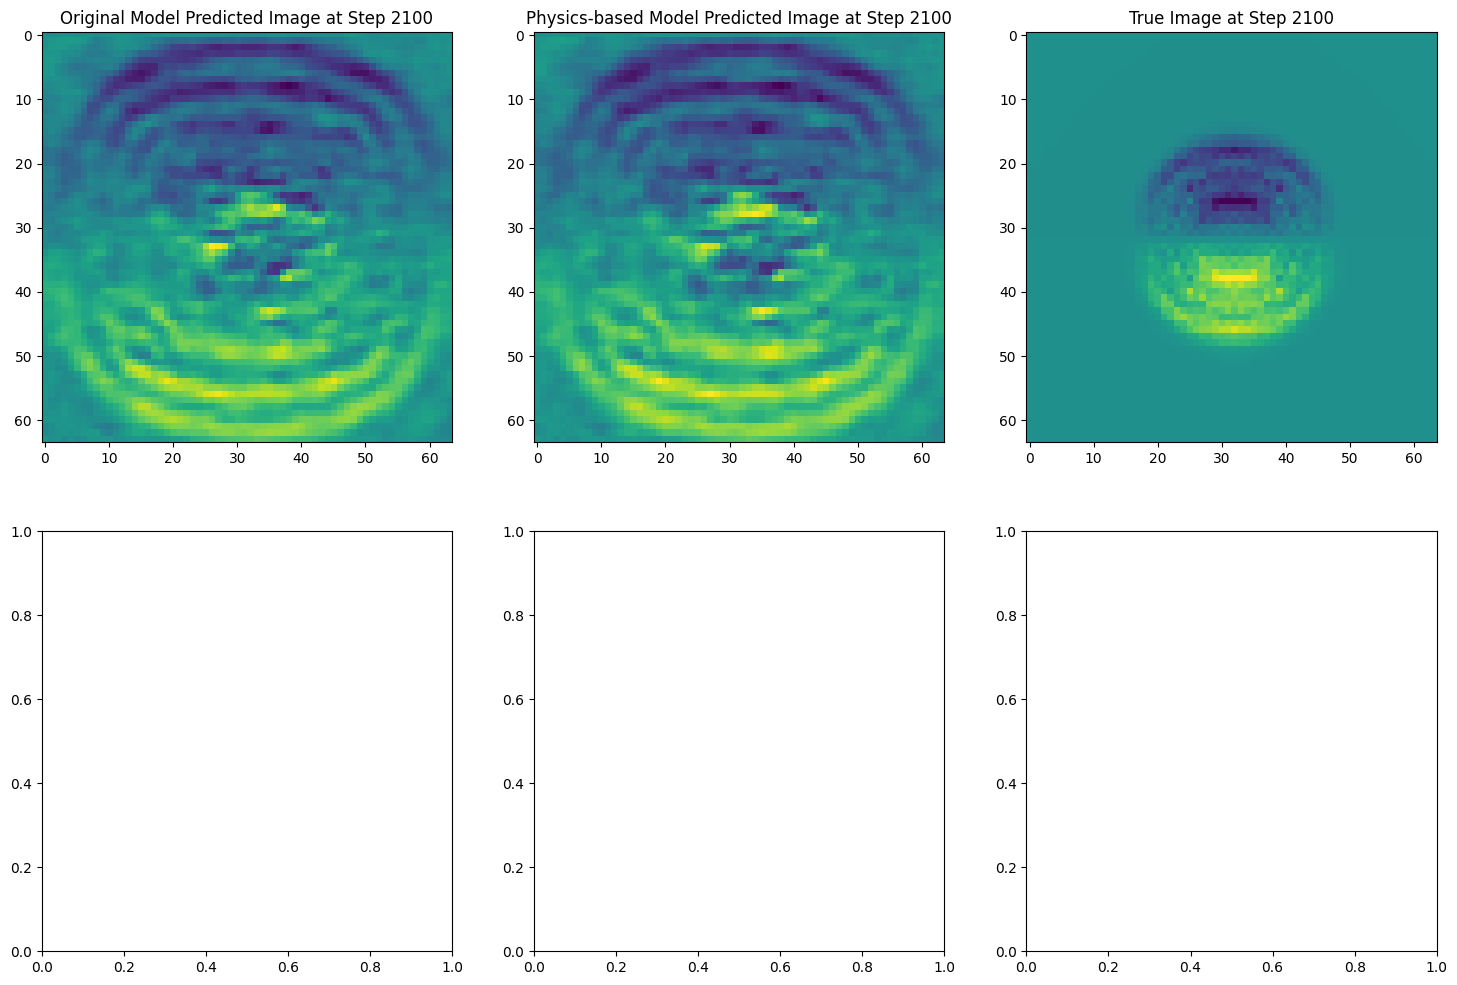

1/1 [==============================] - 0s 24ms/step


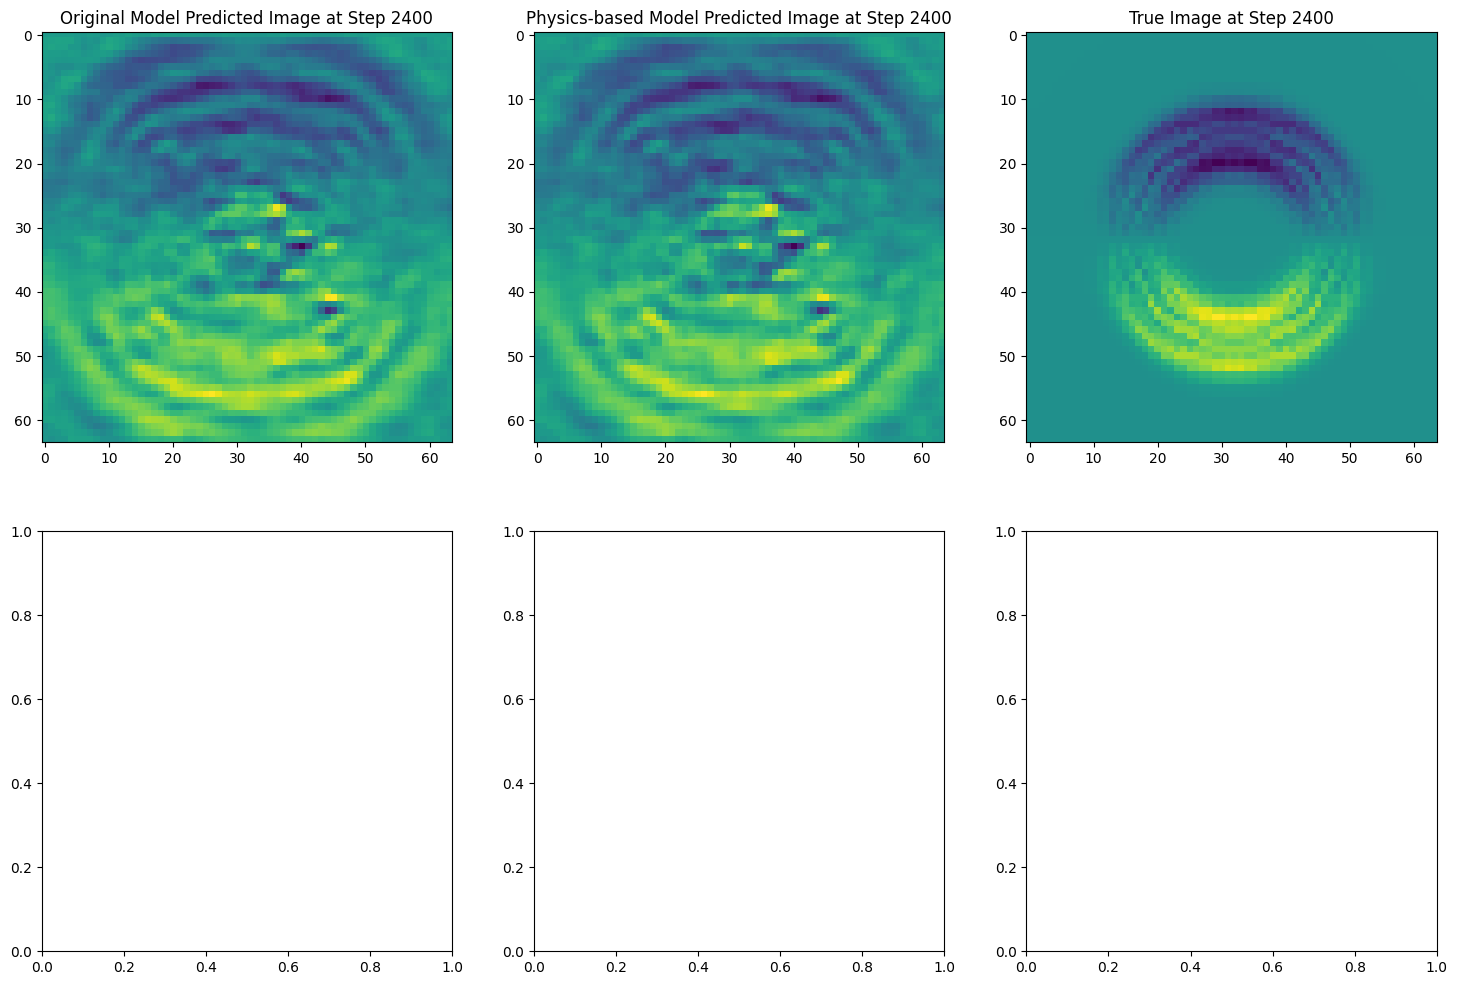

1/1 [==============================] - 0s 22ms/step


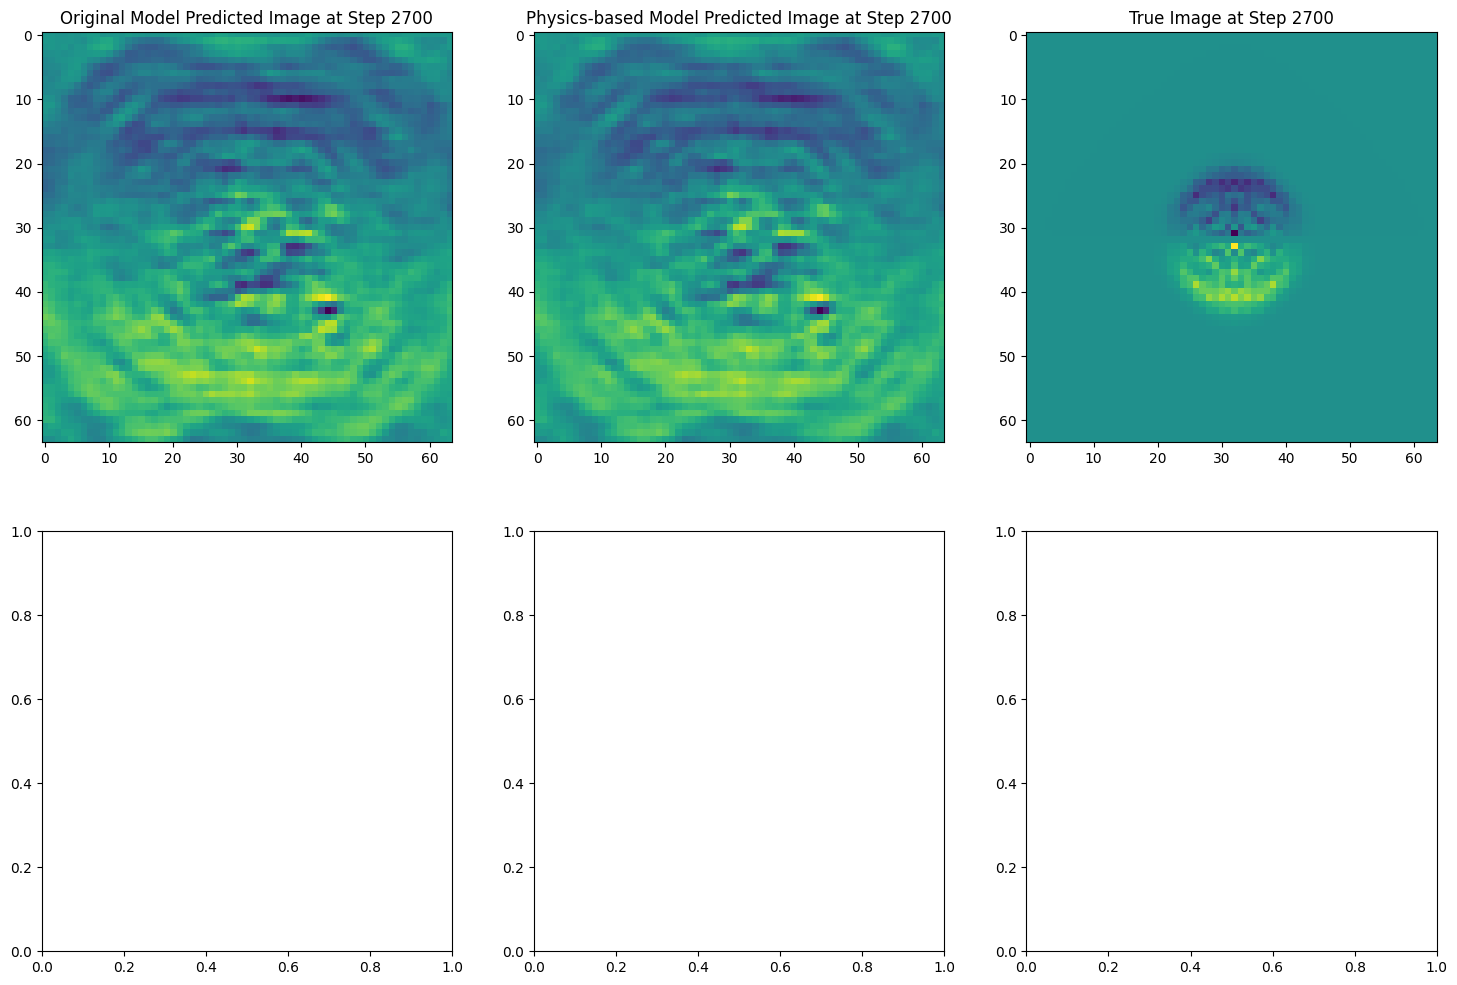

1/1 [==============================] - 0s 23ms/step


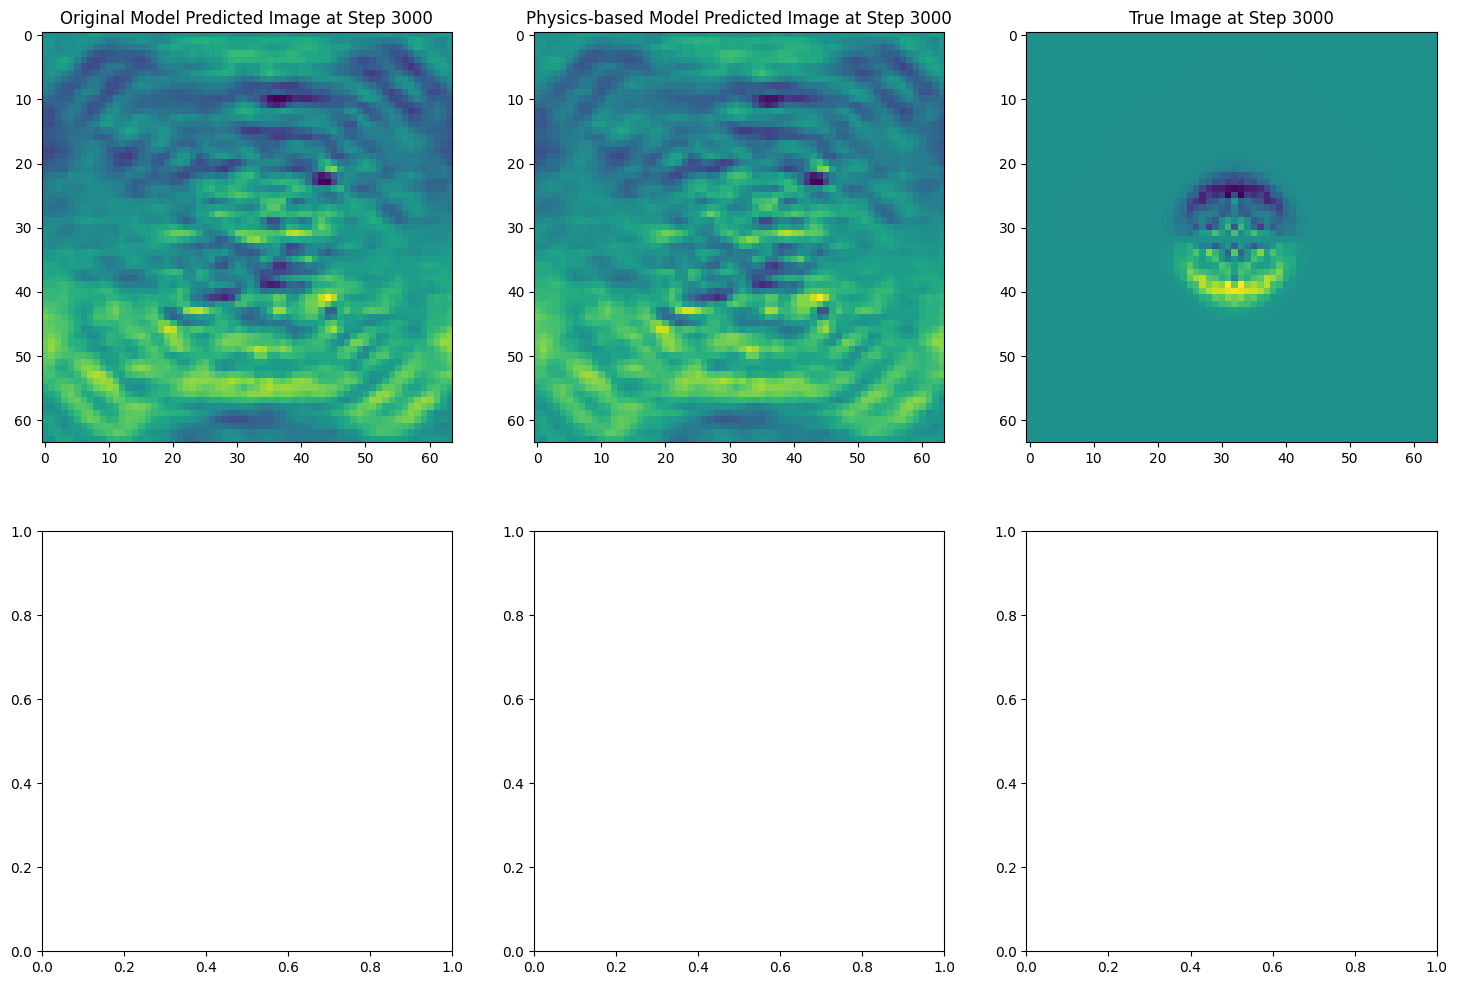

1/1 [==============================] - 0s 22ms/step


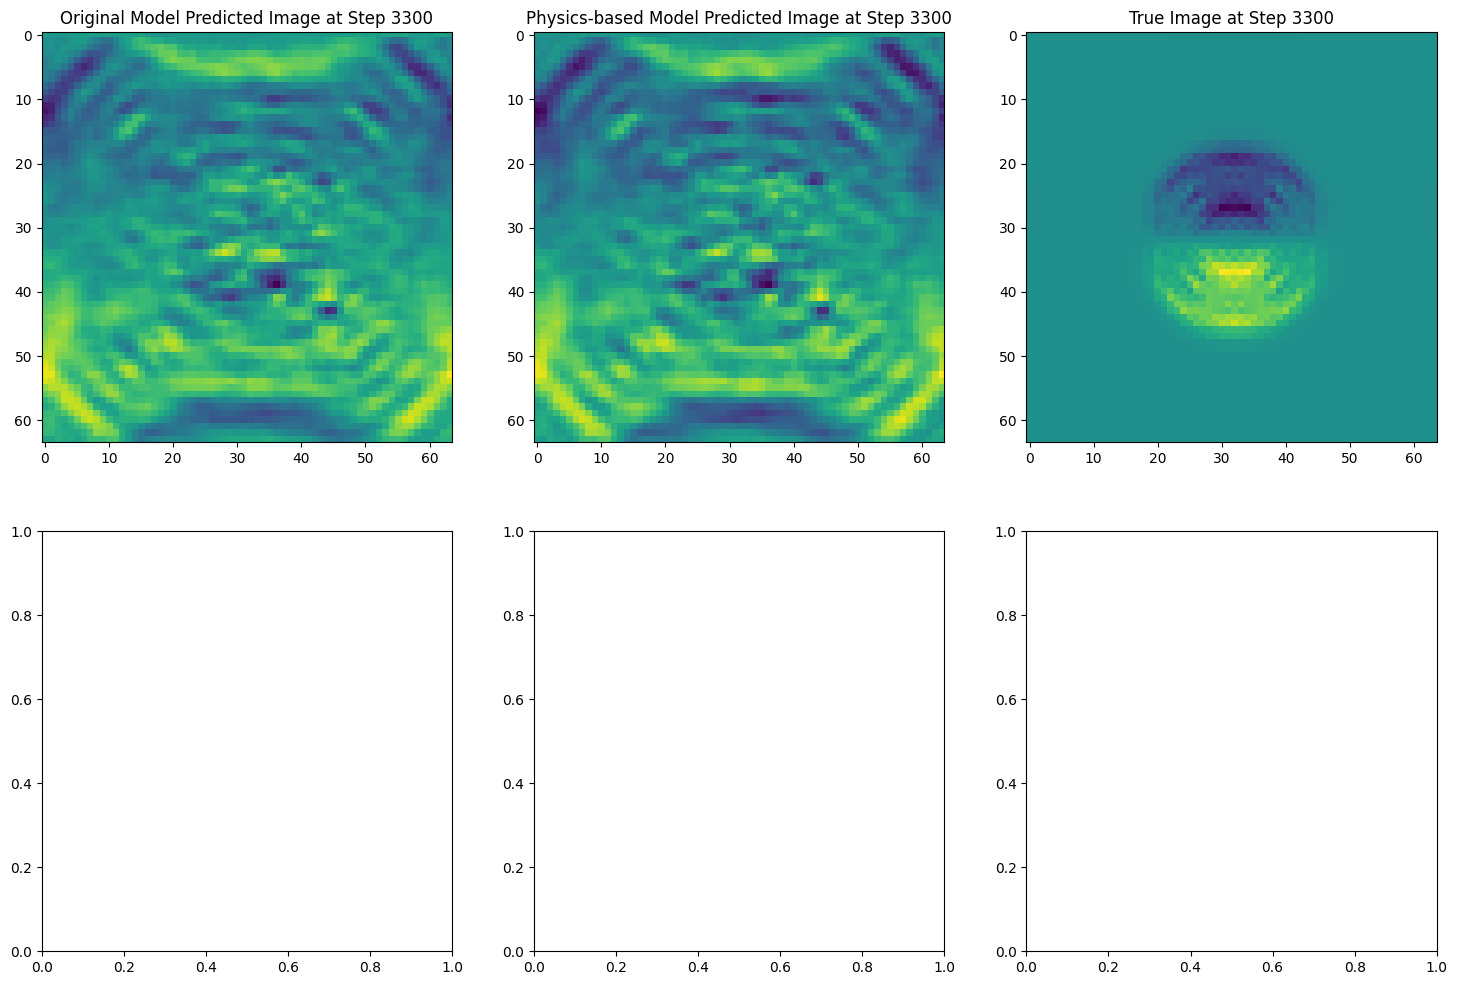

1/1 [==============================] - 0s 22ms/step


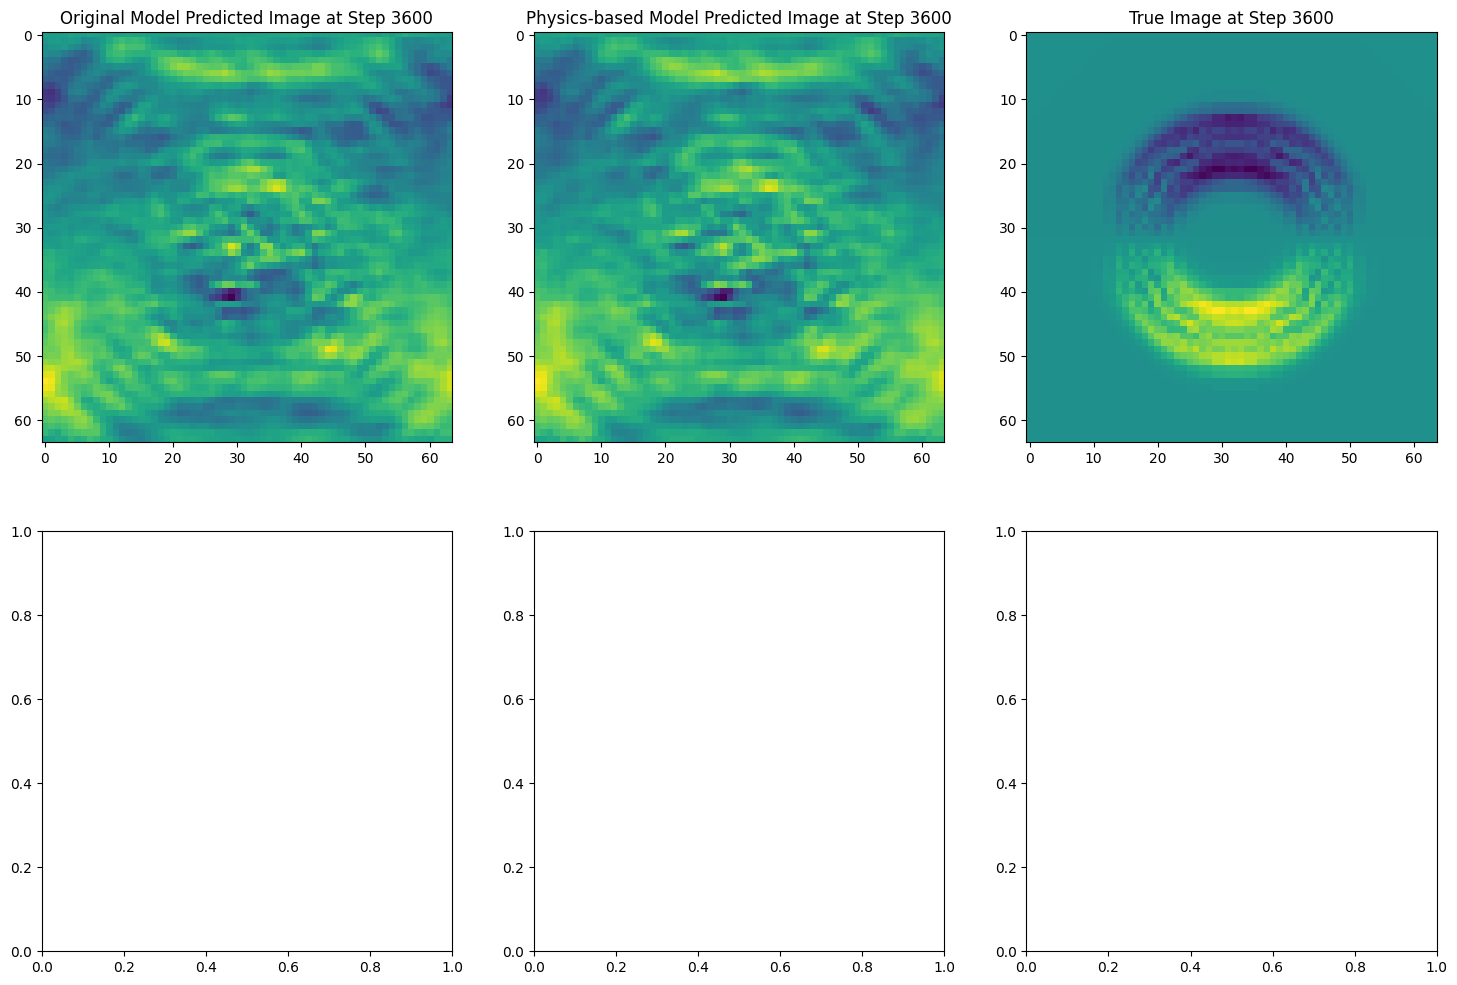

1/1 [==============================] - 0s 24ms/step


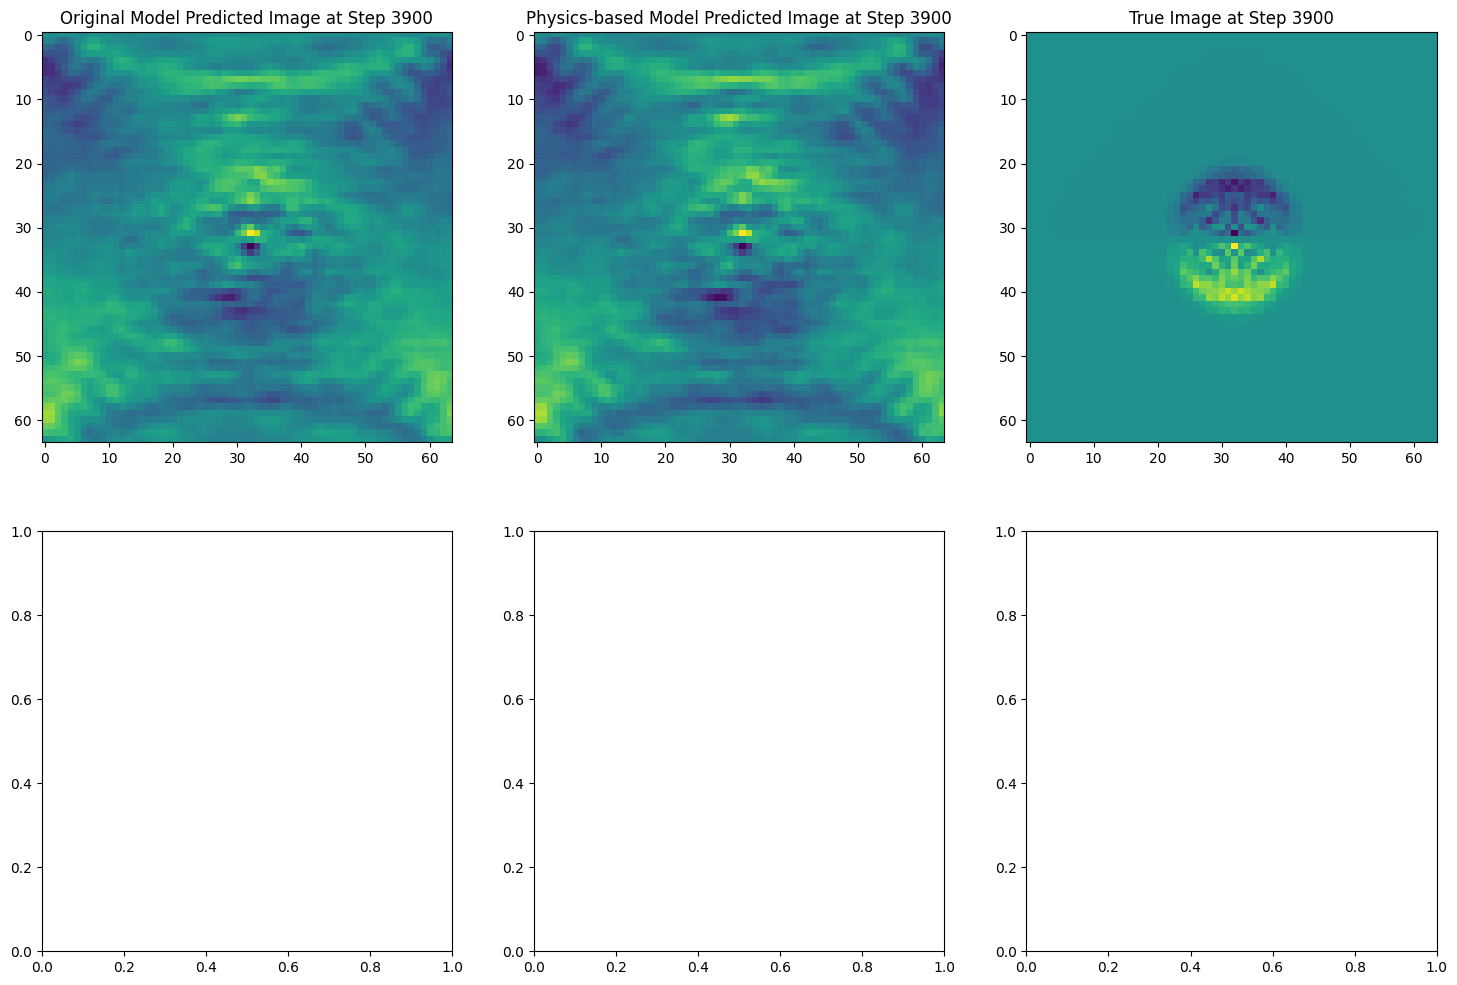

1/1 [==============================] - 0s 24ms/step


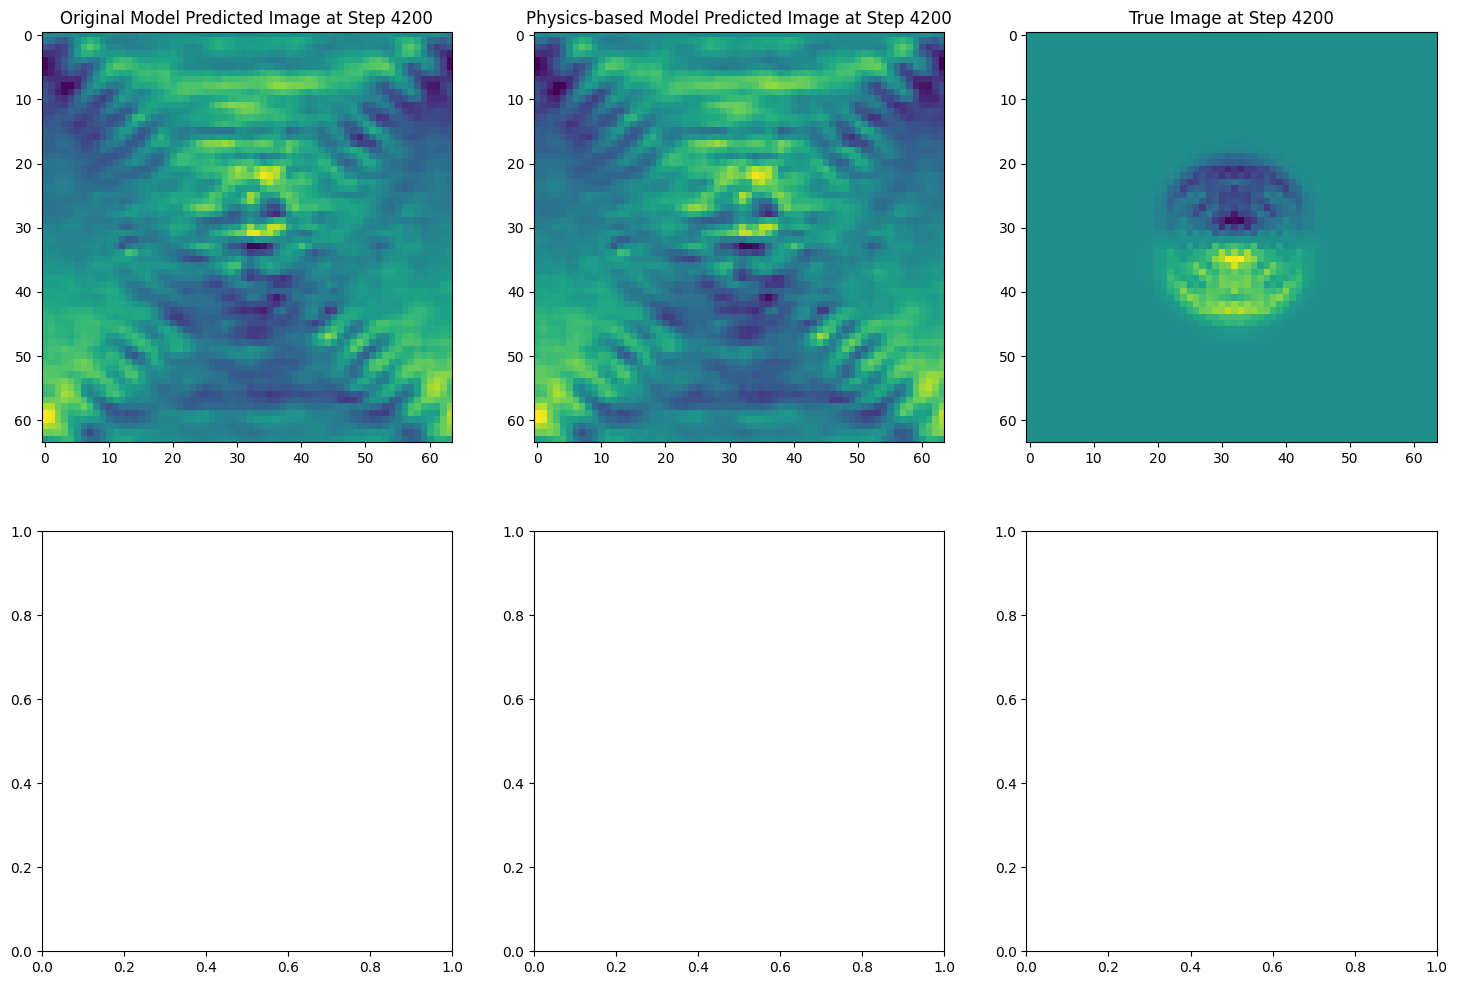

In [ ]:
import matplotlib.pyplot as plt

def visualize_comparative_rolling_images(model_orig, model_phy, initial_input, true_images, steps_to_predict, decoder_layer, ste, interval=100):
    """
    Visualize and compare predicted images from two models at specified intervals alongside true images.

    Parameters:
    - model_orig: The original trained model for predictions.
    - model_phy: The physics-based trained model for predictions.
    - initial_input: The initial input to start rolling forecasts for both models.
    - true_images: The array of true images to compare against model predictions.
    - steps_to_predict: Total number of prediction steps to perform.
    - decoder_layer: Function to decode model output back to image format.
    - ste: Step size for each prediction.
    - interval: Interval at which to visualize predictions.
    """
    input_sequence_orig = input_sequence_phy = initial_input.reshape(1, -1, 512)  # Match LSTM input shape

    for i in range(0, steps_to_predict, ste):
        if i % interval == 0:  # Check if the current step is at the specified interval
            # Predict with original model
            next_steps_orig = model_orig.predict(input_sequence_orig)
            y_pred_images_orig = decoder_layer(next_steps_orig.reshape(-1, 512))

            # Predict with physics-based model
            next_steps_phy = model_phy.predict(input_sequence_phy)
            y_pred_images_phy = decoder_layer(next_steps_phy.reshape(-1, 512))

            fig, axes = plt.subplots(2, 3, figsize=(18, 12))  # Adjust subplot grid as needed

            # Adjust indexing to select the correct predicted image for visualization
            # Assume the first image for simplicity
            pred_img_orig = y_pred_images_orig[0, :, :, 0]
            pred_img_phy = y_pred_images_phy[0, :, :, 0]

            # Select the corresponding true image
            true_img = true_images[i, :, :, 0]

            # Plot original model predicted image
            axes[0, 0].imshow(pred_img_orig)
            axes[0, 0].set_title(f'Original Model Predicted Image at Step {i}')

            # Plot physics-based model predicted image
            axes[0, 1].imshow(pred_img_phy)
            axes[0, 1].set_title(f'Physics-based Model Predicted Image at Step {i}')

            # Plot true image
            axes[0, 2].imshow(true_img)
            axes[0, 2].set_title(f'True Image at Step {i}')

            plt.show()

        # Update input sequences for the next prediction
        input_sequence_orig = next_steps_orig
        input_sequence_phy = next_steps_phy

# Example usage
initial_input = x_val[0, :, :]  # Assuming x_val is your validation set
true_images = true_test  # Assuming true_test contains your true images
steps_to_predict = 4500  # Total steps to predict
ste = 15  # Step size
interval = 100  # Interval for visualization

# Make sure `decoder_layer`, `orig_model`, and `real_model` are defined
visualize_comparative_rolling_images(orig_model, real_model, initial_input, true_images, steps_to_predict, decoder_layer, ste, interval)



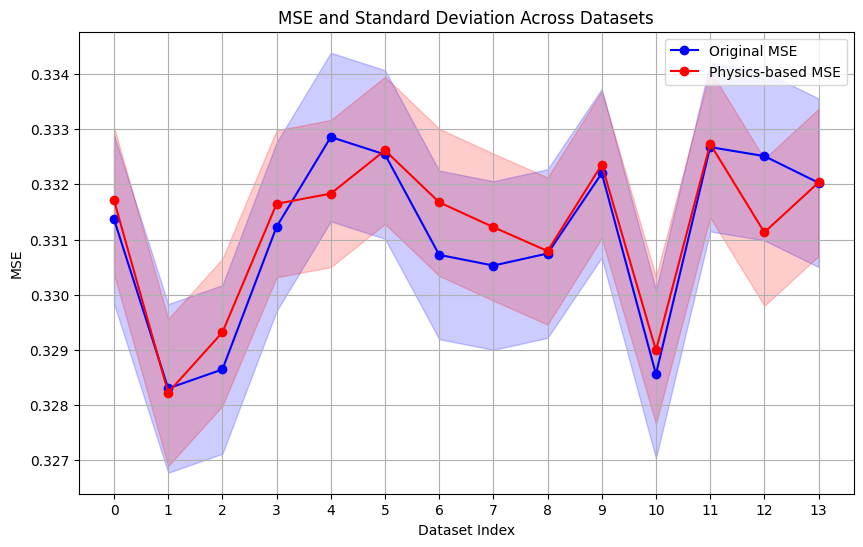

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming all_mse_orig and all_mse_phy contain MSE for each dataset,
# and std_mse_orig and std_mse_phy represent their standard deviations

num_datasets = len(all_mse_orig)  # Assuming this is defined by the length of your MSE arrays

plt.figure(figsize=(10, 6))

# Dataset indices for x-axis
x_axis = np.arange(num_datasets)

# Original Model MSE with Standard Deviation Fill
plt.plot(x_axis, all_mse_orig, label='Original MSE', color='blue', marker='o')
plt.fill_between(x_axis,
                 all_mse_orig - std_mse_orig,
                 all_mse_orig + std_mse_orig, color='blue', alpha=0.2)

# Physics-based Model MSE with Standard Deviation Fill
plt.plot(x_axis, all_mse_phy, label='Physics-based MSE', color='red', marker='o')
plt.fill_between(x_axis,
                 all_mse_phy - std_mse_phy,
                 all_mse_phy + std_mse_phy, color='red', alpha=0.2)

plt.title('MSE and Standard Deviation Across Datasets')
plt.xlabel('Dataset Index')
plt.ylabel('MSE')
plt.xticks(x_axis)  # Ensure x-ticks match the number of datasets
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


TypeError: object of type 'numpy.float64' has no len()

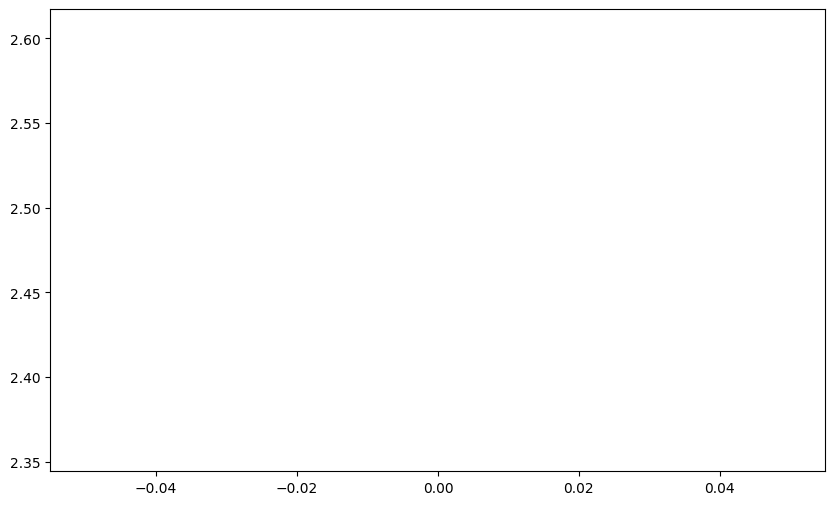

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate cumulative MSE for each dataset and store them
cum_mse_orig_datasets = np.cumsum(all_mse_orig, axis=0)
cum_mse_phy_datasets = np.cumsum(all_mse_phy, axis=0)

# Aggregate these cumulative MSEs across all datasets to get mean and std
mean_cum_mse_orig = np.mean(cum_mse_orig_datasets, axis=0)
std_cum_mse_orig = np.std(cum_mse_orig_datasets, axis=0)

mean_cum_mse_phy = np.mean(cum_mse_phy_datasets, axis=0)
std_cum_mse_phy = np.std(cum_mse_phy_datasets, axis=0)

# Plotting
plt.figure(figsize=(10, 6))

# Original Model Cumulative MSE with Std Dev
plt.plot(mean_cum_mse_orig, label='Original Cumulative MSE')
plt.fill_between(range(len(mean_cum_mse_orig)),
                 mean_cum_mse_orig - std_cum_mse_orig,
                 mean_cum_mse_orig + std_cum_mse_orig, alpha=0.2)

# Physics-based Model Cumulative MSE with Std Dev
plt.plot(mean_cum_mse_phy, label='Physics-based Cumulative MSE')
plt.fill_between(range(len(mean_cum_mse_phy)),
                 mean_cum_mse_phy - std_cum_mse_phy,
                 mean_cum_mse_phy + std_cum_mse_phy, alpha=0.2)

plt.title('Cumulative MSE with Standard Deviation over Steps')
plt.xlabel('Step')
plt.ylabel('Cumulative MSE')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()



In [ ]:
all_mse_orig

array([0.33136722, 0.32829815, 0.32864219, 0.33123079, 0.33285916,
       0.33254254, 0.33072114, 0.33052754, 0.33074591, 0.33220154,
       0.32855624, 0.3326762 , 0.33251318, 0.33202967])

1/1 [==============================] - 0s 21ms/step
(1, 15, 512)
1/1 [==============================] - 0s 21ms/step
(1, 15, 512)
1/1 [==============================] - 0s 22ms/step
(1, 15, 512)
1/1 [==============================] - 0s 21ms/step
(1, 15, 512)
1/1 [==============================] - 0s 22ms/step
(1, 15, 512)
1/1 [==============================] - 0s 21ms/step
(1, 15, 512)
1/1 [==============================] - 0s 20ms/step
(1, 15, 512)
1/1 [==============================] - 0s 21ms/step
(1, 15, 512)
1/1 [==============================] - 0s 21ms/step
(1, 15, 512)
1/1 [==============================] - 0s 20ms/step
(1, 15, 512)
1/1 [==============================] - 0s 20ms/step
(1, 15, 512)
1/1 [==============================] - 0s 22ms/step
(1, 15, 512)
1/1 [==============================] - 0s 21ms/step
(1, 15, 512)
1/1 [==============================] - 0s 22ms/step
(1, 15, 512)
1/1 [==============================] - 0s 22ms/step
(1, 15, 512)
1/1 [====================

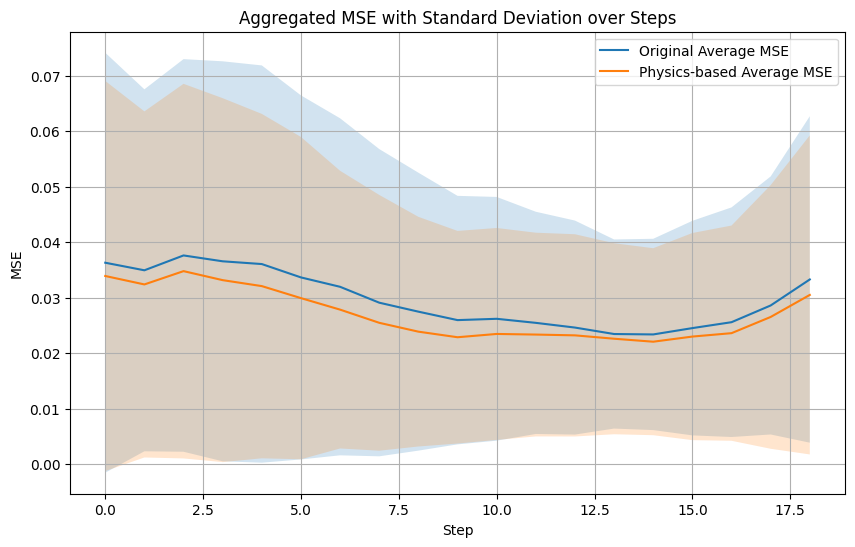

In [ ]:


all_mse_orig = []
all_mse_phy = []
ste = 15
# 收集每个数据集的MSE
for i in range(14):
    x_test_cu, y_test_cu = prepare_test_data(x_val, y_val, i)
    initial_input = x_test_cu[:ste]

    _, mse = rolling_forecast(orig_model, initial_input, y_test_cu, len(y_test_cu))
    _, mse_phy = rolling_forecast(real_model, initial_input, y_test_cu, len(y_test_cu))

    average_mse_per_group = np.mean(mse, axis=1)
    average_mse_per_phy = np.mean(mse_phy, axis=1)

    all_mse_orig.append(average_mse_per_group)
    all_mse_phy.append(average_mse_per_phy)

# 计算汇总的平均值和标准差
all_mse_orig = np.array(all_mse_orig)
all_mse_phy = np.array(all_mse_phy)

avg_mse_orig = np.mean(all_mse_orig, axis=0)
std_mse_orig = np.std(all_mse_orig, axis=0)

avg_mse_phy = np.mean(all_mse_phy, axis=0)
std_mse_phy = np.std(all_mse_phy, axis=0)

# 绘制汇总图表
plt.figure(figsize=(10, 6))
plt.plot(avg_mse_orig, label='Original Average MSE')
plt.fill_between(range(len(avg_mse_orig)), avg_mse_orig - std_mse_orig, avg_mse_orig + std_mse_orig, alpha=0.2)

plt.plot(avg_mse_phy, label='Physics-based Average MSE')
plt.fill_between(range(len(avg_mse_phy)), avg_mse_phy - std_mse_phy, avg_mse_phy + std_mse_phy, alpha=0.2)

plt.title('Aggregated MSE with Standard Deviation over Steps')
plt.xlabel('Step')
plt.ylabel('MSE')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 假设您已经定义了x_val, y_val, orig_model等

# 选择一个数据集进行展示
i = 0  # 您可以更改这个值来选择不同的数据集
x_test_cu, y_test_cu = prepare_test_data(x_val, y_val, i)
initial_input = x_test_cu[:10]

# 获取预测和MSE
predictions, mse_array = rolling_forecast(orig_model, initial_input, y_test_cu, len(y_test_cu))
predictions.shape

1/1 [==============================] - 0s 23ms/step
(1, 10, 512)
1/1 [==============================] - 0s 21ms/step
(1, 10, 512)
1/1 [==============================] - 0s 20ms/step
(1, 10, 512)
1/1 [==============================] - 0s 22ms/step
(1, 10, 512)
1/1 [==============================] - 0s 23ms/step
(1, 10, 512)
1/1 [==============================] - 0s 22ms/step
(1, 10, 512)
1/1 [==============================] - 0s 21ms/step
(1, 10, 512)
1/1 [==============================] - 0s 21ms/step
(1, 10, 512)
1/1 [==============================] - 0s 21ms/step
(1, 10, 512)
1/1 [==============================] - 0s 20ms/step
(1, 10, 512)
1/1 [==============================] - 0s 20ms/step
(1, 10, 512)
1/1 [==============================] - 0s 21ms/step
(1, 10, 512)
1/1 [==============================] - 0s 21ms/step
(1, 10, 512)
1/1 [==============================] - 0s 22ms/step
(1, 10, 512)
1/1 [==============================] - 0s 23ms/step
(1, 10, 512)
1/1 [====================

(290, 512)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 假设您已经定义了x_val, y_val, orig_model等

# 选择一个数据集进行展示
i = 0  # 您可以更改这个值来选择不同的数据集
x_test_cu, y_test_cu = prepare_test_data(x_val, y_val, i)
initial_input = x_test_cu[:10]

# 获取预测和MSE
predictions, mse_array = rolling_forecast(orig_model, initial_input, y_test_cu, len(y_test_cu))
predictions.shape
# 绘制预测和真实值的对比图
plt.figure(figsize=(12, 6))
plt.plot(y_test_cu.flatten(), label='True Values', color='blue')
plt.plot(predictions.flatten(), label='Predictions', color='red')
plt.title('True Values vs Predictions')
plt.xlabel('Step')
plt.ylabel('Value')
plt.legend()
plt.show()

# 如果需要，还可以绘制MSE随时间的变化
cumulative_mse = np.cumsum(np.mean(mse_array, axis=1))
plt.figure(figsize=(12, 6))
plt.plot(cumulative_mse, label='Cumulative MSE', color='green')
plt.title('Cumulative Mean Squared Error over Steps')
plt.xlabel('Step')
plt.ylabel('Cumulative MSE')
plt.legend()
plt.show()


In [ ]:

cumulative_mse_orig = []
cumulative_mse_phy = []

# 收集并计算每个数据集的累积MSE
for i in range(14):
    x_test_cu, y_test_cu = prepare_test_data(x_val, y_val, i)
    initial_input = x_test_cu[:10]

    _, mse = rolling_forecast(orig_model, initial_input, y_test_cu, len(y_test_cu))
    _, mse_phy = rolling_forecast(real_model, initial_input, y_test_cu, len(y_test_cu))

    cumulative_mse_per_group = np.cumsum(np.mean(mse, axis=1))
    cumulative_mse_per_phy = np.cumsum(np.mean(mse_phy, axis=1))

    cumulative_mse_orig.append(cumulative_mse_per_group)
    cumulative_mse_phy.append(cumulative_mse_per_phy)

# 计算汇总的平均值和标准差
cumulative_mse_orig = np.array(cumulative_mse_orig)
cumulative_mse_phy = np.array(cumulative_mse_phy)

avg_cumulative_mse_orig = np.mean(cumulative_mse_orig, axis=0)
std_cumulative_mse_orig = np.std(cumulative_mse_orig, axis=0)

avg_cumulative_mse_phy = np.mean(cumulative_mse_phy, axis=0)
std_cumulative_mse_phy = np.std(cumulative_mse_phy, axis=0)

# 绘制汇总图表
plt.figure(figsize=(10, 6))
plt.plot(avg_cumulative_mse_orig, label='Original Cumulative Average MSE')
plt.fill_between(range(len(avg_cumulative_mse_orig)), avg_cumulative_mse_orig - std_cumulative_mse_orig, avg_cumulative_mse_orig + std_cumulative_mse_orig, alpha=0.2)

plt.plot(avg_cumulative_mse_phy, label='Physics-based Cumulative Average MSE')
plt.fill_between(range(len(avg_cumulative_mse_phy)), avg_cumulative_mse_phy - std_cumulative_mse_phy, avg_cumulative_mse_phy + std_cumulative_mse_phy, alpha=0.2)

plt.title('Aggregated Cumulative MSE with Standard Deviation over Steps')
plt.xlabel('Step')
plt.ylabel('Cumulative MSE')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


In [ ]:

orig_model = tf.keras.models.load_model('/content/0121/orig_final_model.h5', custom_objects={
    'calculate_relative_energy_error':calculate_relative_energy_error,
})
real_model = tf.keras.models.load_model('/content/0121/ophy_final_model.h5', custom_objects={
    'custom_loss': custom_loss,
    'calculate_relative_energy_error':calculate_relative_energy_error,
})
res_orig = orig_model.predict(x_val)
res_phy =real_model.predict(x_val)

res_orig = res_orig[:,0,:]
res_phy = res_phy[:,0,:]

#torig_res = scaler_auto.inverse_transform(res_orig)

reconstructed_images_phy = new_model.predict(res_phy)
reconstructed_images_orig = new_model.predict(res_orig)
num = 4490
true_test_lstm = true_image[-num:-10]


ssim_score = ssim(true_test_lstm, reconstructed_images_phy, multichannel=True)



140/140 [==============================] - 0s 1ms/step


<ipython-input-76-075004c0f538>:22: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_score = ssim(true_test_lstm, reconstructed_images_phy, multichannel=True)
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


In [ ]:
ssim_score_orig = ssim(true_test_lstm, reconstructed_images_orig, multichannel=True)
ssim_score_orig

<ipython-input-78-8ec911dd39be>:1: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_score_orig = ssim(true_test_lstm, reconstructed_images_orig, multichannel=True)
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


In [ ]:
ssim_score_orig

0.8781846742258409

In [ ]:
ssim_score

0.8757914132187873

In [ ]:
# Calculate inference time
start_time = time.time()
res_phy = real_model.predict(x_val)
inference_time = time.time() - start_time

res_phy = res_phy[:,0,:]
reconstructed_images_phy = new_model.predict(res_phy)

true_test_lstm = true_image[-2390:-10]
# Assuming vor_test is your concatenated array with shape (n, 64, 64, 3)
# And vor_test_u_scaler, vor_test_v_scaler, vor_test_h_scaler are the scalers used for u, v, and h channels respectively

# Step 1: Separate the channels
vor_test_u = reconstructed_images_phy[:,:,:,0]
vor_test_v = reconstructed_images_phy[:,:,:,1]
vor_test_h = reconstructed_images_phy[:,:,:,2]

# Step 2: Inverse transform each channel
vor_test_u_original = vor_test_u * range_vu + min_vu
vor_test_v_original = vor_test_v * range_vv + min_vv
vor_test_h_original = vor_test_h * range_vh + min_vh

# Step 3: Recombine the channels
res_orign = np.stack([vor_test_u_original, vor_test_v_original, vor_test_h_original], axis=-1)

# Repeat the same steps for y_val if needed
vor_test_u = true_test_lstm[:,:,:,0]
vor_test_v = true_test_lstm[:,:,:,1]
vor_test_h = true_test_lstm[:,:,:,2]

vor_test_u_original = vor_test_u * range_vu + min_vu
vor_test_v_original = vor_test_v * range_vv + min_vv
vor_test_h_original = vor_test_h * range_vh + min_vh

# Recombine the channels
y_val = np.stack([vor_test_u_original, vor_test_v_original, vor_test_h_original], axis=-1)


res_orign = res_orign[:,:,:,:]
y_true = y_val[:, :, :, :]
res_orig_flat = res_orign.flatten()
y_true_flat = y_true.flatten()

from sklearn.metrics import mean_squared_error
mse_orig = mean_squared_error(res_orig_flat, y_true_flat)

ssim_score = ssim(y_true, res_orign, multichannel=True)

# Calculate RRMSE
rrmse = np.sqrt(mse_orig) / np.mean(y_true)


print("SSIM:", ssim_score)
print("RRMSE:", rrmse)
print("MSE_orig:", mse_orig)
print("Inference Time:", inference_time)

75/75 [==============================] - 0s 2ms/step


<ipython-input-62-c0a3332e7c78>:47: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_score = ssim(y_true, res_orign, multichannel=True)
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


SSIM: 0.45529494780512386
RRMSE: 0.24794737210328197
MSE_orig: 0.009129211041754532
Inference Time: 0.36608290672302246


In [ ]:
#ssim_score_orig = ssim(true_test_lstm, reconstructed_images_orig,multichannel=True)
ssim_score_phy = ssim(true_test_lstm, reconstructed_images_phy,multichannel=True)

# Print the SSIM score
#print("The SSIM score orig is:", ssim_score_orig)
print("The SSIM score phy is:", ssim_score_phy)

<ipython-input-40-1eb110dfd76d>:2: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_score_phy = ssim(true_test_lstm, reconstructed_images_phy,multichannel=True)
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


The SSIM score phy is: 0.9089115190579876


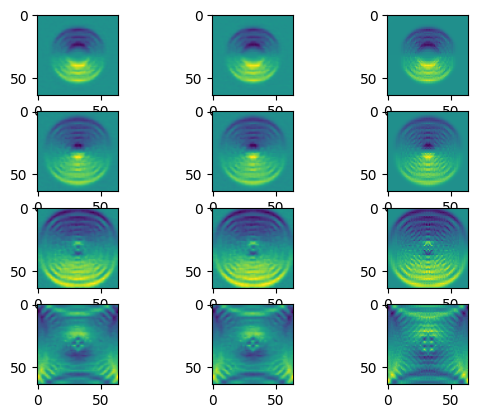

In [ ]:

plt.subplot(4,3,1)
plt.imshow(reconstructed_images_phy[10,:,:,0])
plt.subplot(4,3,2)
plt.imshow(reconstructed_images_orig[10,:,:,0])
plt.subplot(4,3,3)
plt.imshow(true_test_lstm[10,:,:,0])
plt.subplot(4,3,4)
plt.imshow(reconstructed_images_phy[60,:,:,0])
plt.subplot(4,3,5)
plt.imshow(reconstructed_images_orig[60,:,:,0])
plt.subplot(4,3,6)
plt.imshow(true_test_lstm[60,:,:,0])
plt.subplot(4,3,7)
plt.imshow(reconstructed_images_phy[110,:,:,0])
plt.subplot(4,3,8)
plt.imshow(reconstructed_images_orig[110,:,:,0])
plt.subplot(4,3,9)
plt.imshow(true_test_lstm[110,:,:,0])
plt.subplot(4,3,10)
plt.imshow(reconstructed_images_phy[200,:,:,0])
plt.subplot(4,3,11)
plt.imshow(reconstructed_images_orig[200,:,:,0])
plt.subplot(4,3,12)
plt.imshow(true_test_lstm[220,:,:,0])

Displaying images for index: 250


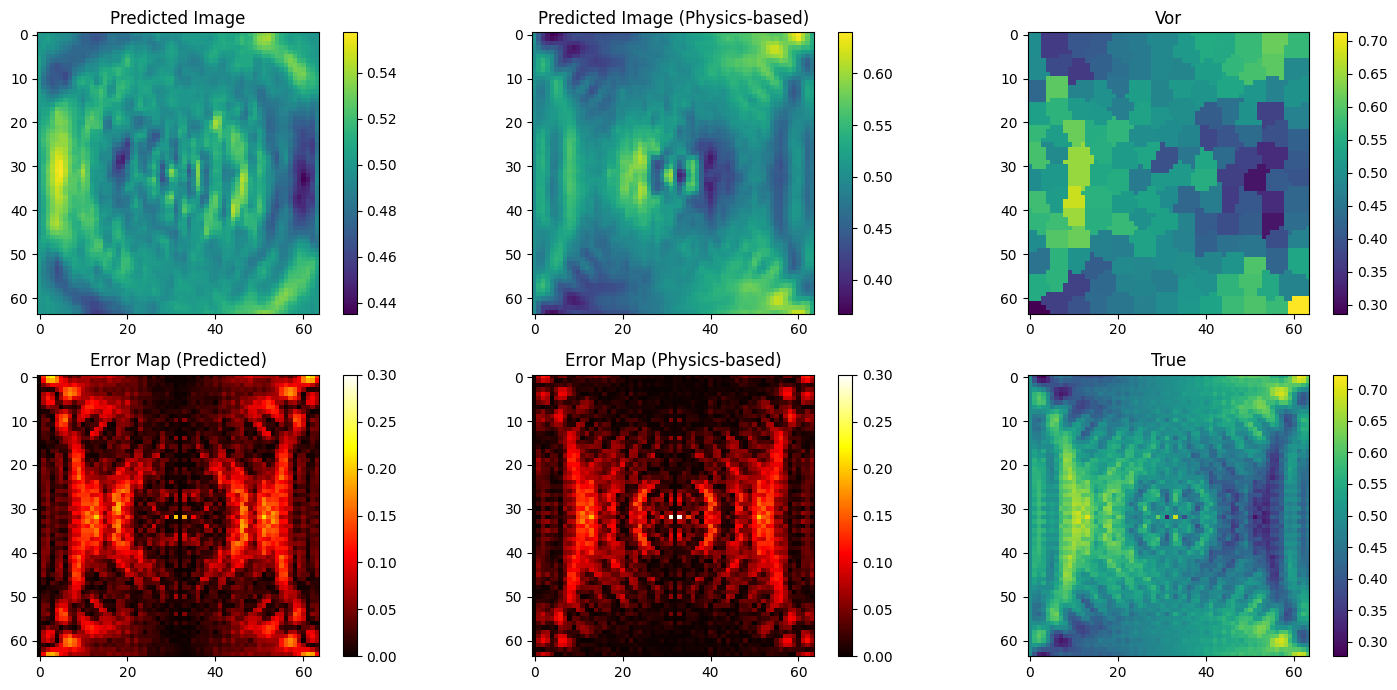

Displaying images for index: 270


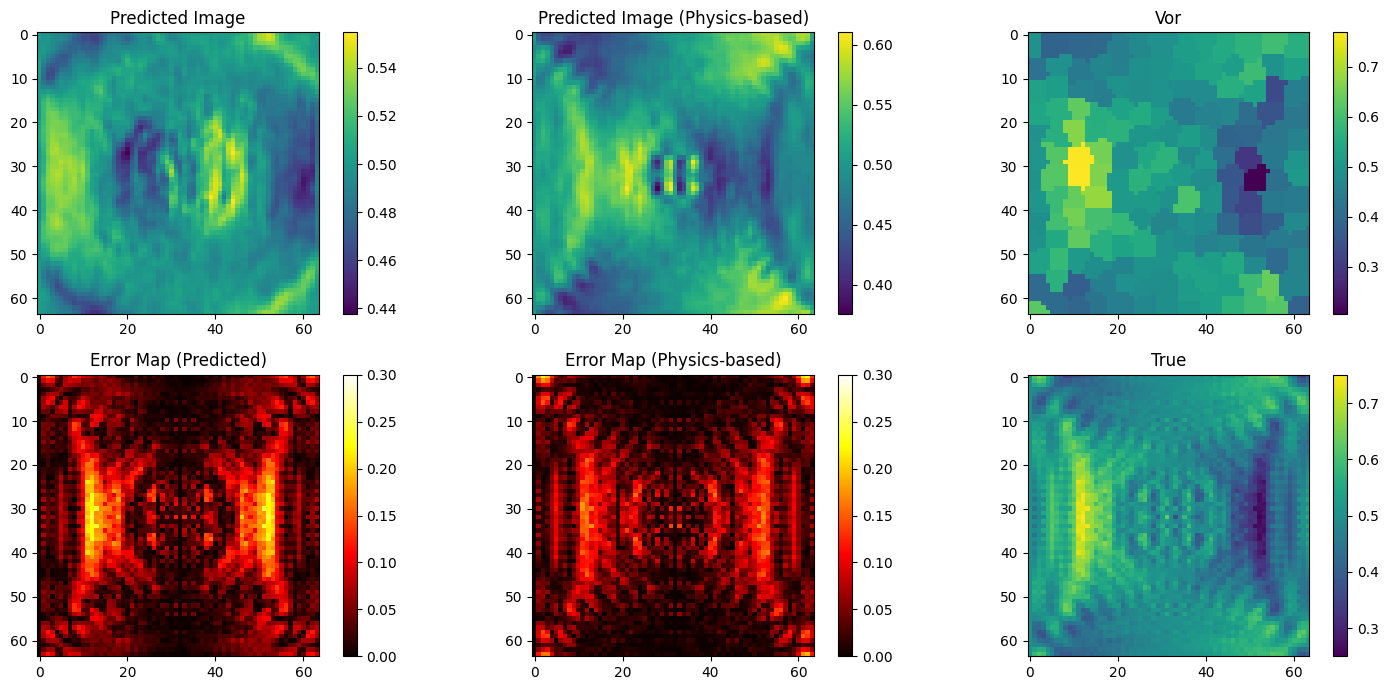

In [ ]:
def plot_error_map(predicted, predicted_phy, true,vor):
    """
    Plots the predicted image, physics-based predicted image, true image,
    and the error maps between predicted/physics-predicted and true images.

    Parameters:
    - predicted: Predicted image
    - predicted_phy: Physics-based predicted image
    - true: True image
    """

    error_map = np.abs(predicted - true)
    error_map_phy = np.abs(predicted_phy - true)

    plt.figure(figsize=(15,7))

    # Plot the Predicted Image
    plt.subplot(2,3,1)
    plt.imshow(predicted)
    plt.title("Predicted Image")
    plt.colorbar()

    # Plot the Physics-based Predicted Image
    plt.subplot(2,3,2)
    plt.imshow(predicted_phy)
    plt.title("Predicted Image (Physics-based)")
    plt.colorbar()

    # Plot the Physics-based Predicted Image
    plt.subplot(2,3,3)
    plt.imshow(vor)
    plt.title("Vor")
    plt.colorbar()

    # Plot the Error Map for Predicted Image
    plt.subplot(2,3,4)
    plt.imshow(error_map, cmap='hot', vmin=0, vmax=0.3)
    plt.title("Error Map (Predicted)")
    plt.colorbar()

    # Plot the Error Map for Physics-based Predicted Image
    plt.subplot(2,3,5)
    plt.imshow(error_map_phy, cmap='hot', vmin=0, vmax=0.3)
    plt.title("Error Map (Physics-based)")
    plt.colorbar()

    # Plot the Error Map for Physics-based Predicted Image
    plt.subplot(2,3,6)
    plt.imshow(true)
    plt.title("True")
    plt.colorbar()
    plt.tight_layout()
    plt.show()

indices_to_display = np.linspace(250, 270, 2, dtype=int)  # 从数据中选择10个索引

for idx in indices_to_display:
    print(f"Displaying images for index: {idx}")
    plot_error_map(reconstructed_images_orig[idx,:,:,0],
                   reconstructed_images_phy[idx,:,:,0],
                   true_test_lstm[idx,:,:,0],
                   vor_test_lstm[idx,:,:,0])


Mounted at /content/drive


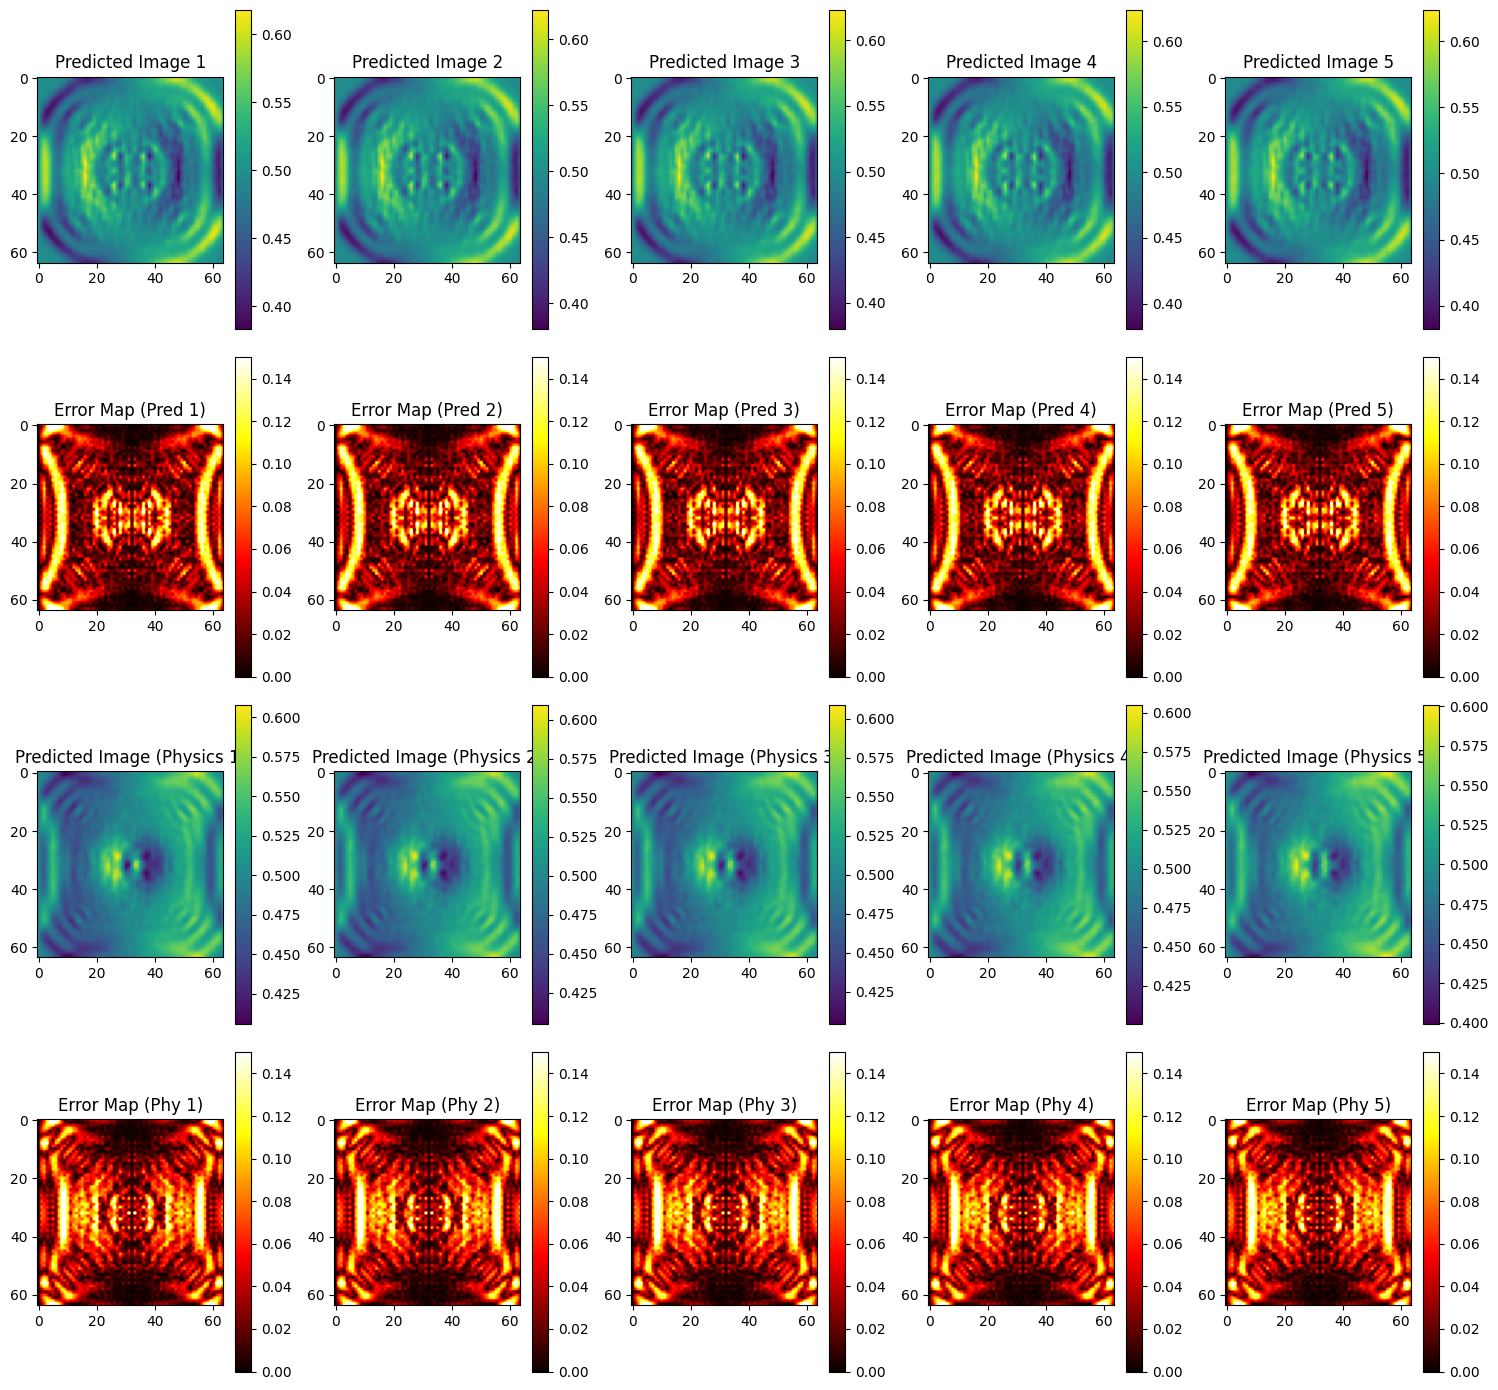

In [ ]:
import matplotlib.colors as mcolors


colors = [(0, 0, 1), (1, 1, 1), (1, 0, 0)]  # R -> White -> B
cmap_name = 'custom_div_cmap'
cm = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors, N=100)


def plot_error_map(predicted, predicted_phy, true):
    """
    Plots the predicted images, physics-based predicted images, true images,
    and the error maps between predicted/physics-predicted and true images.

    Parameters:
    - predicted: List of 5 Predicted images
    - predicted_phy: List of 5 Physics-based predicted images
    - true: List of 5 True images
    """

    plt.figure(figsize=(15,14))

    # Ensure the inputs are lists of images and not single images
    assert len(predicted) == 5
    assert len(predicted_phy) == 5
    assert len(true) == 5

    for i in range(5):
        # Compute error maps
        error_map = np.abs(predicted[i] - true[i])
        error_map_phy = np.abs(predicted_phy[i] - true[i])

        # 1st row: Predicted images
        plt.subplot(4, 5, i + 1)
        plt.imshow(predicted[i])
        plt.title(f"Predicted Image {i+1}")
        plt.colorbar()

        # 2nd row: Error maps for Predicted images
        plt.subplot(4, 5, i + 6)
        plt.imshow(error_map, cmap='hot', vmin=0, vmax=0.15)
        plt.title(f"Error Map (Pred {i+1})")
        plt.colorbar()

        # 3rd row: Physics-based Predicted images
        plt.subplot(4, 5, i + 11)
        plt.imshow(predicted_phy[i])
        plt.title(f"Predicted Image (Physics {i+1})")
        plt.colorbar()

        # 4th row: Error maps for Physics-based Predicted images
        plt.subplot(4, 5, i + 16)
        plt.imshow(error_map_phy, cmap='hot', vmin=0, vmax=0.15)
        plt.title(f"Error Map (Phy {i+1})")
        plt.colorbar()

    plt.tight_layout()
    plt.show()


idx = 230
predicted_group = [reconstructed_images_orig[i,:,:,0] for i in range(idx, idx + 5)]
predicted_phy_group = [reconstructed_images_phy[i,:,:,0] for i in range(idx, idx + 5)]
true_group = [true_test_lstm[i,:,:,0] for i in range(idx, idx + 5)]

plot_error_map(predicted_group, predicted_phy_group, true_group)

In [ ]:
true_test_lstm.shape

(2390, 64, 64, 3)

In [ ]:
from skimage.metrics import structural_similarity as ssim

# Compute SSIM between the two images

ssim_score_orig = ssim(true_test_lstm, reconstructed_images_orig,multichannel=True)
ssim_score_phy = ssim(true_test_lstm, reconstructed_images_phy,multichannel=True)

# Print the SSIM score
print("The SSIM score orig is:", ssim_score_orig)
print("The SSIM score phy is:", ssim_score_phy)


# Flatten the image sets to size (7500, 12288)
flat_set_true = true_test_lstm.reshape((1190, -1))
flat_set_orig = reconstructed_images_orig.reshape((1190, -1))
flat_set_phy = reconstructed_images_phy.reshape((1190, -1))

# Compute the L2 norm between the two flattened sets
diff_vectors_orig = flat_set_true - flat_set_orig
diff_vectors_phy = flat_set_true - flat_set_phy

l2_norms_orig = np.linalg.norm(diff_vectors_orig, axis=1)
l2_norms_phy = np.linalg.norm(diff_vectors_phy, axis=1)


relative_errors_orig = l2_norms_orig / np.linalg.norm(flat_set_true, axis=1)
relative_errors_phy = l2_norms_phy / np.linalg.norm(flat_set_true, axis=1)

mean_relative_error_orig = np.mean(relative_errors_orig)
mean_relative_error_phy = np.mean(relative_errors_phy)


# Print the L2 norm error
print("The L2 norm error orig is:", mean_relative_error_orig)
print("The L2 norm error phy is:", mean_relative_error_phy)

<ipython-input-67-4b4e474d8e24>:5: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_score_orig = ssim(true_test_lstm, reconstructed_images_orig,multichannel=True)
<ipython-input-67-4b4e474d8e24>:6: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_score_phy = ssim(true_test_lstm, reconstructed_images_phy,multichannel=True)


The SSIM score orig is: 0.8086626413936356
The SSIM score phy is: 0.8053506309938703
The L2 norm error orig is: 0.11896717326702691
The L2 norm error phy is: 0.11929783034524057


# ConvAutoencoder + Conv

In [ ]:
vor_train = np.load('/content/vor_train.npy', mmap_mode="r")
true_train = np.load('/content/true_train.npy', mmap_mode="r")
vor_test = np.load('/content/vor_test.npy', mmap_mode="r")
true_test = np.load('/content/true_test.npy', mmap_mode="r")

FileNotFoundError: [Errno 2] No such file or directory: '/content/vor_train.npy'

In [ ]:
def encoder_f(input_img, n):
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Flatten()(x)
    x = Dense(n, activation='relu', name='encoded')(x)
    return Model(inputs=input_img, outputs=x), x

def decoder_f(encoded_img):
    x = Dense(8*8*128, activation='relu')(encoded_img)
    x = Reshape((8, 8, 128))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)

    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same', name='decoded')(x)
    return Model(inputs=encoded_img, outputs=decoded), decoded


In [ ]:
auto_input = Input(shape=(64,64,3))
encoded, x = encoder_f(auto_input,256)
decoded, decode_output = decoder_f(x)
autoencoder = Model(auto_input, decode_output)
autoencoder.compile(optimizer='rmsprop', loss='mse')
autoencoder.summary()

In [ ]:
start_time = time.time()
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="loss", patience=10)
history = autoencoder.fit(true_train, true_train, epochs=50,batch_size=16,callbacks=(early_stopping,reduce_lr),validation_data = (true_test,true_test),shuffle=True)
end_time = time.time()

total_time_trls = start_time - end_time

In [ ]:
# create a new model that outputs the encoded features
encoder_model_true = Model(inputs=auto_input, outputs=x)

# use the encoder to get the encoded features
encoded_true = encoder_model_true.predict(true_test)


In [ ]:
#encoded = norm_auto(encoded_features)
scaler_true = MinMaxScaler()
encoder_true = scaler_true.fit_transform(encoded_true)

In [ ]:
def vor2latent(vor_input, n):
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(vor_input)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Flatten()(x)
    x = Dense(n, activation='relu', name='encoded')(x)
    return Model(inputs=vor_input, outputs=x), x

In [ ]:
#n = res_true.shape[1]
n = 256
vor_input = Input(shape=(64,64,3))
encoder, x = vor2latent(vor_input,n)

encoder.compile(optimizer='rmsprop', loss='mse')
encoder.summary()

In [ ]:
#early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
#reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)
history = encoder.fit(vor_test, encoded_true, epochs=70,batch_size=4,shuffle=True)

In [ ]:
res_cnn = encoder.predict(vor_test)

1. try different latent space
2. increase dataset size
3. add tricks into models
4. baseline LSTM-256 (256,3) 2000,compare to conv 256
5. compare images similarity usinf SSIM

Make slides and summary of res LSIM
5. 5 2 5, pred input's total energy，pred's total energy (compare to real energy)

In [ ]:
cnn_scaler = MinMaxScaler()
res_cnn = cnn_scaler.fit_transform(res_cnn)

In [ ]:

x_train_cnn,x_test_cnn = train_test_split(res_cnn,test_size=0.2)
x_train = np.array([x_train_cnn[i:i+4,:] for i in range(len(x_train_cnn)-4)])
x_test = np.array([x_test_cnn[i:i+4,:,] for i in range(len(x_test_cnn)-4)])


def create_shifted_frames(data, n_frames):
    x = data[0 : data.shape[0] - n_frames]
    y = data[n_frames : data.shape[0]]
    return x, y

# Apply the processing function to the datasets.
x_train, y_train = create_shifted_frames(x_train,4)
x_val, y_val = create_shifted_frames(x_test,4)
x_train.shape

In [ ]:
x_train

In [ ]:

# Build the model
model = Sequential()
model.add(LSTM(128, input_shape=(4, 256)))
model.add(RepeatVector(4))
model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(256)))
model.add(Activation('sigmoid'))

# Compile the model
model.compile(loss='mse', optimizer='rmsprop')

# Print the model summary
model.summary()

In [ ]:
start_time = time.time()
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="loss", patience=10)
history = model.fit(x_train, y_train, epochs=50,batch_size=16,callbacks=(early_stopping,reduce_lr),validation_data = (x_val,y_val),shuffle=True)
end_time = time.time()

total_time_cnn = start_time - end_time

# Pytorch version

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision.transforms import Compose, Resize, ToTensor
decoder_layer = DecoderLayer(new_model)
class DecoderLayerPyTorch(nn.Module):
    def __init__(self, decoder_model):
        super(DecoderLayerPyTorch, self).__init__()
        self.decoder_model = decoder_layer

    def forward(self, x):
        if x is None:
            raise ValueError("Input cannot be None")
        self.decoder_model = decoder_layer
        return self.decoder_model(x)
def preprocess_images_pytorch(y_true, y_pred, decoder_layer):
    y_pred = y_pred.view(-1, 512)
    y_true = y_true.view(-1, 512)
    y_pred = decoder_layer(y_pred)
    y_true = decoder_layer(y_true)
    y_pred = y_pred.view(-1, 15, 64, 64, 3)
    y_true = y_true.view(-1, 15, 64, 64, 3)
    return y_true, y_pred


In [ ]:
class CustomLossPyTorch(nn.Module):
    def __init__(self):
        super(CustomLossPyTorch, self).__init__()

    def forward(self, y_true, y_pred):
        mse_loss = nn.MSELoss()(y_pred, y_true)
        # Add your energy and mass conservation loss calculations here
        return mse_loss


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomLossPyTorch(nn.Module):
    def __init__(self, decoder_layer, n_step=15):
        super(CustomLossPyTorch, self).__init__()
        self.decoder_model = decoder_layer  # Store the decoder layer for reuse
        self.n_step = n_step

    def preprocess_images(self, y_true, y_pred):
        # Use self.decoder_model instead of passing decoder_layer around
        y_pred = y_pred.view(-1, 512)
        y_true = y_true.view(-1, 512)
        y_pred = self.decoder_model(y_pred)
        y_true = self.decoder_model(y_true)
        y_pred = y_pred.view(-1, self.n_step, 64, 64, 3)
        y_true = y_true.view(-1, self.n_step, 64, 64, 3)
        return y_true, y_pred

    def calculate_image_energy(self, img):
        g = 9.81
        dx = 1
        img = img.view(-1, img.shape[2], img.shape[3], 3)

        kinetic_energy = 0.5 * torch.sum(img[..., 0]**2, dim=(1, 2)) * dx**2
        kinetic_energy += 0.5 * torch.sum(img[..., 1]**2, dim=(1, 2)) * dx**2
        potential_energy = 0.5 * g * torch.sum(img[..., 2]**2, dim=(1, 2)) * dx**2
        total_energy = kinetic_energy + potential_energy
        return total_energy

    def calculate_relative_energy_error(self, y_true, y_pred):
        y_true, y_pred = self.preprocess_images(y_true, y_pred)
        energy_true = self.calculate_image_energy(y_true)
        energy_pred = self.calculate_image_energy(y_pred)
        return torch.sum(torch.abs(energy_pred - energy_true))

    def calculate_mass_conservation(self, y):
        y = y.view(-1, y.shape[2], y.shape[3], 3)
        h = y[..., 2:3]
        u = y[..., 0:1]
        v = y[..., 1:2]

        dh_dx = torch.gradient(h, dim=2)[0]
        dh_dy = torch.gradient(h, dim=1)[0]
        du_dx = torch.gradient(u, dim=2)[0]
        dv_dy = torch.gradient(v, dim=1)[0]

        return dh_dx * u + h * du_dx + dh_dy * v + h * dv_dy

    def calculate_mass_conservation_loss(self, y_true, y_pred):

        y_true, y_pred = self.preprocess_images(y_true, y_pred)
        mass_conservation_true = self.calculate_mass_conservation(y_true)
        mass_conservation_pred = self.calculate_mass_conservation(y_pred)
        return torch.mean(torch.abs(mass_conservation_pred - mass_conservation_true))

    def forward(self, y_true, y_pred):
        mse_loss = F.mse_loss(y_pred, y_true)
        energy_restriction = self.calculate_relative_energy_error(y_true, y_pred)
        mass_conservation_loss_value = self.calculate_mass_conservation_loss(y_true, y_pred)
        return mse_loss + 1e-09 * energy_restriction + 0.001 * mass_conservation_loss_value


In [ ]:
import torch.nn as nn

class PhyModelPyTorch(nn.Module):
    def __init__(self, n_step=5):  # Assuming you want to use n_step for something specific
        super(PhyModelPyTorch, self).__init__()
        self.lstm1 = nn.LSTM(input_size=512, hidden_size=64, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=64, hidden_size=64, batch_first=True)
        self.dense = nn.Linear(64, 512)
        self.activation = nn.ReLU()
        self.n_step = n_step  # Use the passed n_step value

    def forward(self, x):
        # Assuming x has the appropriate shape [batch, sequence, feature]
        x, _ = self.lstm1(x)  # Process with first LSTM layer
        # No repetition of x; assume input x to lstm2 is correctly shaped
        x, _ = self.lstm2(x)  # Process with second LSTM layer
        x = self.dense(x)  # Pass through dense layer
        x = self.activation(x)  # Apply activation function
        return x



In [ ]:
x_train = np.load('/content/drive/MyDrive/Physics/Physics/Dataset/x_train_LSTM.npy')
y_train = np.load('/content/drive/MyDrive/Physics/Physics/Dataset/y_train_LSTM.npy')
x_val = np.load('/content/drive/MyDrive/Physics/Physics/Dataset/x_val_LSTM.npy')
y_val = np.load('/content/drive/MyDrive/Physics/Physics/Dataset/y_val_LSTM.npy')


In [ ]:
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import torch.nn as nn

# Assuming x_train, y_train, x_val, y_val are your data tensors
train_dataset = TensorDataset(torch.tensor(x_train, dtype=torch.float), torch.tensor(y_train, dtype=torch.float))
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

val_dataset = TensorDataset(torch.tensor(x_val, dtype=torch.float), torch.tensor(y_val, dtype=torch.float))
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)  # Typically, you don't need to shuffle validation data.

model = PhyModelPyTorch()
optimizer = optim.Adam(model.parameters(), lr=0.001)
mse_loss_fn = nn.MSELoss()
decoder_layer = DecoderLayer(new_model)

# Now pass this instance to CustomLossPyTorch
custom_loss_fn = CustomLossPyTorch(decoder_layer=decoder_layer)

for epoch in range(100):

    # Training phase
    model.train()
    epoch_mse_loss = 0.0
    epoch_custom_loss = 0.0
    for batch_idx, (data, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(data)

        mse_loss = mse_loss_fn(outputs, targets)
        custom_loss = custom_loss_fn(outputs, targets)

        custom_loss.backward()
        optimizer.step()

        epoch_mse_loss += mse_loss.item()
        epoch_custom_loss += custom_loss.item()

    epoch_mse_loss /= len(train_loader)
    epoch_custom_loss /= len(train_loader)

    # Validation phase
    model.eval()
    with torch.no_grad():
        val_mse_loss = 0.0
        val_custom_loss = 0.0
        for data, targets in val_loader:
            outputs = model(data)

            mse_loss = mse_loss_fn(outputs, targets)
            custom_loss = custom_loss_fn(outputs, targets)

            val_mse_loss += mse_loss.item()
            val_custom_loss += custom_loss.item()

        val_mse_loss /= len(val_loader)
        val_custom_loss /= len(val_loader)

    # Print training and validation losses
    print(f"Epoch {epoch+1}: Training MSE Loss = {epoch_mse_loss:.4f}, Training Custom Loss = {epoch_custom_loss:.4f}, "
          f"Validation MSE Loss = {val_mse_loss:.4f}, Validation Custom Loss = {val_custom_loss:.4f}")


AttributeError: Exception encountered when calling layer 'sequential' (type Sequential).

'torch.Size' object has no attribute 'rank'

Call arguments received by layer 'sequential' (type Sequential):
  • inputs=tensor([[0.0386, 0.1733, 0.0000,  ..., 0.0000, 0.0274, 0.0000],
        [0.0649, 0.1565, 0.0000,  ..., 0.0000, 0.0200, 0.0000],
        [0.0715, 0.1468, 0.0000,  ..., 0.0000, 0.0206, 0.0000],
        ...,
        [0.2729, 0.0000, 0.0000,  ..., 0.0000, 0.0121, 0.0000],
        [0.3509, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.3530, 0.0000, 0.0000,  ..., 0.0000, 0.0363, 0.0000]])
  • training=None
  • mask=None